In [46]:
# Build list of forecast file names for a date range and a specific time (HHMM) 
import os, re
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- USER INPUTS ---
start_date = "2025-08-31"   # 'YYYY-MM-DD' or 'YYYYMMDD' (inclusive)
end_date   = "2025-09-30"   # 'YYYY-MM-DD' or 'YYYYMMDD' (inclusive)
time_str   = "1000"         # 'HHMM' e.g. '0100', '0115', '2300'

# --- Build list ---
# Normalize dates with pandas
start = pd.to_datetime(start_date)
end = pd.to_datetime(end_date)

# Validate the time format
if not (isinstance(time_str, str) and len(time_str) == 4 and time_str.isdigit()):
    raise ValueError("time_str must be a string in 'HHMM' format, e.g. '0100' or '1115'.")

# Generate daily dates (inclusive)
dates = pd.date_range(start=start, end=end, freq="D")

# Create file names
names = [f"forecast_{d.strftime('%Y%m%d')}{time_str}.csv" for d in dates]

file_list_df = pd.DataFrame({"filename": names})

# Show results
print(names)           # Python list
file_list_df           # Pandas DataFrame view


['forecast_202508311000.csv', 'forecast_202509011000.csv', 'forecast_202509021000.csv', 'forecast_202509031000.csv', 'forecast_202509041000.csv', 'forecast_202509051000.csv', 'forecast_202509061000.csv', 'forecast_202509071000.csv', 'forecast_202509081000.csv', 'forecast_202509091000.csv', 'forecast_202509101000.csv', 'forecast_202509111000.csv', 'forecast_202509121000.csv', 'forecast_202509131000.csv', 'forecast_202509141000.csv', 'forecast_202509151000.csv', 'forecast_202509161000.csv', 'forecast_202509171000.csv', 'forecast_202509181000.csv', 'forecast_202509191000.csv', 'forecast_202509201000.csv', 'forecast_202509211000.csv', 'forecast_202509221000.csv', 'forecast_202509231000.csv', 'forecast_202509241000.csv', 'forecast_202509251000.csv', 'forecast_202509261000.csv', 'forecast_202509271000.csv', 'forecast_202509281000.csv', 'forecast_202509291000.csv', 'forecast_202509301000.csv']


filename
0   forecast_202508311000.csv
1   forecast_202509011000.csv
2   forecast_202509021000.csv
3   forecast_202509031000.csv
4   forecast_202509041000.csv
5   forecast_202509051000.csv
6   forecast_202509061000.csv
7   forecast_202509071000.csv
8   forecast_202509081000.csv
9   forecast_202509091000.csv
10  forecast_202509101000.csv
11  forecast_202509111000.csv
12  forecast_202509121000.csv
13  forecast_202509131000.csv
14  forecast_202509141000.csv
15  forecast_202509151000.csv
16  forecast_202509161000.csv
17  forecast_202509171000.csv
18  forecast_202509181000.csv
19  forecast_202509191000.csv
20  forecast_202509201000.csv
21  forecast_202509211000.csv
22  forecast_202509221000.csv
23  forecast_202509231000.csv
24  forecast_202509241000.csv
25  forecast_202509251000.csv
26  forecast_202509261000.csv
27  forecast_202509271000.csv
28  forecast_202509281000.csv
29  forecast_202509291000.csv
30  forecast_202509301000.csv

In [59]:
# ===================== PATHS =====================
ACTUALS_CSV = "/home/renga/Desktop/neoen_data/renga_work/data/measurements_neoen_morcenx_sep2025.csv"      # actuals (kW @ 15-min)
PRICES_CSV  = "/home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_utc.csv"             # has measure_date, da_price, Long, Short
FC_DIR      = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")                     # forecast directory

GRID_STATE = Path("/home/renga/Desktop/neoen_data/renga_work/outputs_same_tod/one_step_sign_forecasts.csv")  # predicted grid state 



In [60]:
# Actuals
ACT_TIME_COL = "measure_date"    # UTC tz-aware
ACT_PROD_COL = "prod"            # kW over the 15-min block

# Prices
PRICE_TIME_COL   = "measure_date"  # UTC tz-aware
PRICE_DA_COL     = "da_price_15min"      # EUR/MWh (hourly or 15-min; we'll FFILL to quarters)
PRICE_LONG_COL   = "Long"          # EUR/MWh for overproduction (15-min)
PRICE_SHORT_COL  = "Short"         # EUR/MWh for underproduction (15-min)

# Forecasts 
FC_TARGET_COL = "horizon"          # tz-aware UTC timestamps of the target quarters
FC_DET_COL    = "deterministic"
FC_CLEAR_COL  = "clear_sky"
FC_TS_REGEX   = re.compile(r"forecast_(\d{12})\.csv")   # extract run timestamp from filename
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
 ]

# Units: kW @ 15-min → MWh
KW_TO_MWH_QUARTER = 1.0 / (1000.0 * 4.0)  # 0.00025



# Helper functions reused across runs
ACTUALS_CACHE = None
PRICES_CACHE = None

def normalize_p_selection(p_selection):
    """Accept 10, 'p_10', [10,50,90], etc., and return matching p_* column names."""
    if p_selection is None:
        return []
    def to_col(val):
        s = str(val).strip().lower()
        if s.startswith("p_"):
            return s
        if s.startswith("p"):
            return "p_" + s[1:].zfill(2)
        if s.replace(".", "", 1).isdigit():
            return f"p_{int(float(s)):02d}"
        return None
    choices = [p_selection] if not isinstance(p_selection, (list, tuple, set)) else list(p_selection)
    cols = []
    for val in choices:
        col = to_col(val)
        if col in FC_QUANT_COLS and col not in cols:
            cols.append(col)
    return cols

def load_inputs(refresh: bool = False):
    """Load (and cache) actuals and price tables."""
    global ACTUALS_CACHE, PRICES_CACHE
    if refresh or ACTUALS_CACHE is None or PRICES_CACHE is None:
        actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
        if actuals[ACT_TIME_COL].dtype.tz is None:
            actuals[ACT_TIME_COL] = actuals[ACT_TIME_COL].dt.tz_localize("UTC")
        mask_15 = (actuals[ACT_TIME_COL].dt.minute % 15 == 0) & (actuals[ACT_TIME_COL].dt.second == 0)
        actuals = actuals.loc[mask_15, [ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL).reset_index(drop=True)

        prices = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
        if prices[PRICE_TIME_COL].dtype.tz is None:
            prices[PRICE_TIME_COL] = prices[PRICE_TIME_COL].dt.tz_localize("UTC")
        prices = prices[[PRICE_TIME_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)
        for col in [PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]:
            if col in prices.columns:
                prices[col] = pd.to_numeric(prices[col], errors="coerce")
        prices = prices.set_index(PRICE_TIME_COL).sort_index()
        if PRICE_DA_COL in prices.columns:
            prices[PRICE_DA_COL] = prices[PRICE_DA_COL].ffill()
        prices = prices.reset_index()

        ACTUALS_CACHE, PRICES_CACHE = actuals, prices
    return ACTUALS_CACHE.copy(), PRICES_CACHE.copy()

def run_time_to_path(run_ts_utc: pd.Timestamp) -> Path:
    return FC_DIR / f"forecast_{run_ts_utc.tz_convert('UTC').strftime('%Y%m%d%H%M')}.csv"

def load_forecast_run(run_time_str: str, p_selection=None, include_det=True, include_clear=False):
    run_ts = pd.Timestamp(datetime.strptime(run_time_str, "%Y%m%d%H%M"), tz="UTC")
    fpath = run_time_to_path(run_ts)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing forecast file: {fpath}")

    cols = [FC_TARGET_COL]
    if include_det:
        cols.append(FC_DET_COL)
    if include_clear:
        cols.append(FC_CLEAR_COL)
    cols += normalize_p_selection(p_selection)

    fc = pd.read_csv(fpath, parse_dates=[FC_TARGET_COL], usecols=cols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")
    fc = fc.sort_values(FC_TARGET_COL).reset_index(drop=True)
    fc["run_time"] = run_ts
    fc["lead_hours"] = (fc[FC_TARGET_COL] - run_ts).dt.total_seconds() / 3600.0
    return fc, run_ts, fpath

def _to_utc(series_datetime: pd.Series) -> pd.Series:
    """Ensure a datetime series is UTC tz-aware and in UTC (no conversion issues if already UTC)."""
    if series_datetime.dt.tz is None:
        return series_datetime.dt.tz_localize("UTC")
    return series_datetime.dt.tz_convert("UTC")

def build_run_ledger(run_time_str: str, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    actuals, prices = load_inputs()
    fc, run_ts, fpath = load_forecast_run(run_time_str, p_selection, include_det, include_clear)

    merged = (fc
              .merge(actuals, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left"))

    selected_fc_cols = []
    if include_det and FC_DET_COL in merged.columns:
        selected_fc_cols.append(FC_DET_COL)
    if include_clear and FC_CLEAR_COL in merged.columns:
        selected_fc_cols.append(FC_CLEAR_COL)
    selected_fc_cols += [c for c in normalize_p_selection(p_selection) if c in merged.columns]

    for col in [ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols:
        if col in merged.columns:
            merged[col] = pd.to_numeric(merged[col], errors="coerce")

    if strategy_spec is not None:
        column_name = strategy_spec.get("column_name", "str_1")
        lower_col = strategy_spec.get("lower")
        upper_col = strategy_spec.get("upper")
        grid_state_path = strategy_spec.get("grid_state_path")
        if not all([column_name, lower_col, upper_col, grid_state_path]):
            raise ValueError("strategy_spec must include column_name, lower, upper, and grid_state_path")
        for col in (lower_col, upper_col):
            if col not in merged.columns:
                raise KeyError(f"Required quantile column '{col}' missing from merged forecast data.")
        grid_state = pd.read_csv(grid_state_path, parse_dates=["target_ts"])
        if grid_state["target_ts"].dtype.tz is None:
            grid_state["target_ts"] = grid_state["target_ts"].dt.tz_localize("UTC")
        grid_state = (grid_state
                       .rename(columns={"target_ts": "target_time"})
                       .drop_duplicates(subset=["target_time"], keep="last")
                       [["target_time", "pred_state"]])
        if "target_time" not in merged.columns:
            merged["target_time"] = merged[FC_TARGET_COL]
        merged = merged.merge(grid_state, on="target_time", how="left")
        if merged["pred_state"].isna().all():
            raise ValueError("pred_state is missing after merging grid state data." )
        merged[column_name] = np.where(
            merged["pred_state"] < 0, merged[lower_col],
            np.where(
                merged["pred_state"] > 0, merged[upper_col], 0.5 * (merged[lower_col] + merged[upper_col])
)
        )
        merged[column_name] = pd.to_numeric(merged[column_name], errors="coerce")
        selected_fc_cols.append(column_name)

    merged["actual_MWh"] = merged[ACT_PROD_COL] * KW_TO_MWH_QUARTER
    merged["revenue_EUR"] = merged["actual_MWh"] * merged[PRICE_DA_COL]

    long_df = (merged[[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                     PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols]
               .melt(id_vars=[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                             PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL],
                     var_name="forecast_col", value_name="forecast_kW")
               .rename(columns={FC_TARGET_COL: "target_time"}))
    long_df["forecast_MWh"] = long_df["forecast_kW"] * KW_TO_MWH_QUARTER
    long_df["forecast_type"] = (long_df["forecast_col"]
                                  .str.replace("p_", "p", regex=False)
                                  .mask(long_df["forecast_col"].eq(FC_DET_COL), "deterministic")
                                  .mask(long_df["forecast_col"].eq(FC_CLEAR_COL), "clear_sky"))
    long_df["delta_MWh"] = long_df["actual_MWh"] - long_df["forecast_MWh"]
    long_df["applied_price_EUR_per_MWh"] = np.where(long_df["delta_MWh"] > 0,
                                                     long_df[PRICE_LONG_COL],
                                                     long_df[PRICE_SHORT_COL])
    long_df["penalty_EUR"] = long_df["delta_MWh"] * long_df["applied_price_EUR_per_MWh"]

    long_df = long_df.merge(merged[[FC_TARGET_COL, "revenue_EUR"]].rename(columns={FC_TARGET_COL: "target_time"}),
                             on="target_time", how="left")
    long_df["net_revenue_EUR"] = long_df["revenue_EUR"] + long_df["penalty_EUR"]
    long_df = long_df[["run_time","target_time","lead_hours","forecast_type","actual_MWh","forecast_MWh",
                       "delta_MWh", PRICE_DA_COL,"revenue_EUR","applied_price_EUR_per_MWh","penalty_EUR",
                       "net_revenue_EUR"]].sort_values(["run_time","forecast_type","target_time"]).reset_index(drop=True)

    summary = (long_df.groupby("forecast_type", as_index=False)
               .agg(
                   n_15min=("net_revenue_EUR","size"),
                   total_revenue_EUR=("revenue_EUR","sum"),
                   total_penalty_EUR=("penalty_EUR","sum"),
                   total_net_EUR=("net_revenue_EUR","sum"),
                   mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                   rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
               .sort_values("total_net_EUR", ascending=False))
    return long_df, summary, fpath, run_ts


def build_ledgers_for_runs(file_df: pd.DataFrame, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    """Loop over multiple forecast files and return combined ledger + per-run + cumulative summaries.

    Enforces: for each forecast file, only keep rows belonging to the next calendar day (UTC) after the run timestamp
    parsed from the filename. Example: forecast_202510081115.csv -> keep rows where target_time date == 2025-10-09 (UTC).

    Note: If you pass many files (date range), you'll still see many dates overall — one next-day slice per run.
    """
    if isinstance(file_df, pd.DataFrame):
        filenames = file_df["filename"].tolist()
    else:
        filenames = list(file_df)
    all_ledgers = []
    all_summaries = []
    skipped = []
    for fname in filenames:
        name = Path(fname).name
        match = FC_TS_REGEX.search(name)
        if not match:
            skipped.append((fname, "pattern mismatch"))
            continue
        run_time_str = match.group(1)
        try:
            ledger, _summary_unused, fpath, run_ts = build_run_ledger(run_time_str, p_selection, include_det, include_clear, strategy_spec)
        except FileNotFoundError as exc:
            skipped.append((fname, str(exc)))
            continue

        # Keep only NEXT-DAY rows relative to run_ts (UTC)
        next_day_date = (run_ts.tz_convert("UTC") + pd.Timedelta(days=1)).date()
        ledger = ledger.copy()
        tgt = _to_utc(ledger["target_time"])  # robust tz handling
        ledger = ledger[tgt.dt.date == next_day_date].copy()
        if ledger.empty:
            skipped.append((fname, f"no next-day rows for {next_day_date}"))
            continue

        ledger["forecast_file"] = fpath.name

        # Recompute summary from the filtered ledger
        summary = (ledger.groupby("forecast_type", as_index=False)
                   .agg(
                       n_15min=("net_revenue_EUR","size"),
                       total_revenue_EUR=("revenue_EUR","sum"),
                       total_penalty_EUR=("penalty_EUR","sum"),
                       total_net_EUR=("net_revenue_EUR","sum"),
                       mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                       rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
                   )
                   .sort_values("total_net_EUR", ascending=False))
        summary["forecast_file"] = fpath.name
        summary["run_time"] = run_ts

        all_ledgers.append(ledger)
        all_summaries.append(summary)

    if not all_ledgers:
        print("No forecast files processed.")
        if skipped:
            print("Skipped files:")
            for entry in skipped:
                print("  ", entry[0], "->", entry[1])
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), skipped

    combined_ledger = pd.concat(all_ledgers, ignore_index=True)

    # Safety: re-apply next-day-only filter across combined results (per row's run_time)
    tgt_all = _to_utc(combined_ledger["target_time"]).dt.date
    run_next_dates = (combined_ledger["run_time"].dt.tz_convert("UTC") + pd.Timedelta(days=1)).dt.date
    combined_ledger = combined_ledger[tgt_all == run_next_dates].copy()

    per_run_summary = pd.concat(all_summaries, ignore_index=True)

    cumulative_summary = (combined_ledger.groupby("forecast_type", as_index=False)
                          .agg(
                              n_15min=("net_revenue_EUR","size"),
                              total_revenue_EUR=("revenue_EUR","sum"),
                              total_penalty_EUR=("penalty_EUR","sum"),
                              total_net_EUR=("net_revenue_EUR","sum"),
                              mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                              rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
                          .sort_values("total_net_EUR", ascending=False))

    if skipped:
        print("Skipped files:")
        for entry in skipped:
            print("  ", entry[0], "->", entry[1])

    return combined_ledger, per_run_summary, cumulative_summary, skipped

In [61]:
# Helper functions reused across runs
ACTUALS_CACHE = None
PRICES_CACHE = None

def normalize_p_selection(p_selection):
    """Accept 10, 'p_10', [10,50,90], etc., and return matching p_* column names."""
    if p_selection is None:
        return []
    def to_col(val):
        s = str(val).strip().lower()
        if s.startswith("p_"):
            return s
        if s.startswith("p"):
            return "p_" + s[1:].zfill(2)
        if s.replace(".", "", 1).isdigit():
            return f"p_{int(float(s)):02d}"
        return None
    choices = [p_selection] if not isinstance(p_selection, (list, tuple, set)) else list(p_selection)
    cols = []
    for val in choices:
        col = to_col(val)
        if col in FC_QUANT_COLS and col not in cols:
            cols.append(col)
    return cols

def load_inputs(refresh: bool = False):
    """Load (and cache) actuals and price tables."""
    global ACTUALS_CACHE, PRICES_CACHE
    if refresh or ACTUALS_CACHE is None or PRICES_CACHE is None:
        actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
        if actuals[ACT_TIME_COL].dtype.tz is None:
            actuals[ACT_TIME_COL] = actuals[ACT_TIME_COL].dt.tz_localize("UTC")
        mask_15 = (actuals[ACT_TIME_COL].dt.minute % 15 == 0) & (actuals[ACT_TIME_COL].dt.second == 0)
        actuals = actuals.loc[mask_15, [ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL).reset_index(drop=True)

        prices = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
        if prices[PRICE_TIME_COL].dtype.tz is None:
            prices[PRICE_TIME_COL] = prices[PRICE_TIME_COL].dt.tz_localize("UTC")
        prices = prices[[PRICE_TIME_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)
        for col in [PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]:
            if col in prices.columns:
                prices[col] = pd.to_numeric(prices[col], errors="coerce")
        prices = prices.set_index(PRICE_TIME_COL).sort_index()
        if PRICE_DA_COL in prices.columns:
            prices[PRICE_DA_COL] = prices[PRICE_DA_COL].ffill()
        prices = prices.reset_index()

        ACTUALS_CACHE, PRICES_CACHE = actuals, prices
    return ACTUALS_CACHE.copy(), PRICES_CACHE.copy()

def run_time_to_path(run_ts_utc: pd.Timestamp) -> Path:
    return FC_DIR / f"forecast_{run_ts_utc.tz_convert('UTC').strftime('%Y%m%d%H%M')}.csv"

def load_forecast_run(run_time_str: str, p_selection=None, include_det=True, include_clear=False):
    run_ts = pd.Timestamp(datetime.strptime(run_time_str, "%Y%m%d%H%M"), tz="UTC")
    fpath = run_time_to_path(run_ts)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing forecast file: {fpath}")

    cols = [FC_TARGET_COL]
    if include_det:
        cols.append(FC_DET_COL)
    if include_clear:
        cols.append(FC_CLEAR_COL)
    cols += normalize_p_selection(p_selection)

    fc = pd.read_csv(fpath, parse_dates=[FC_TARGET_COL], usecols=cols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")
    fc = fc.sort_values(FC_TARGET_COL).reset_index(drop=True)
    fc["run_time"] = run_ts
    fc["lead_hours"] = (fc[FC_TARGET_COL] - run_ts).dt.total_seconds() / 3600.0
    return fc, run_ts, fpath

def build_run_ledger(run_time_str: str, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    actuals, prices = load_inputs()
    fc, run_ts, fpath = load_forecast_run(run_time_str, p_selection, include_det, include_clear)

    merged = (fc
              .merge(actuals, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left"))

    selected_fc_cols = []
    if include_det and FC_DET_COL in merged.columns:
        selected_fc_cols.append(FC_DET_COL)
    if include_clear and FC_CLEAR_COL in merged.columns:
        selected_fc_cols.append(FC_CLEAR_COL)
    selected_fc_cols += [c for c in normalize_p_selection(p_selection) if c in merged.columns]

    for col in [ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols:
        if col in merged.columns:
            merged[col] = pd.to_numeric(merged[col], errors="coerce")

    if strategy_spec is not None:
        column_name = strategy_spec.get("column_name", "str_1")
        lower_col = strategy_spec.get("lower")
        upper_col = strategy_spec.get("upper")
        grid_state_path = strategy_spec.get("grid_state_path")
        if not all([column_name, lower_col, upper_col, grid_state_path]):
            raise ValueError("strategy_spec must include column_name, lower, upper, and grid_state_path")
        for col in (lower_col, upper_col):
            if col not in merged.columns:
                raise KeyError(f"Required quantile column '{col}' missing from merged forecast data.")
        grid_state = pd.read_csv(grid_state_path, parse_dates=["target_ts"])
        if grid_state["target_ts"].dtype.tz is None:
            grid_state["target_ts"] = grid_state["target_ts"].dt.tz_localize("UTC")
        grid_state = (grid_state
                       .rename(columns={"target_ts": "target_time"})
                       .drop_duplicates(subset=["target_time"], keep="last")
                       [["target_time", "pred_state"]])
        if "target_time" not in merged.columns:
            merged["target_time"] = merged[FC_TARGET_COL]
        merged = merged.merge(grid_state, on="target_time", how="left")
        if merged["pred_state"].isna().all():
            raise ValueError("pred_state is missing after merging grid state data." )
        merged[column_name] = np.where(
            merged["pred_state"] < 0, merged[lower_col],
            np.where(
                merged["pred_state"] > 0, merged[upper_col], 0.5 * (merged[lower_col] + merged[upper_col])
)
        )
        merged[column_name] = pd.to_numeric(merged[column_name], errors="coerce")
        selected_fc_cols.append(column_name)

    merged["actual_MWh"] = merged[ACT_PROD_COL] * KW_TO_MWH_QUARTER
    merged["revenue_EUR"] = merged["actual_MWh"] * merged[PRICE_DA_COL]

    long_df = (merged[[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                     PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols]
               .melt(id_vars=[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                             PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL],
                     var_name="forecast_col", value_name="forecast_kW")
               .rename(columns={FC_TARGET_COL: "target_time"}))
    long_df["forecast_MWh"] = long_df["forecast_kW"] * KW_TO_MWH_QUARTER
    long_df["forecast_type"] = (long_df["forecast_col"]
                                  .str.replace("p_", "p", regex=False)
                                  .mask(long_df["forecast_col"].eq(FC_DET_COL), "deterministic")
                                  .mask(long_df["forecast_col"].eq(FC_CLEAR_COL), "clear_sky"))
    long_df["delta_MWh"] = long_df["actual_MWh"] - long_df["forecast_MWh"]
    long_df["applied_price_EUR_per_MWh"] = np.where(long_df["delta_MWh"] > 0,
                                                     long_df[PRICE_LONG_COL],
                                                     long_df[PRICE_SHORT_COL])
    long_df["penalty_EUR"] = long_df["delta_MWh"] * long_df["applied_price_EUR_per_MWh"]

    long_df = long_df.merge(merged[[FC_TARGET_COL, "revenue_EUR"]].rename(columns={FC_TARGET_COL: "target_time"}),
                             on="target_time", how="left")
    long_df["net_revenue_EUR"] = long_df["revenue_EUR"] + long_df["penalty_EUR"]
    long_df = long_df[["run_time","target_time","lead_hours","forecast_type","actual_MWh","forecast_MWh",
                       "delta_MWh", PRICE_DA_COL,"revenue_EUR","applied_price_EUR_per_MWh","penalty_EUR",
                       "net_revenue_EUR"]].sort_values(["run_time","forecast_type","target_time"]).reset_index(drop=True)

    summary = (long_df.groupby("forecast_type", as_index=False)
               .agg(
                   n_15min=("net_revenue_EUR","size"),
                   total_revenue_EUR=("revenue_EUR","sum"),
                   total_penalty_EUR=("penalty_EUR","sum"),
                   total_net_EUR=("net_revenue_EUR","sum"),
                   mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                   rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
               .sort_values("total_net_EUR", ascending=False))
    return long_df, summary, fpath, run_ts


def build_ledgers_for_runs(file_df: pd.DataFrame, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    """Loop over multiple forecast files and return combined ledger + per-run + cumulative summaries.

    Enforces: for each forecast file, only keep rows belonging to the next calendar day (UTC) after the run timestamp
    parsed from the filename. Example: forecast_202510081115.csv -> keep rows where target_time date == 2025-10-09 (UTC).
    """
    if isinstance(file_df, pd.DataFrame):
        filenames = file_df["filename"].tolist()
    else:
        filenames = list(file_df)
    all_ledgers = []
    all_summaries = []
    skipped = []
    for fname in filenames:
        name = Path(fname).name
        match = FC_TS_REGEX.search(name)
        if not match:
            skipped.append((fname, "pattern mismatch"))
            continue
        run_time_str = match.group(1)
        try:
            ledger, _summary_unused, fpath, run_ts = build_run_ledger(run_time_str, p_selection, include_det, include_clear, strategy_spec)
        except FileNotFoundError as exc:
            skipped.append((fname, str(exc)))
            continue

        # Keep only NEXT-DAY rows relative to run_ts (UTC)
        next_day_date = (run_ts.tz_convert("UTC") + pd.Timedelta(days=1)).date()
        ledger = ledger.copy()
        # Assumes target_time is tz-aware UTC; if not, localize/convert as needed.
        ledger = ledger[ledger["target_time"].dt.tz_convert("UTC").dt.date == next_day_date].copy()
        if ledger.empty:
            skipped.append((fname, f"no next-day rows for {next_day_date}"))
            continue

        ledger["forecast_file"] = fpath.name

        # Recompute summary from the filtered ledger
        summary = (ledger.groupby("forecast_type", as_index=False)
                   .agg(
                       n_15min=("net_revenue_EUR","size"),
                       total_revenue_EUR=("revenue_EUR","sum"),
                       total_penalty_EUR=("penalty_EUR","sum"),
                       total_net_EUR=("net_revenue_EUR","sum"),
                       mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                       rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
                   )
                   .sort_values("total_net_EUR", ascending=False))
        summary["forecast_file"] = fpath.name
        summary["run_time"] = run_ts

        all_ledgers.append(ledger)
        all_summaries.append(summary)

    if not all_ledgers:
        print("No forecast files processed.")
        if skipped:
            print("Skipped files:")
            for entry in skipped:
                print("  ", entry[0], "->", entry[1])
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), skipped

    combined_ledger = pd.concat(all_ledgers, ignore_index=True)

    # Safety: re-apply next-day-only filter across combined results (per row's run_time)
    tgt_all_dates = combined_ledger["target_time"].dt.tz_convert("UTC").dt.date
    run_next_dates = (combined_ledger["run_time"].dt.tz_convert("UTC") + pd.Timedelta(days=1)).dt.date
    combined_ledger = combined_ledger[tgt_all_dates == run_next_dates].copy()

    per_run_summary = pd.concat(all_summaries, ignore_index=True)

    cumulative_summary = (combined_ledger.groupby("forecast_type", as_index=False)
                          .agg(
                              n_15min=("net_revenue_EUR","size"),
                              total_revenue_EUR=("revenue_EUR","sum"),
                              total_penalty_EUR=("penalty_EUR","sum"),
                              total_net_EUR=("net_revenue_EUR","sum"),
                              mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                              rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
                          .sort_values("total_net_EUR", ascending=False))

    if skipped:
        print("Skipped files:")
        for entry in skipped:
            print("  ", entry[0], "->", entry[1])

    return combined_ledger, per_run_summary, cumulative_summary, skipped

In [62]:
# Parameters for multi-run processing
P_SELECTION  = [10,20,30,40,50,60,70,80,90]
INCLUDE_DET  = True
INCLUDE_CLEAR= False
STRATEGY_SPEC = {
    "column_name": "str_1",
    "lower": "p_40",
    "upper": "p_70",
    "grid_state_path": GRID_STATE
}

combined_ledger, per_run_summary, cumulative_summary, skipped_files = build_ledgers_for_runs(
    file_list_df,
    p_selection=P_SELECTION,
    include_det=INCLUDE_DET,
    include_clear=INCLUDE_CLEAR,
    strategy_spec=STRATEGY_SPEC
)

print(f"Processed {len(per_run_summary['forecast_file'].unique()) if not per_run_summary.empty else 0} forecast runs")
if skipped_files:
    print("\nSome files were skipped (see reasons above).")

print("\nPer-run summary (by forecast type and run):")
display(per_run_summary.sort_values(["run_time","forecast_type"]))

print("\nCumulative summary across all runs:")
display(cumulative_summary)

print("\nCombined ledger preview:")
display(combined_ledger.head(100))

/tmp/ipykernel_6666/4256187266.py:209: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_6666/4256187266.py:210: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
/tmp/ipykernel_6666/4256187266.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_6666/4256187266.py:159: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
/tmp/ipykernel_6666/4256187266.py:209: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_6666/4256187266.py:210: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
/tmp/ipykernel_6666/4256187266.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_6666/4256187266.py:159: RuntimeWarning: 

Skipped files:
   forecast_202508311000.csv -> Missing forecast file: /home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx/forecast_202508311000.csv
   forecast_202509091000.csv -> Missing forecast file: /home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx/forecast_202509091000.csv
   forecast_202509101000.csv -> Missing forecast file: /home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx/forecast_202509101000.csv
   forecast_202509161000.csv -> Missing forecast file: /home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx/forecast_202509161000.csv
   forecast_202509301000.csv -> no next-day rows for 2025-10-01
Processed 26 forecast runs

Some files were skipped (see reasons above).

Per-run summary (by forecast type and run):


forecast_type  n_15min  total_revenue_EUR  total_penalty_EUR  \
5    deterministic       96         467.515358        3248.653371   
10             p10       96         467.515358        -744.177851   
9              p20       96         467.515358         418.406122   
8              p30       96         467.515358        1283.307174   
7              p40       96         467.515358        2214.977978   
..             ...      ...                ...                ...   
282            p60       96         391.551468        -194.794398   
283            p70       96         391.551468        -214.907644   
284            p80       96         391.551468        -245.058877   
285            p90       96         391.551468        -277.844239   
280          str_1       96         391.551468        -156.882963   

     total_net_EUR   mae_MWh  rmse_MWh              forecast_file  \
5      3715.660627  0.595216  0.777005  forecast_202509011000.csv   
10     -277.170594  0.438957  0.557064  forecast_202509011000.csv   
9       885.413378  0.368981  0.478087  forecast_202509011000.csv   
8      1750.314431  0.404635  0.497240  forecast_202509011000.csv   
7      2681.985234  0.472640  0.605192  forecast_202509011000.csv   
..             ...       ...       ...                        ...   
282     196.757071  0.429090  0.431168  forecast_202509291000.csv   
283     176.643824  0.473067  0.475617  forecast_202509291000.csv   
284     146.492592  0.538980  0.542065  forecast_202509291000.csv   
285     113.707229  0.614938  0.617884  forecast_202509291000.csv   
280     234.668506  0.342833  0.345275  forecast_202509291000.csv   

                     run_time  
5   2025-09-01 10:00:00+00:00  
10  2025-09-01 10:00:00+00:00  
9   2025-09-01 10:00:00+00:00  
8   2025-09-01 10:00:00+00:00  
7   2025-09-01 10:00:00+00:00  
..                        ...  
282 2025-09-29 10:00:00+00:00  
283 2025-09-29 10:00:00+00:00  
284 2025-09-29 10:00:00+00:00  
285 2025-09-29 10:00:00+00:00  
280 2025-09-29 10:00:00+00:00  

[286 rows x 9 columns]


Cumulative summary across all runs:


forecast_type  n_15min  total_revenue_EUR  total_penalty_EUR  \
1             p10     2496       15905.063678        2371.383999   
2             p20     2496       15905.063678        1525.613337   
10          str_1     2496       15905.063678        1394.863250   
3             p30     2496       15905.063678         929.242698   
4             p40     2496       15905.063678         157.572512   
5             p50     2496       15905.063678        -722.782938   
0   deterministic     2496       15905.063678        -977.760407   
6             p60     2496       15905.063678       -1643.581343   
7             p70     2496       15905.063678       -3091.782113   
8             p80     2496       15905.063678       -5192.122107   
9             p90     2496       15905.063678       -9702.721837   

    total_net_EUR   mae_MWh  rmse_MWh  
1    18271.504881  0.709268  1.006184  
2    17426.188280  0.647638  1.012035  
10   17295.438193  0.810307  1.253486  
3    16829.817642  0.650434  1.053421  
4    16058.147456  0.681778  1.100428  
5    15177.792006  0.728049  1.155958  
0    14922.814537  0.684264  1.091828  
6    14256.993601  0.785587  1.225691  
7    12808.792830  0.869373  1.314985  
8    10708.452837  1.009182  1.442969  
9     6197.853107  1.257577  1.657976


Combined ledger preview:


run_time               target_time  lead_hours  \
0  2025-09-01 10:00:00+00:00 2025-09-02 00:00:00+00:00       14.00   
1  2025-09-01 10:00:00+00:00 2025-09-02 00:15:00+00:00       14.25   
2  2025-09-01 10:00:00+00:00 2025-09-02 00:30:00+00:00       14.50   
3  2025-09-01 10:00:00+00:00 2025-09-02 00:45:00+00:00       14.75   
4  2025-09-01 10:00:00+00:00 2025-09-02 01:00:00+00:00       15.00   
..                       ...                       ...         ...   
95 2025-09-01 10:00:00+00:00 2025-09-02 23:45:00+00:00       37.75   
96 2025-09-01 10:00:00+00:00 2025-09-02 00:00:00+00:00       14.00   
97 2025-09-01 10:00:00+00:00 2025-09-02 00:15:00+00:00       14.25   
98 2025-09-01 10:00:00+00:00 2025-09-02 00:30:00+00:00       14.50   
99 2025-09-01 10:00:00+00:00 2025-09-02 00:45:00+00:00       14.75   

    forecast_type  actual_MWh  forecast_MWh  delta_MWh  da_price_15min  \
0   deterministic         0.0           NaN        NaN           52.57   
1   deterministic         0.0           NaN        NaN           52.57   
2   deterministic         0.0           NaN        NaN           52.57   
3   deterministic         0.0           NaN        NaN           52.57   
4   deterministic         0.0           NaN        NaN           40.16   
..            ...         ...           ...        ...             ...   
95  deterministic         0.0           NaN        NaN           15.65   
96            p10         0.0           NaN        NaN           52.57   
97            p10         0.0           NaN        NaN           52.57   
98            p10         0.0           NaN        NaN           52.57   
99            p10         0.0           NaN        NaN           52.57   

    revenue_EUR  applied_price_EUR_per_MWh  penalty_EUR  net_revenue_EUR  \
0           0.0                      11.51          NaN              NaN   
1           0.0                       9.09          NaN              NaN   
2           0.0                       9.37          NaN              NaN   
3           0.0                      10.16          NaN              NaN   
4           0.0                       8.63          NaN              NaN   
..          ...                        ...          ...              ...   
95          0.0                       0.17          NaN              NaN   
96          0.0                      11.51          NaN              NaN   
97          0.0                       9.09          NaN              NaN   
98          0.0                       9.37          NaN              NaN   
99          0.0                      10.16          NaN              NaN   

                forecast_file  
0   forecast_202509011000.csv  
1   forecast_202509011000.csv  
2   forecast_202509011000.csv  
3   forecast_202509011000.csv  
4   forecast_202509011000.csv  
..                        ...  
95  forecast_202509011000.csv  
96  forecast_202509011000.csv  
97  forecast_202509011000.csv  
98  forecast_202509011000.csv  
99  forecast_202509011000.csv  

[100 rows x 13 columns]

In [72]:
# --- NaN counts by forecast_type (per-column and total) ---
# Assumes `df` has a column named 'forecast_type'
df = combined_ledger  # for clarity
# Option 1: Per-column NaN counts grouped by forecast_type
nan_counts_per_column = df.groupby('forecast_type').apply(lambda g: g.isna().sum()).astype(int)
# Result: DataFrame where rows are forecast_type and columns are original columns, values = NaN counts

# Option 2: Total NaNs across all columns for each forecast_type
total_nans_by_type = nan_counts_per_column.sum(axis=1).sort_values(ascending=False)
# Result: Series indexed by forecast_type with total NaN counts

# Option 3: Percent of missing cells per forecast_type (excluding the grouping column)
cols = [c for c in df.columns if c != 'forecast_type']
rows_per_type = df.groupby('forecast_type').size()
total_cells_by_type = rows_per_type * len(cols)
# percent_missing_by_type = (nan_counts_per_column[cols].sum(axis=1) / total_cells_by_type * 100).round(3)

# Quick display
# print('Per-column NaN counts (first few columns):')
# display(nan_counts_per_column.iloc[:, :10])  # show up to first 10 columns
print('\nTotal NaNs by forecast_type:')
display(total_nans_by_type)
# print('\nPercent missing (across feature columns) by forecast_type:')
# display(percent_missing_by_type)



Total NaNs by forecast_type:


/tmp/ipykernel_6666/848235778.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_counts_per_column = df.groupby('forecast_type').apply(lambda g: g.isna().sum()).astype(int)


forecast_type
p10              7332
deterministic    7328
p20              7328
p30              7328
p40              7328
p50              7328
p60              7328
p70              7328
p80              7328
p90              7328
str_1            7328
dtype: int64

In [63]:
import matplotlib.ticker as mtick


def _ensure_utc(ts):
    if ts is None:
        return None
    t = pd.Timestamp(ts)
    return t.tz_localize("UTC") if t.tzinfo is None else t.tz_convert("UTC")


def plot_ledger_subset(ledger_subset: pd.DataFrame,
                       label: str,
                       start_ts=None,
                       end_ts=None,
                       selected_types=None,
                       aggregate_runs: bool = True) -> None:
    """Render stacked-bar + time-series plots for a ledger slice."""
    if ledger_subset.empty:
        print(f"{label}: no data available.")
        return

    data = ledger_subset.copy()
    start_ts = _ensure_utc(start_ts)
    end_ts = _ensure_utc(end_ts)
    if start_ts is not None:
        data = data[data["target_time"] >= start_ts]
    if end_ts is not None:
        data = data[data["target_time"] <= end_ts]
    if data.empty:
        print(f"{label}: no rows within the chosen time window.")
        return

    if selected_types:
        selected_types = [ft for ft in selected_types if ft in data["forecast_type"].unique()]
        if not selected_types:
            print(f"{label}: none of the requested forecast types are present.")
            return
        data = data[data["forecast_type"].isin(selected_types)]
    else:
        selected_types = sorted(data["forecast_type"].unique())

    data = data.sort_values(["forecast_type", "target_time"]).reset_index(drop=True)

    # Aggregate totals per forecast type
    agg = (data.groupby("forecast_type", as_index=False)
              .agg(total_revenue_EUR=("revenue_EUR", "sum"),
                   total_penalty_EUR=("penalty_EUR", "sum"),
                   total_net_EUR=("net_revenue_EUR", "sum"),
                   n_15min=("net_revenue_EUR", "size")))

    # Baseline actual revenue (unique sum across target_time, not duplicated per forecast type)
    rev_unique = (data[["target_time", "revenue_EUR"]]
                    .drop_duplicates(subset=["target_time"], keep="last")
                    .sort_values("target_time"))
    rev_baseline_total = float(rev_unique["revenue_EUR"].sum()) if not rev_unique.empty else np.nan

    # Compute pct delta vs deterministic for context
    det_net = np.nan
    if "deterministic" in agg["forecast_type"].values:
        det_net = float(agg.loc[agg["forecast_type"] == "deterministic", "total_net_EUR"].iloc[0])
    agg["pct_vs_det"] = np.nan
    if np.isfinite(det_net) and not np.isclose(det_net, 0.0):
        agg["pct_vs_det"] = (agg["total_net_EUR"] - det_net) / np.abs(det_net) * 100.0

    if ("str_1" in agg["forecast_type"].values) and np.isfinite(det_net) and det_net != 0:
        str_net = float(agg.loc[agg["forecast_type"] == "str_1", "total_net_EUR"].iloc[0])
        pct = float(agg.loc[agg["forecast_type"] == "str_1", "pct_vs_det"].iloc[0])
        print(f"{label}: deterministic total_net_EUR = {det_net:,.2f} €, str_1 = {str_net:,.2f} €, Δ = {pct:.2f}%")

    # ----- Figure 1: Stacked bars (Revenue + Penalty) with revenue baseline line & markers -----
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(agg))
    width = 0.6

    # Stacked bars: base revenue and penalty stacked on top (penalty may be +/-)
    ax.bar(x, agg["total_revenue_EUR"].to_numpy(), width=width,
           label="Actual revenue (sum)", color="#4C78A8", alpha=0.85)
    ax.bar(x, agg["total_penalty_EUR"].to_numpy(), width=width,
           bottom=agg["total_revenue_EUR"].to_numpy(),
           label="Penalty (sum)", color="#F58518", alpha=0.85)

    # Baseline: unique revenue total (same for all forecast types)
    if np.isfinite(rev_baseline_total):
        ax.axhline(rev_baseline_total, color="gray", linestyle="--", linewidth=1.2, label="Revenue baseline")
        # ax.scatter(x, [rev_baseline_total] * len(x), color="black", s=28, zorder=3, label="Baseline marker")

    # Axis formatting and labels
    ax.set_xticks(x)
    ax.set_xticklabels(agg["forecast_type"], rotation=45, ha="right")
    ax.set_ylabel("EUR")
    ax.set_title(f"Totals by forecast type | {label}")
    ax.grid(axis="y", alpha=0.25)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Annotate net totals on top of the stacked bars
    net_vals = agg["total_revenue_EUR"].to_numpy() + agg["total_penalty_EUR"].to_numpy()
    for xi, yi in zip(x, net_vals):
        if np.isfinite(yi):
            ax.annotate(f"{yi:,.0f} €", xy=(xi, yi), xycoords="data",
                        textcoords="offset points", xytext=(0, 4),
                        ha="center", va="bottom", fontsize=8)

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0)
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

    # ----- Figure 2: Time-series: Actual revenue (+ markers) and penalties per forecast type -----
    fig, ax1 = plt.subplots(figsize=(11, 7))
    if aggregate_runs:
        rev_series = (data.groupby("target_time", as_index=False)["revenue_EUR"].sum())
    else:
        rev_series = (data[["target_time", "revenue_EUR"]]
                        .drop_duplicates(subset=["target_time"], keep="last")
                        .sort_values("target_time"))

    ax1.plot(rev_series["target_time"], rev_series["revenue_EUR"],
             label="Revenue (actual)", color="#4C78A8", linewidth=1.6, marker="o", markersize=3)
    ax1.set_xlabel("Time (UTC)")
    ax1.set_ylabel("Revenue (€)")
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    ax2 = ax1.twinx()
    cmap = plt.get_cmap("tab10", len(selected_types))
    for idx, ft in enumerate(selected_types):
        if aggregate_runs:
            s = (data.loc[data["forecast_type"] == ft]
                    .groupby("target_time", as_index=False)["penalty_EUR"].sum())
        else:
            s = (data.loc[data["forecast_type"] == ft, ["target_time", "penalty_EUR"]]
                    .sort_values("target_time"))
        ax2.plot(s["target_time"], s["penalty_EUR"], label=f"{ft} penalty",
                 color=cmap(idx), linewidth=1.4, alpha=0.9)

    # Zero line for penalty axis (since penalties may be +/-)
    ax2.axhline(0, color="#888", linewidth=0.8)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.02, 1.0), ncol=2, borderaxespad=0.0)
    ax2.set_ylabel("Penalty (€)")
    plt.title(f"Revenue (left) & Penalty (right) | {label}")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


2025-09-01 to 2025-09-30 : deterministic total_net_EUR = 14,922.81 €, str_1 = 17,295.44 €, Δ = 15.90%


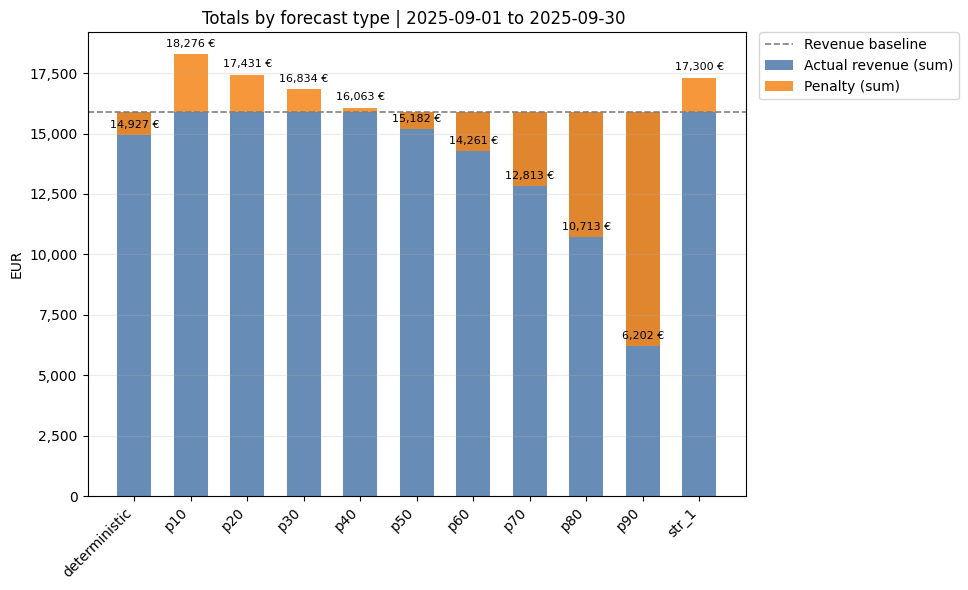

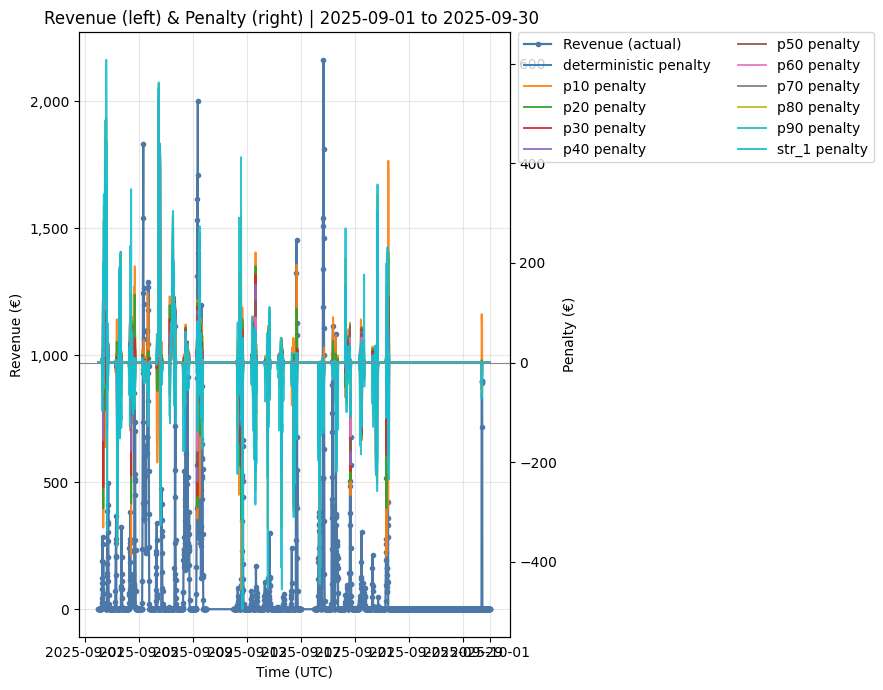

Run forecast_202509011000.csv: deterministic total_net_EUR = 3,715.66 €, str_1 = 5,518.06 €, Δ = 48.51%


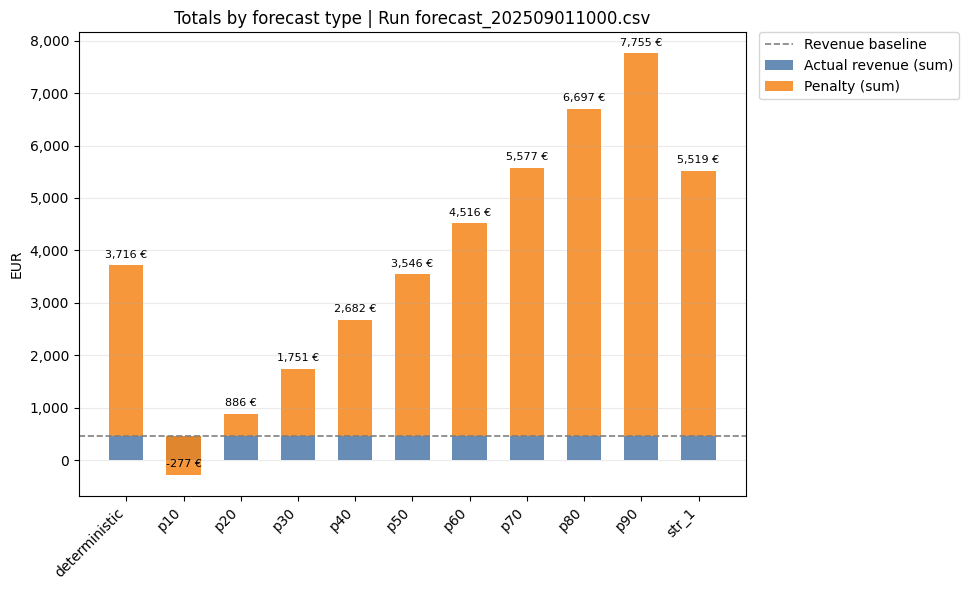

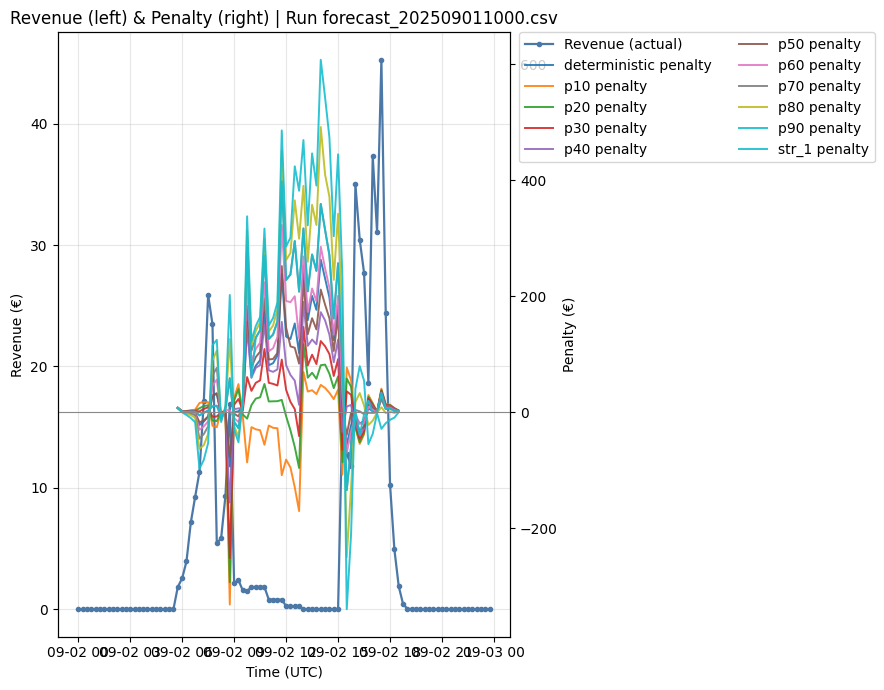

Run forecast_202509021000.csv: deterministic total_net_EUR = -1,011.86 €, str_1 = -966.25 €, Δ = 4.51%


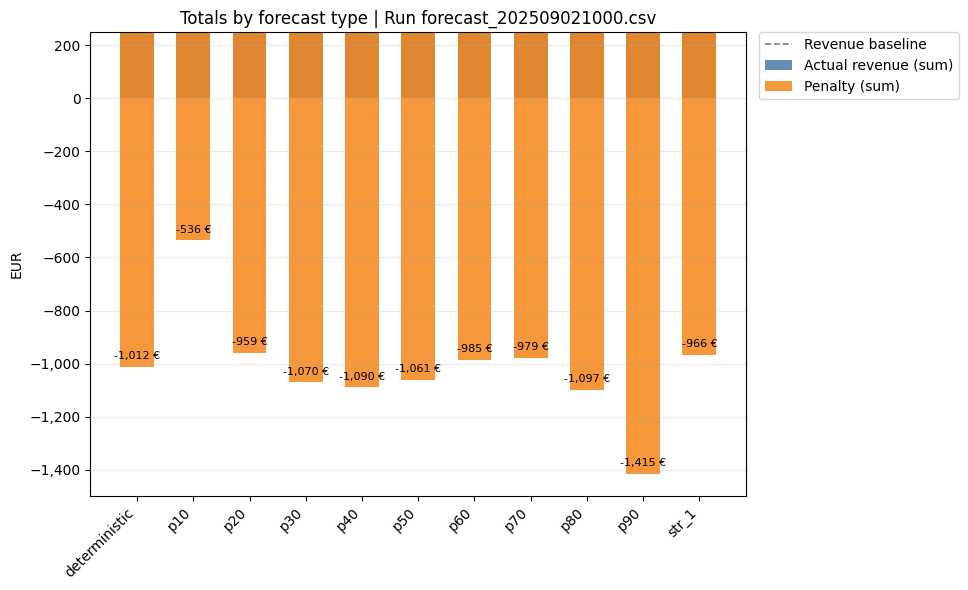

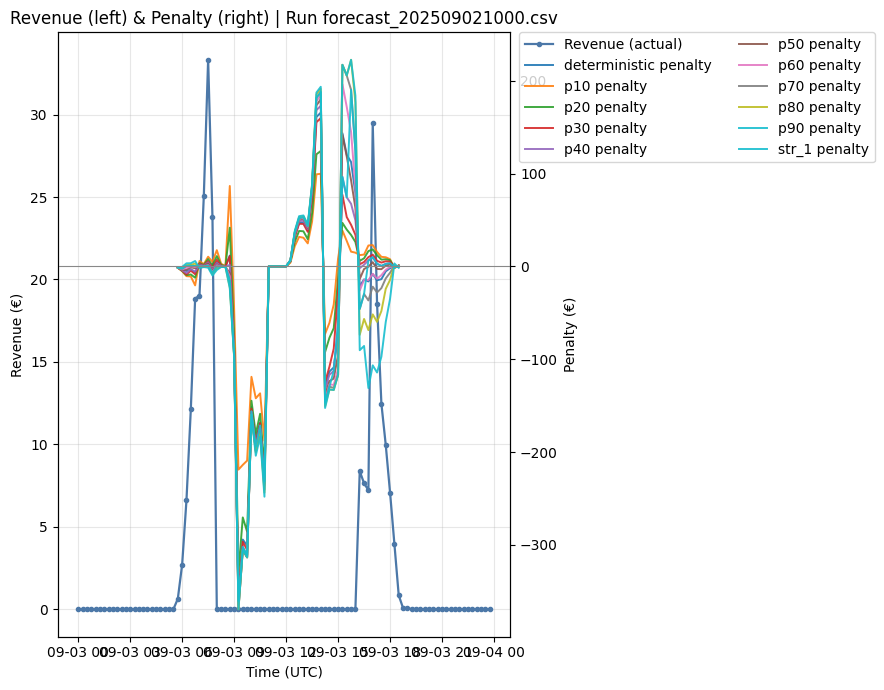

Run forecast_202509031000.csv: deterministic total_net_EUR = 433.81 €, str_1 = 486.68 €, Δ = 12.19%


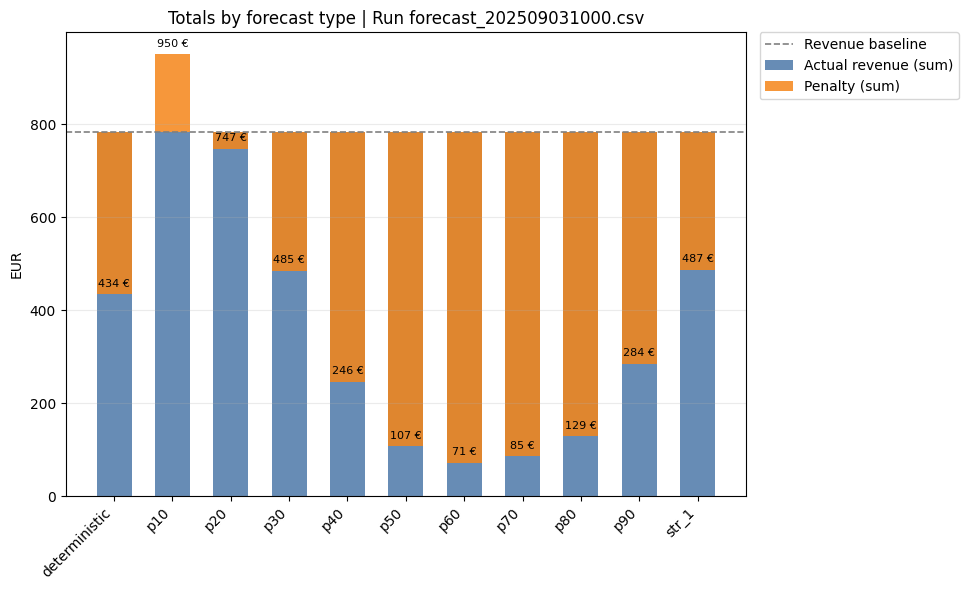

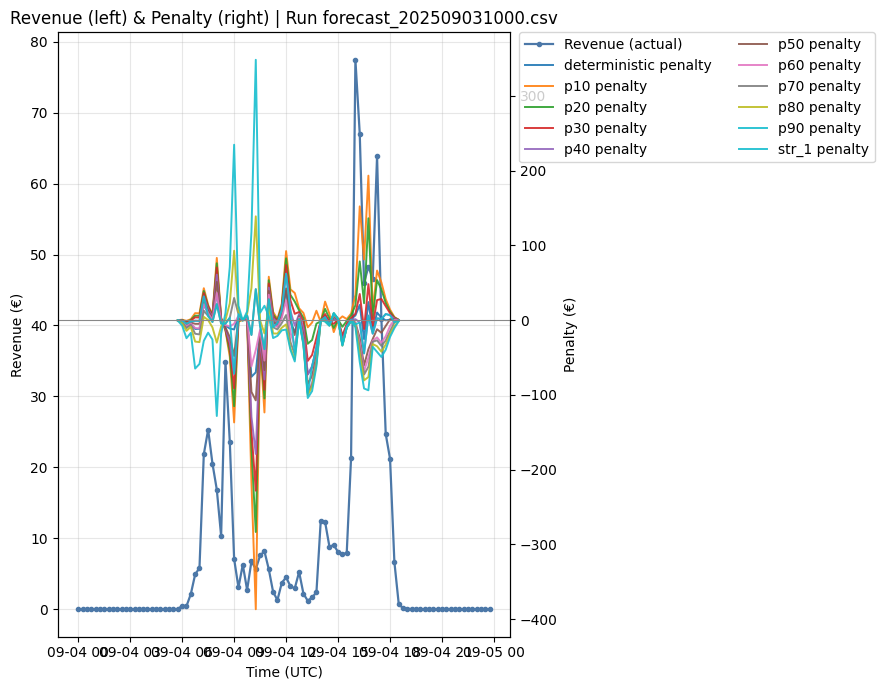

Run forecast_202509041000.csv: deterministic total_net_EUR = 2,905.26 €, str_1 = 2,648.06 €, Δ = -8.85%


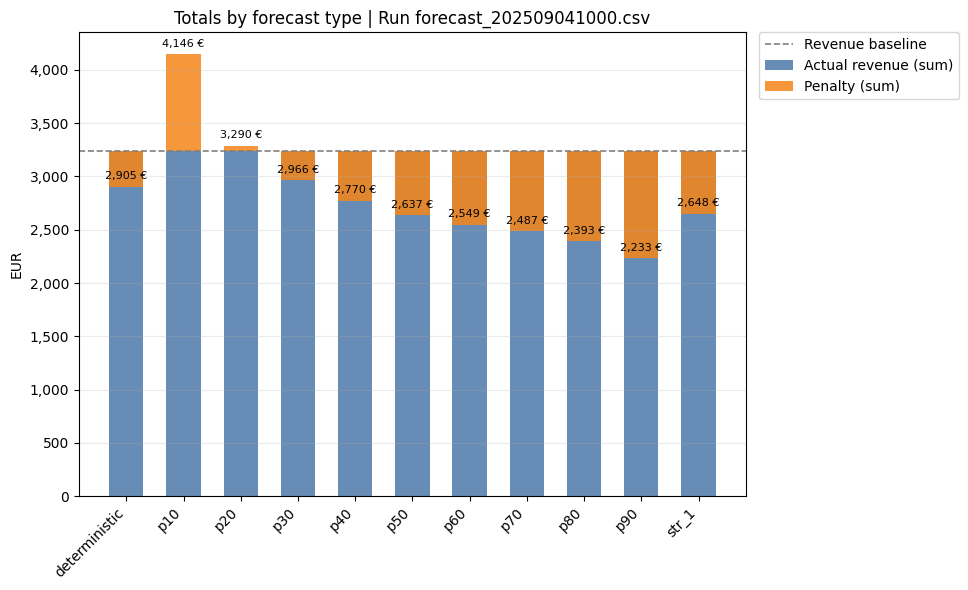

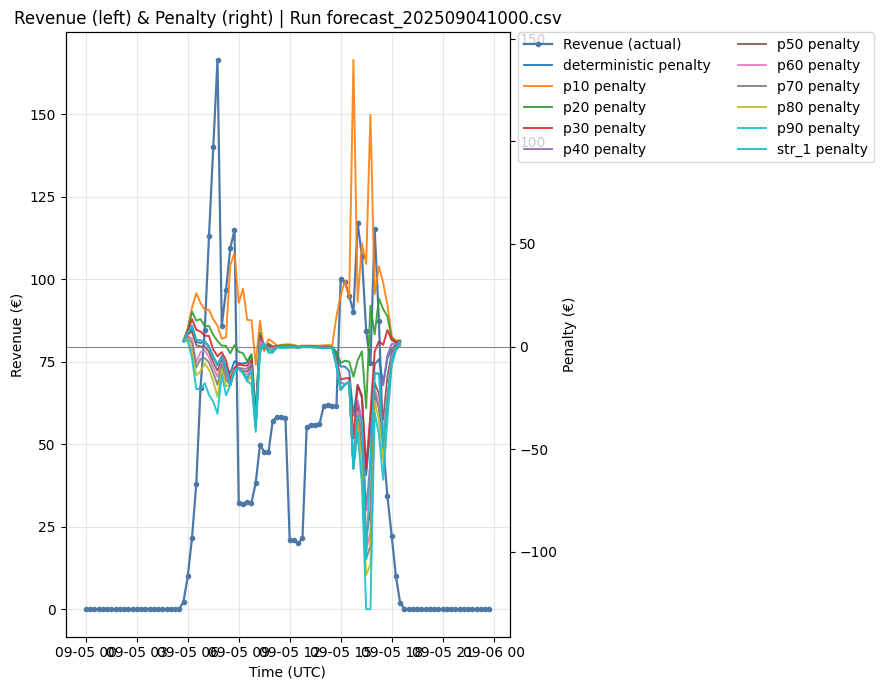

Run forecast_202509051000.csv: deterministic total_net_EUR = 4,931.00 €, str_1 = 5,389.47 €, Δ = 9.30%


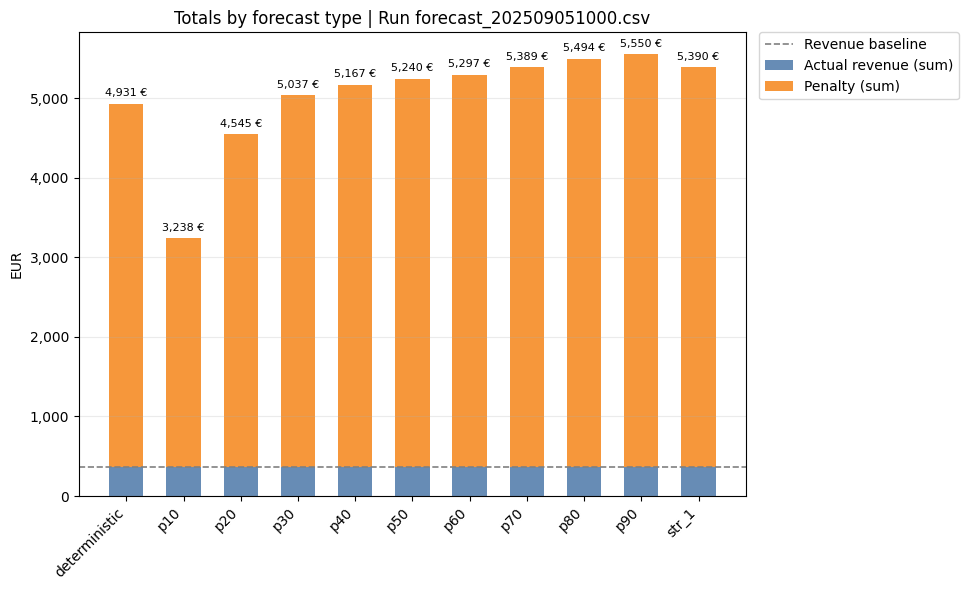

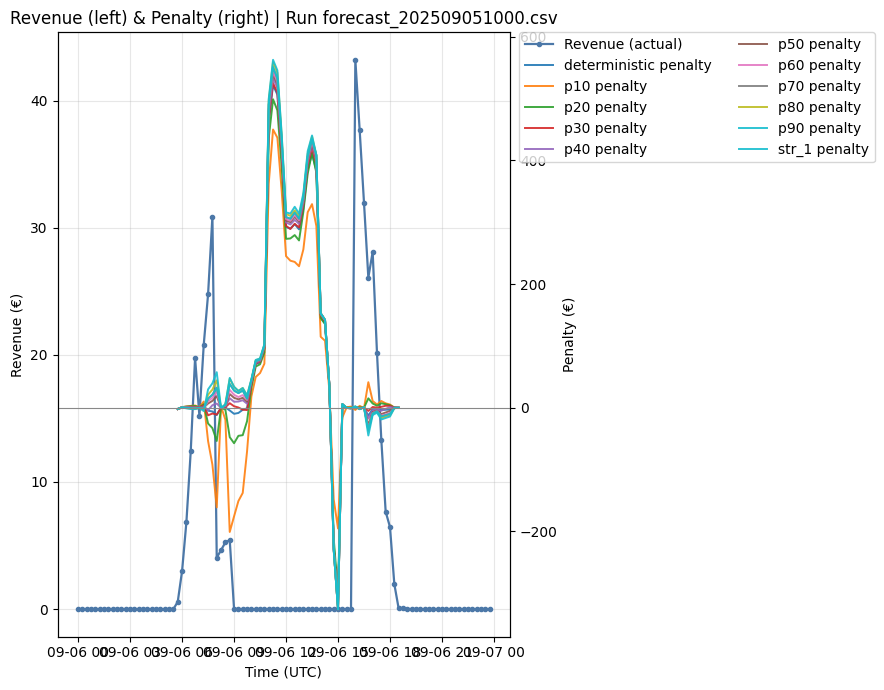

Run forecast_202509061000.csv: deterministic total_net_EUR = 3,101.08 €, str_1 = 3,712.23 €, Δ = 19.71%


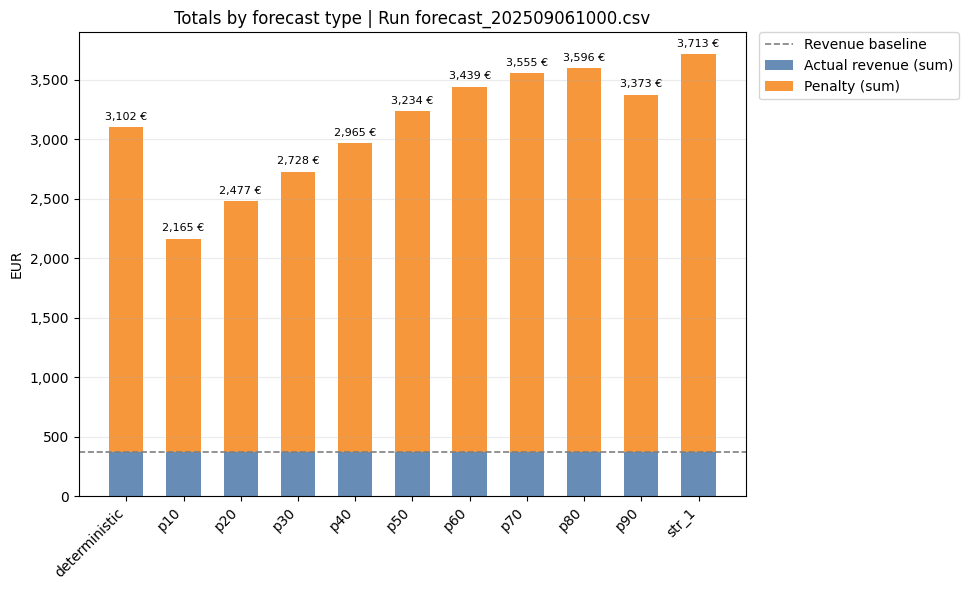

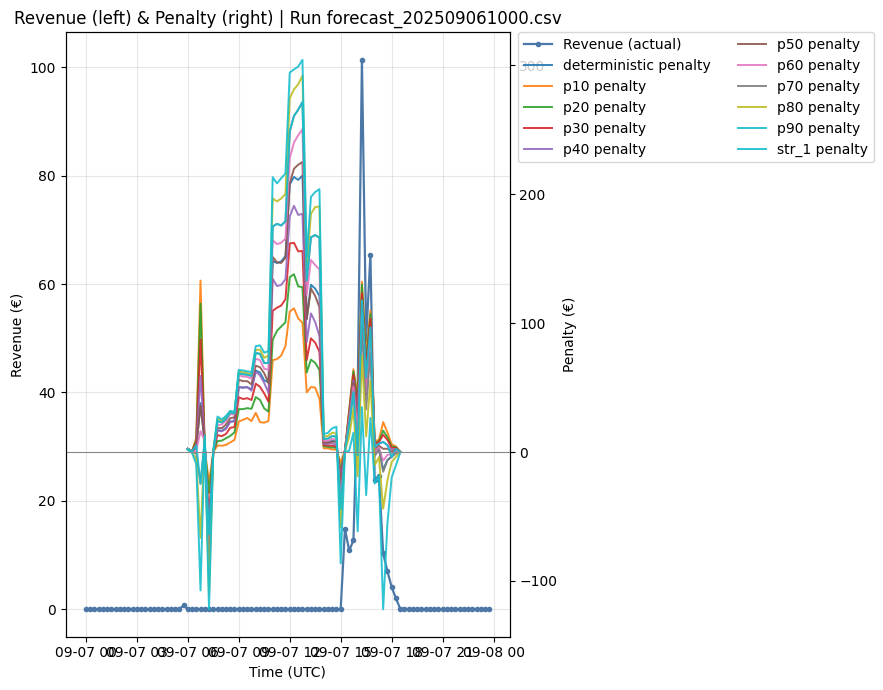

Run forecast_202509071000.csv: deterministic total_net_EUR = 1,070.33 €, str_1 = 960.35 €, Δ = -10.28%


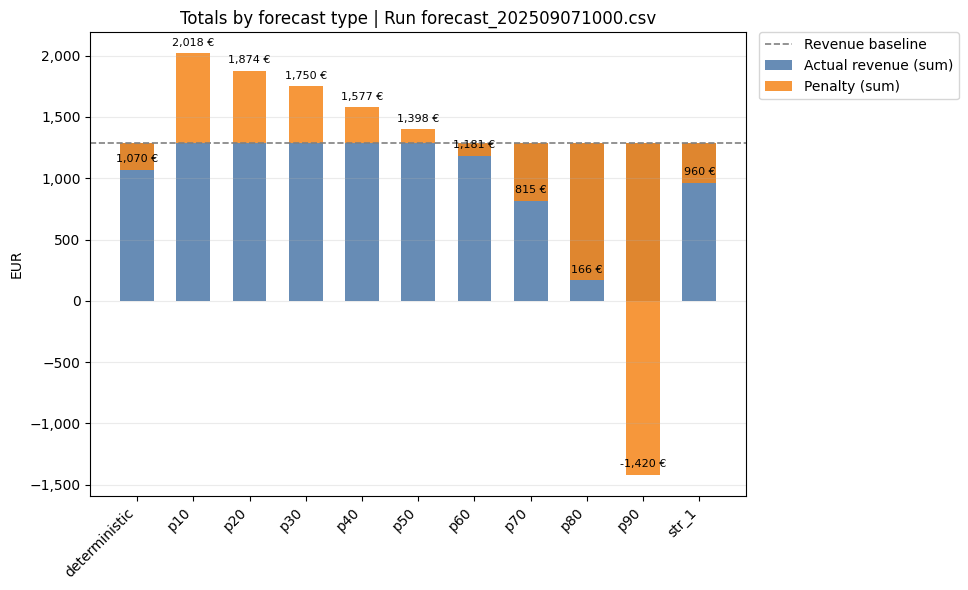

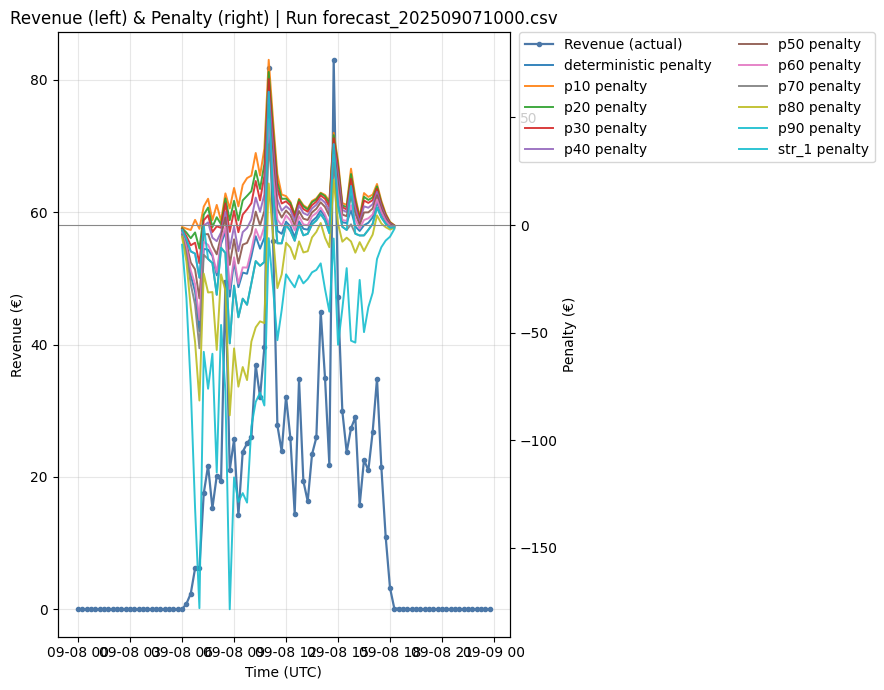

Run forecast_202509081000.csv: deterministic total_net_EUR = 2,766.81 €, str_1 = 2,447.38 €, Δ = -11.55%


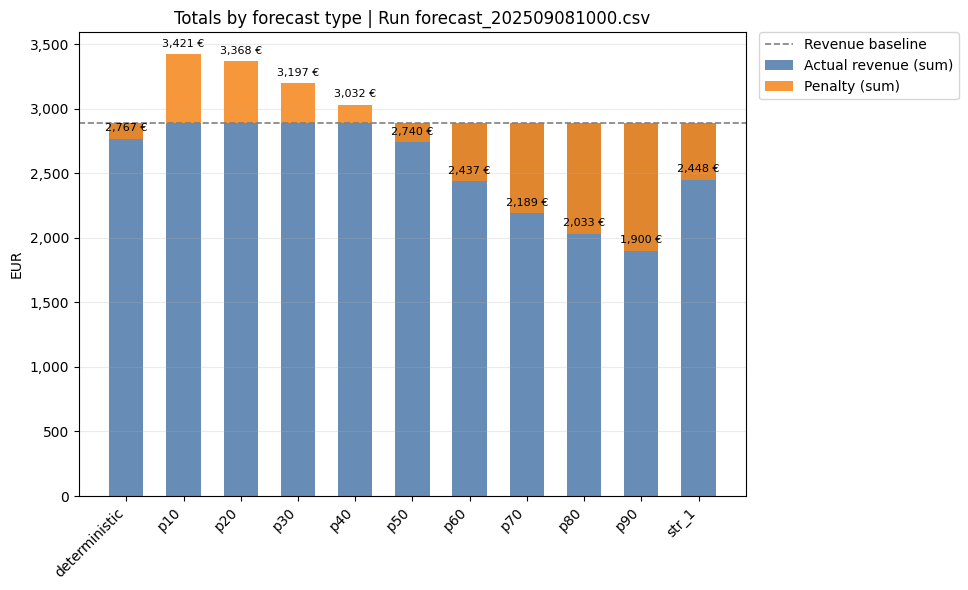

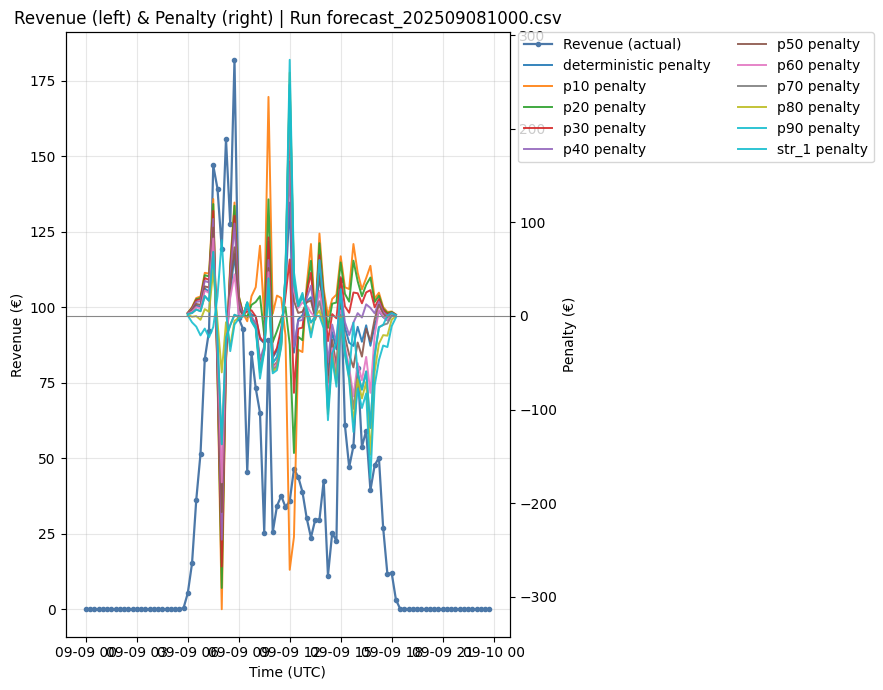

Run forecast_202509111000.csv: deterministic total_net_EUR = 52.41 €, str_1 = -202.68 €, Δ = -486.72%


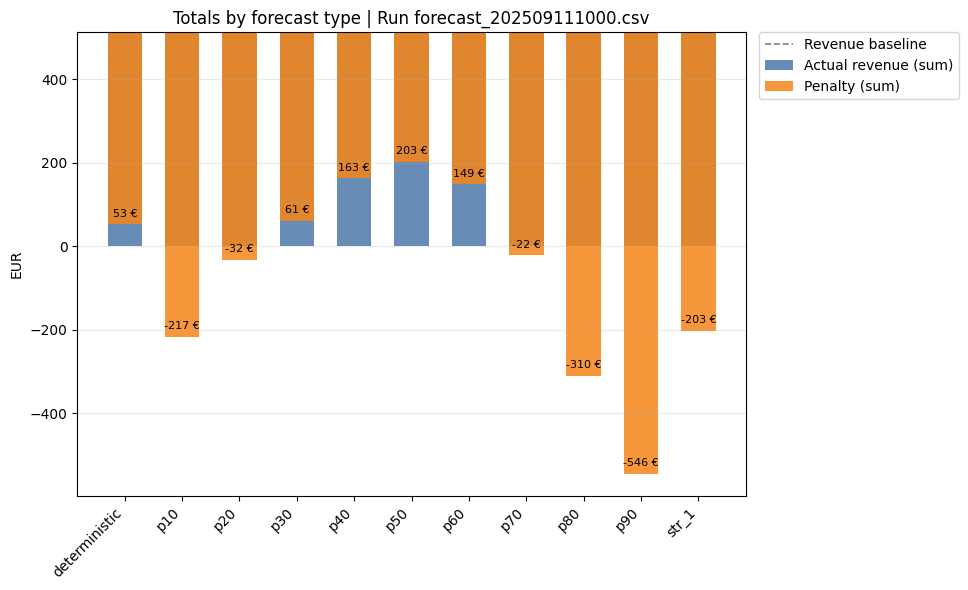

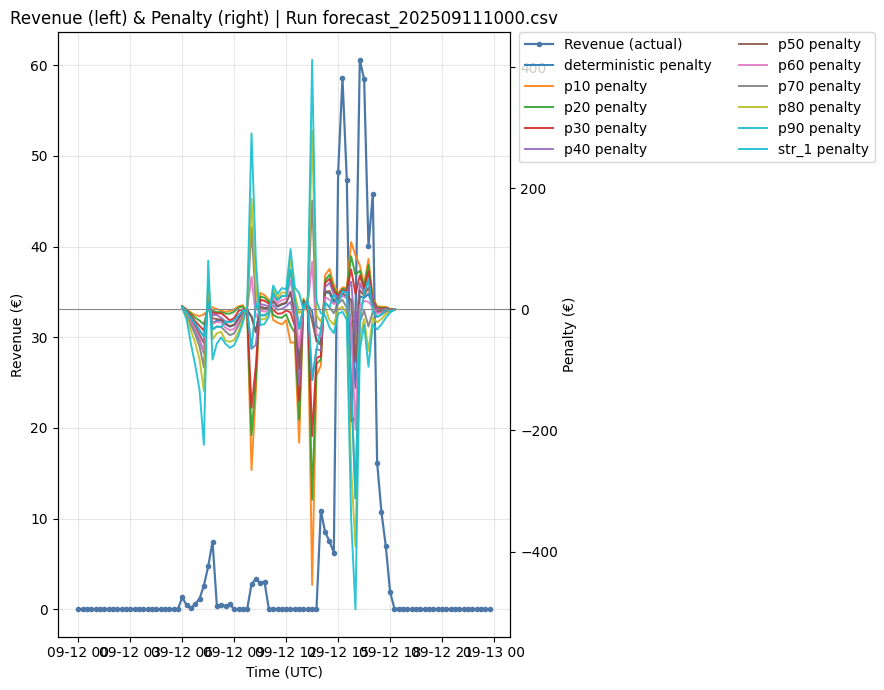

Run forecast_202509121000.csv: deterministic total_net_EUR = -216.69 €, str_1 = -340.43 €, Δ = -57.11%


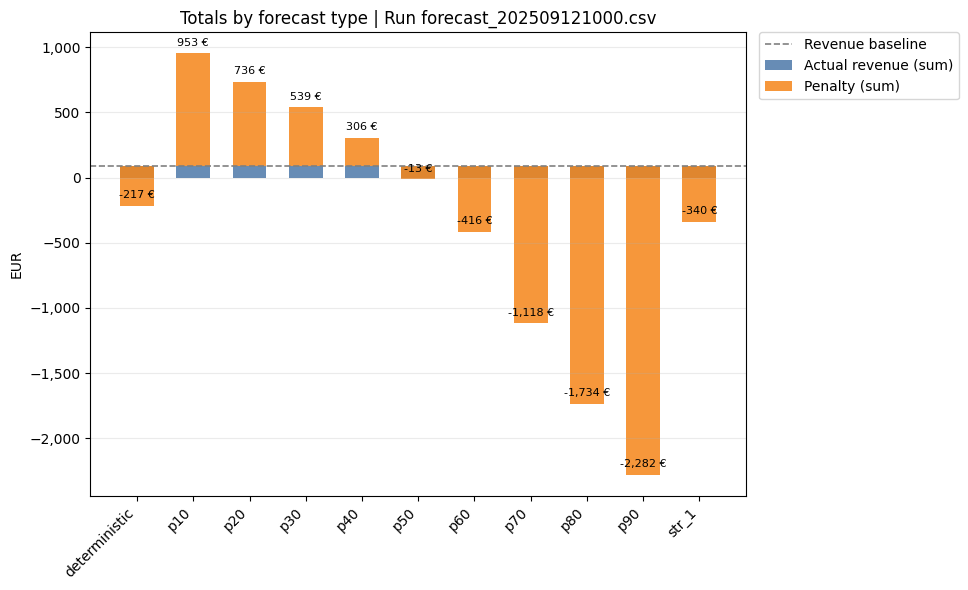

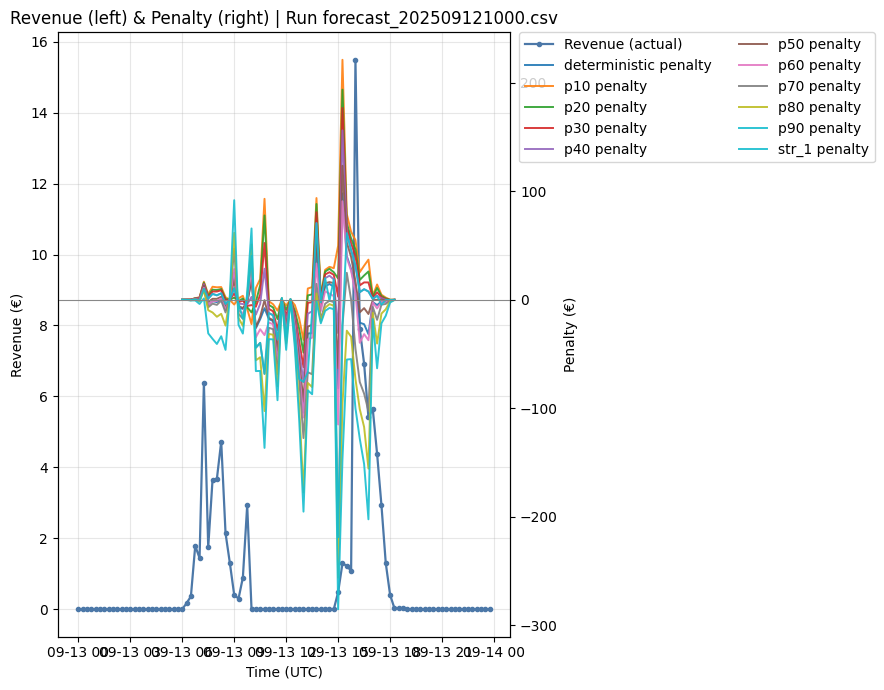

Run forecast_202509131000.csv: deterministic total_net_EUR = -29.37 €, str_1 = 84.98 €, Δ = 389.32%


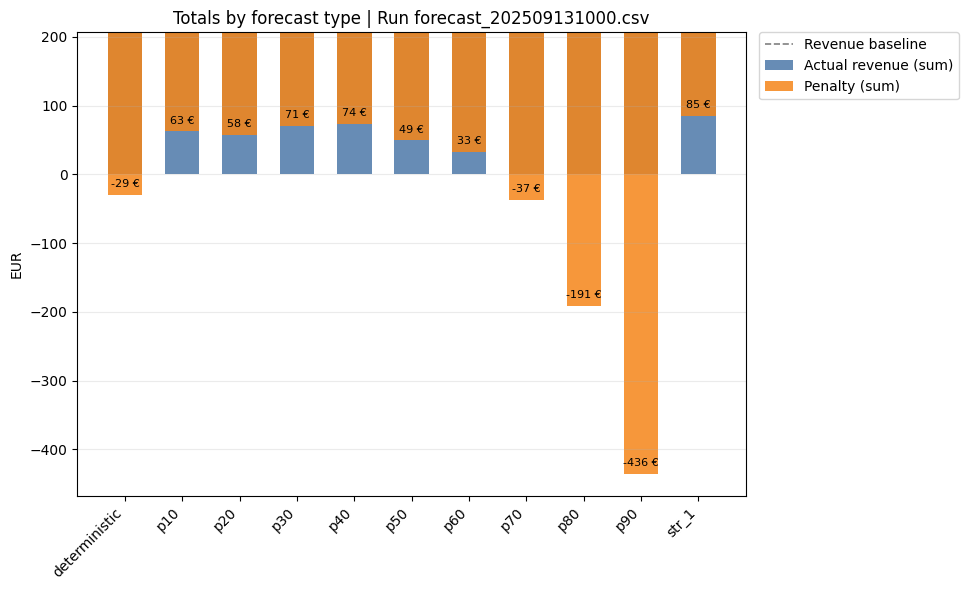

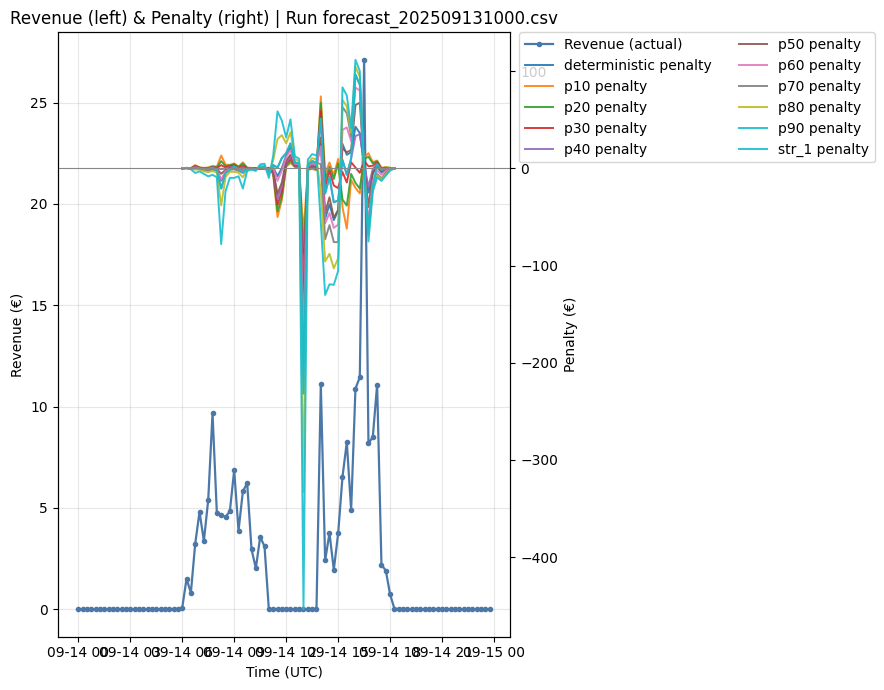

Run forecast_202509141000.csv: deterministic total_net_EUR = -399.27 €, str_1 = -246.45 €, Δ = 38.28%


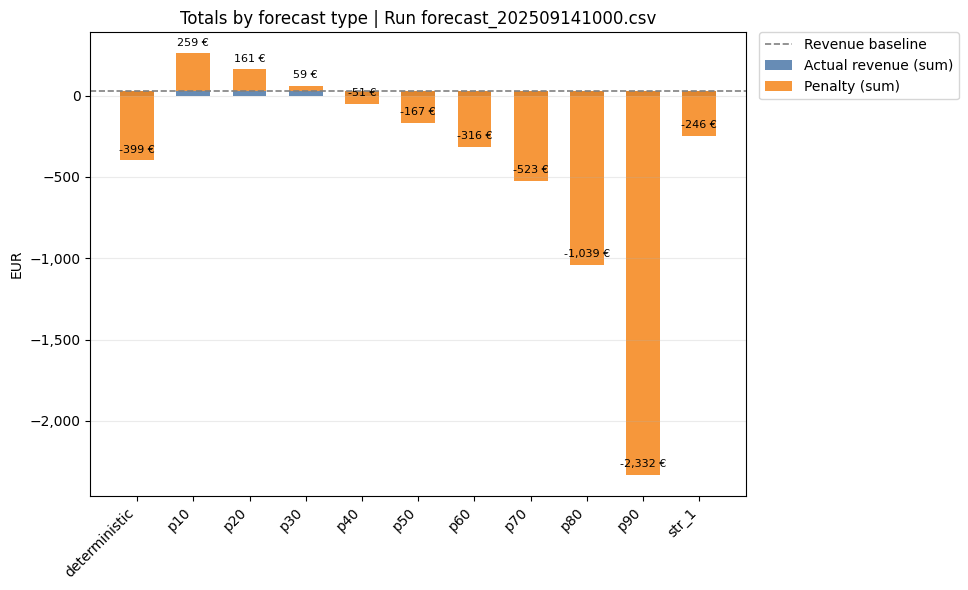

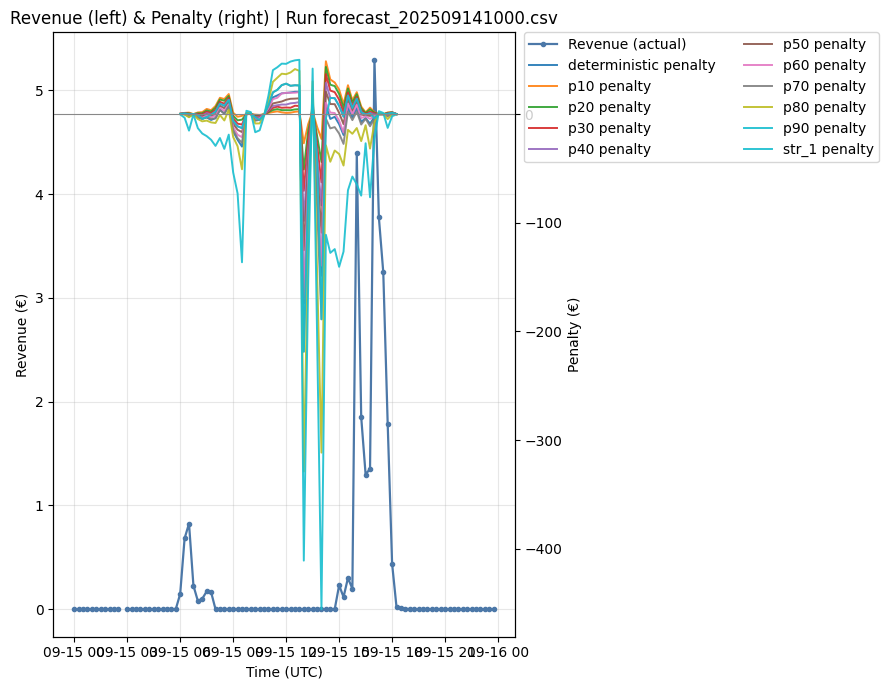

Run forecast_202509151000.csv: deterministic total_net_EUR = -1,003.61 €, str_1 = -1,283.00 €, Δ = -27.84%


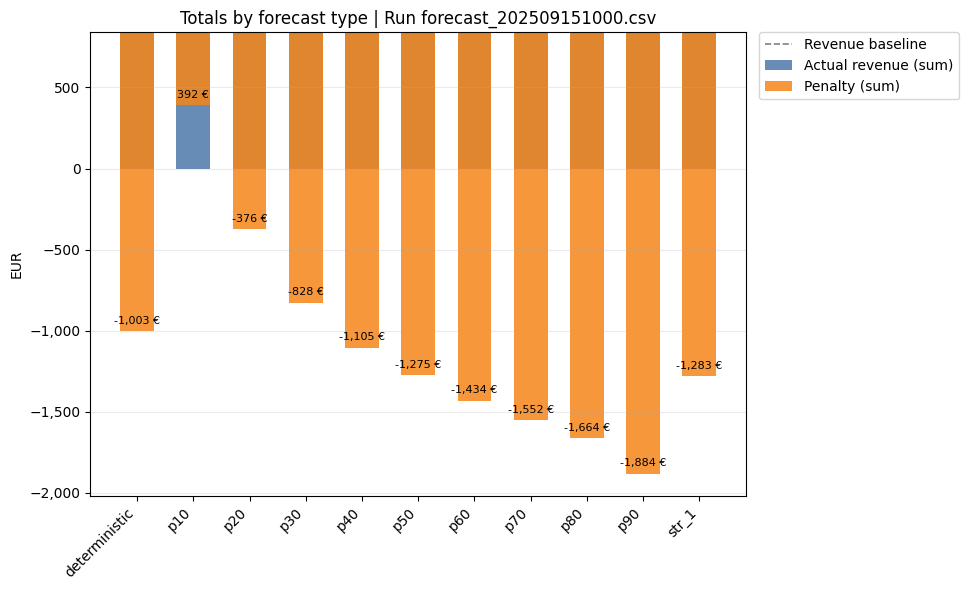

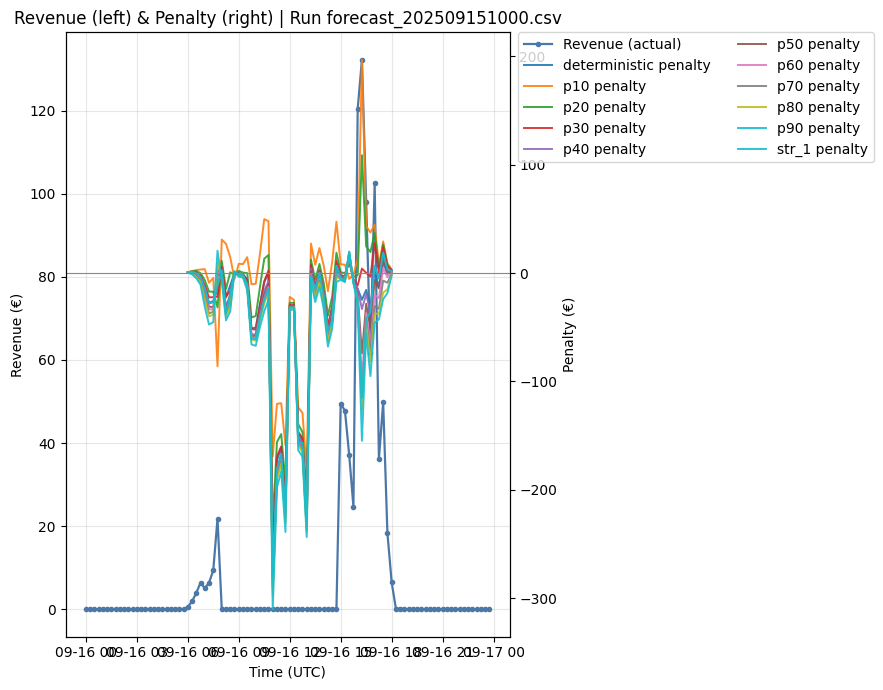

Run forecast_202509171000.csv: deterministic total_net_EUR = -1,867.14 €, str_1 = -2,092.32 €, Δ = -12.06%


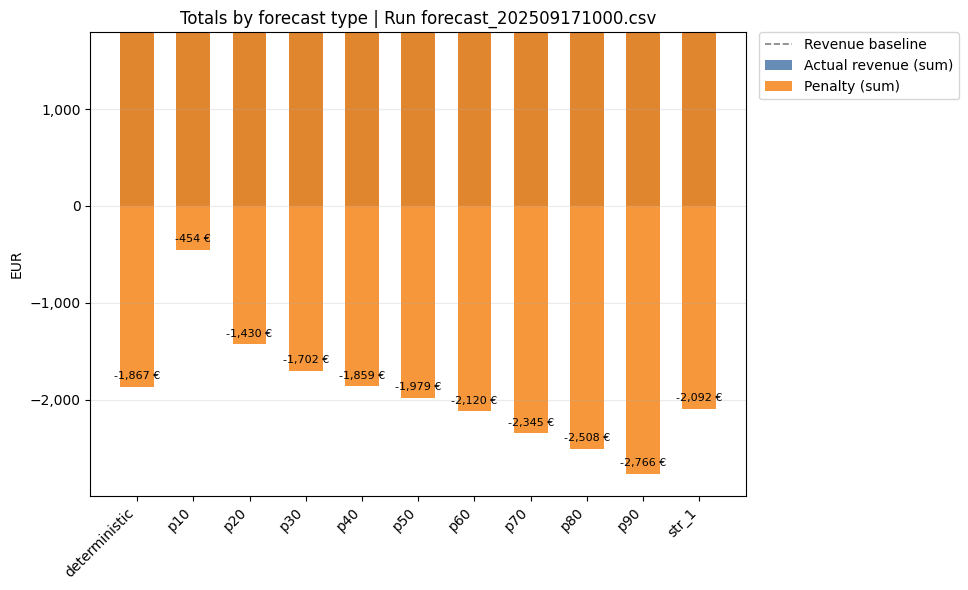

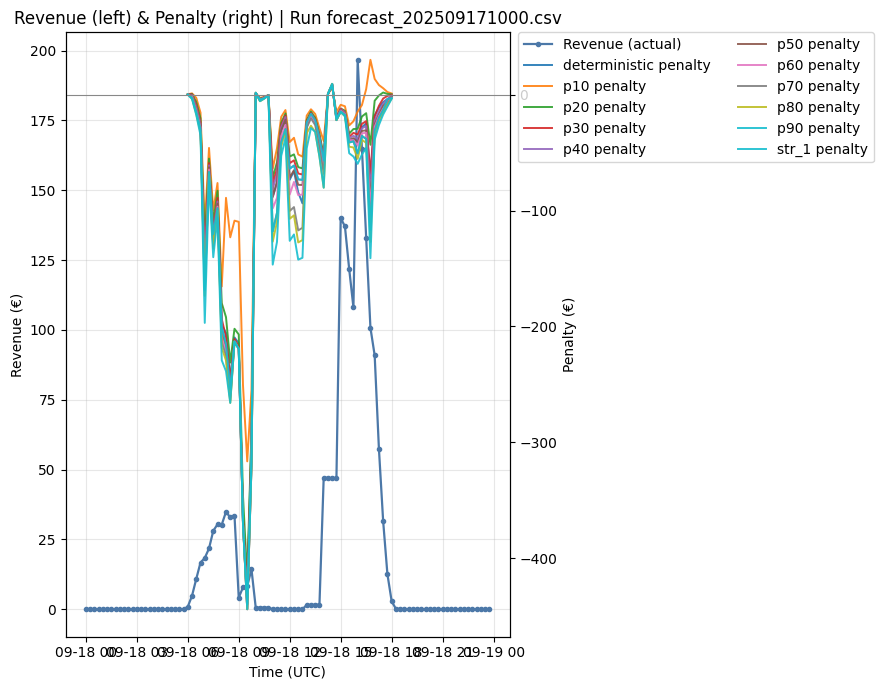

Run forecast_202509181000.csv: deterministic total_net_EUR = 555.79 €, str_1 = 342.01 €, Δ = -38.46%


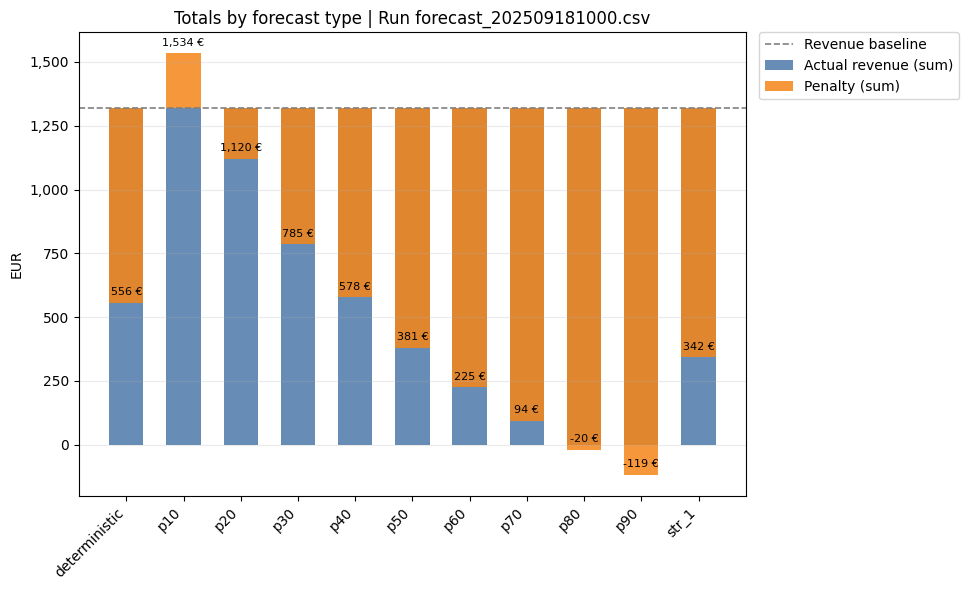

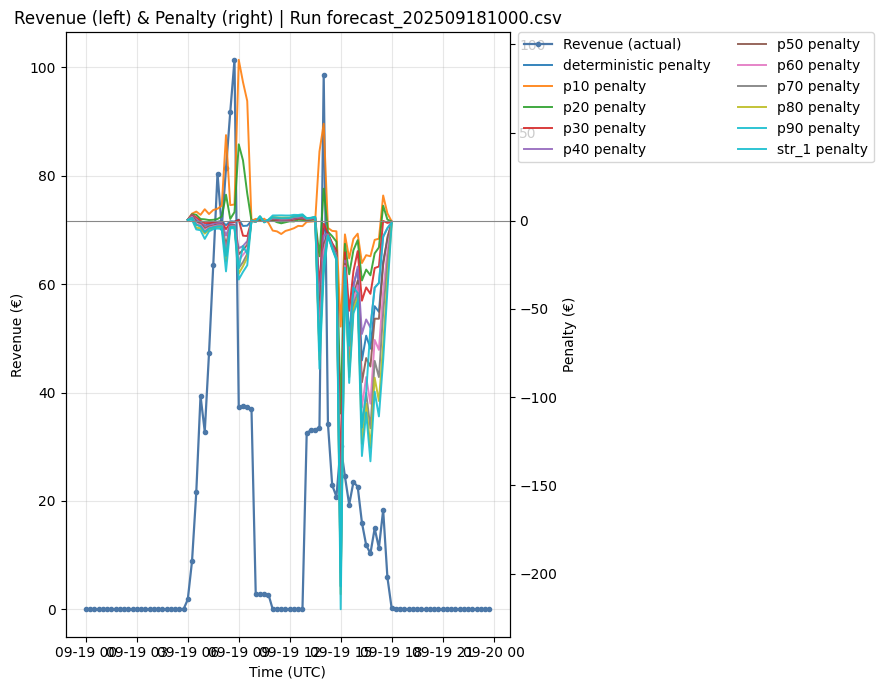

Run forecast_202509191000.csv: deterministic total_net_EUR = 492.02 €, str_1 = 705.32 €, Δ = 43.35%


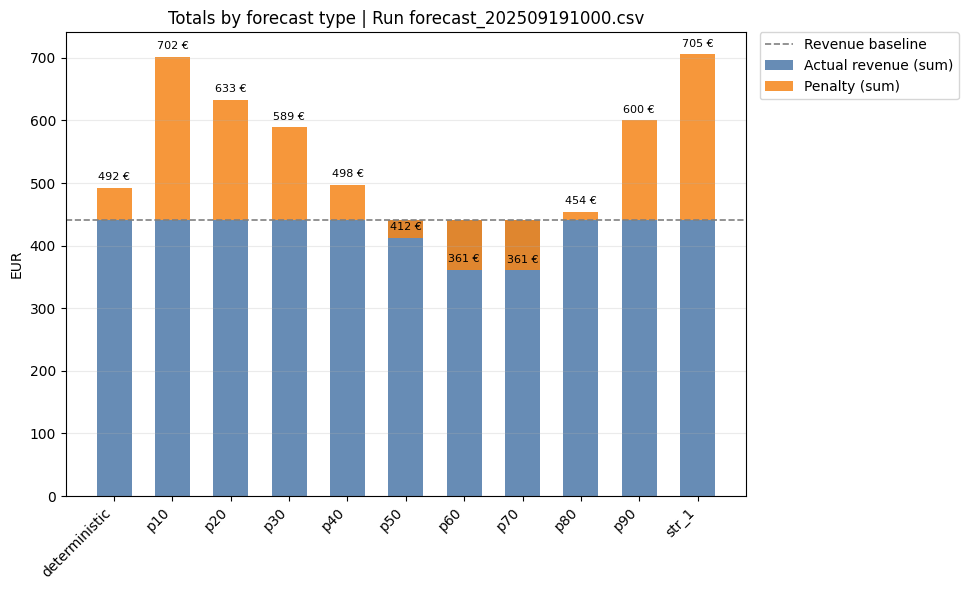

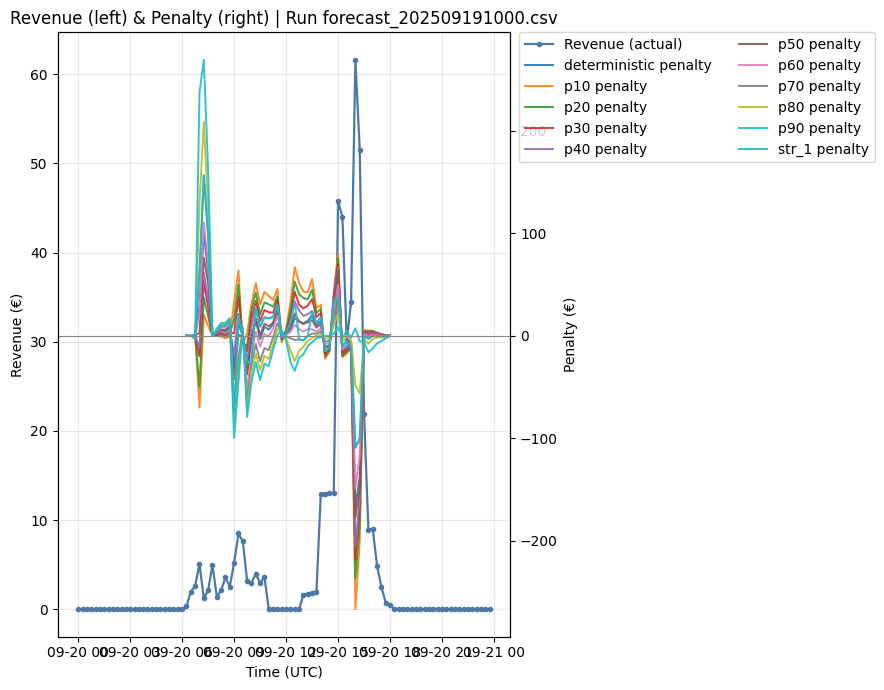

Run forecast_202509201000.csv: deterministic total_net_EUR = 131.20 €, str_1 = 196.33 €, Δ = 49.64%


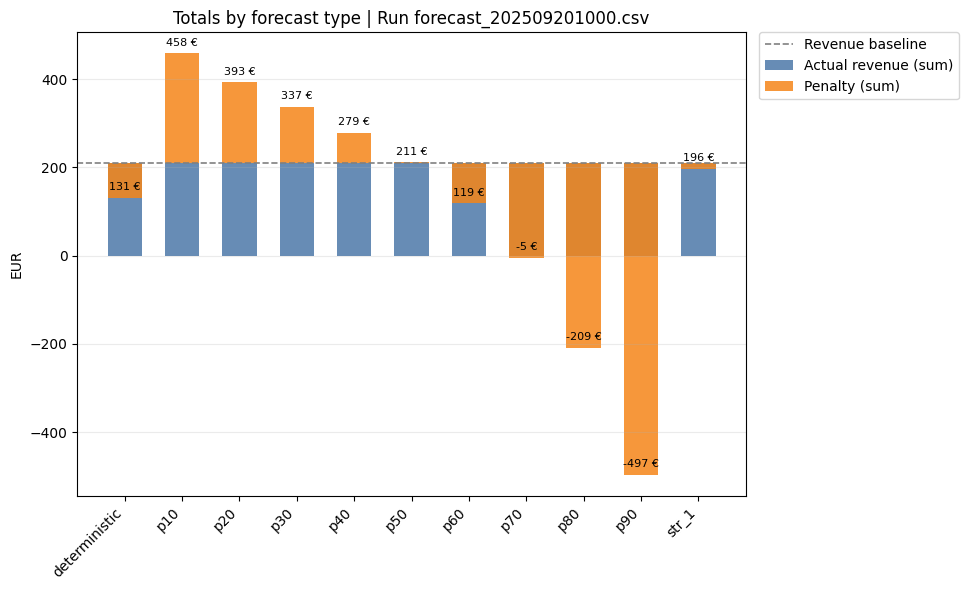

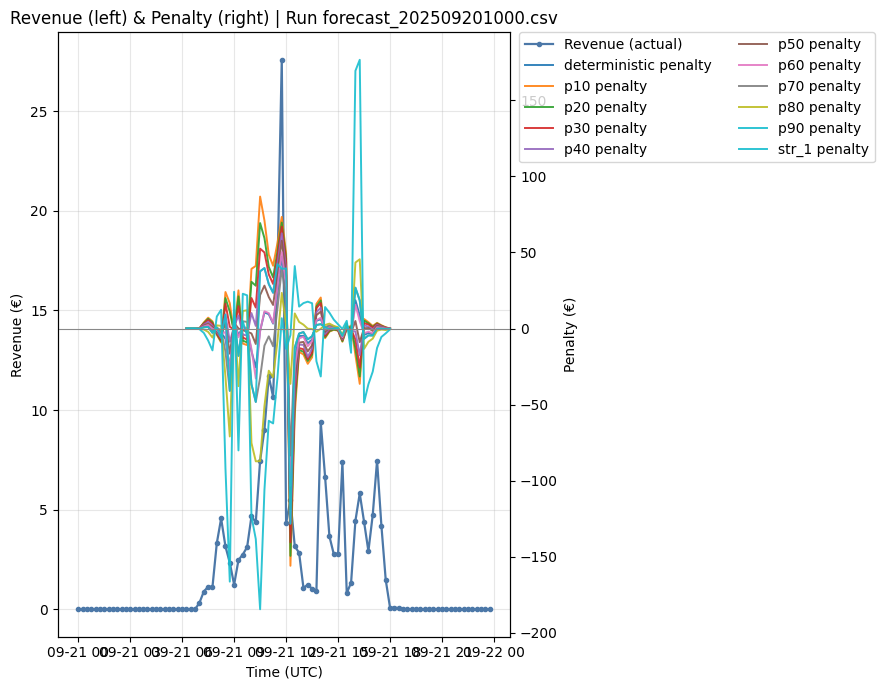

Run forecast_202509211000.csv: deterministic total_net_EUR = -1,355.13 €, str_1 = -1,219.71 €, Δ = 9.99%


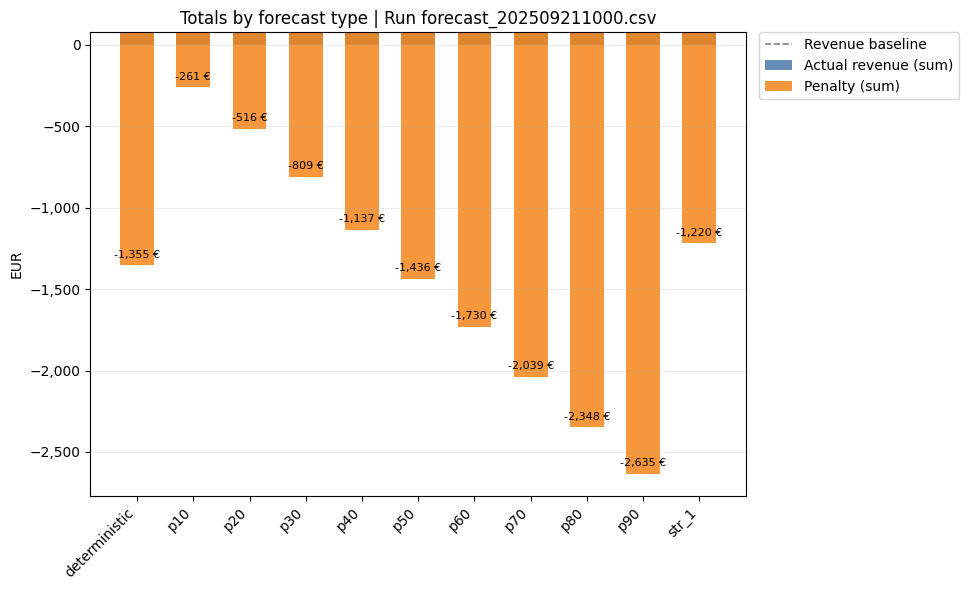

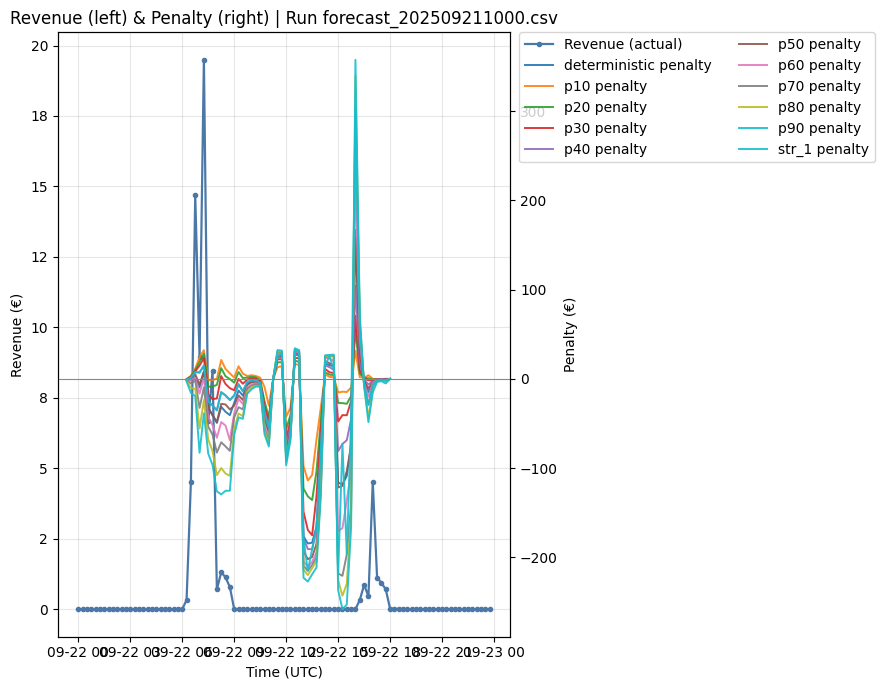

Run forecast_202509221000.csv: deterministic total_net_EUR = 357.12 €, str_1 = 920.72 €, Δ = 157.81%


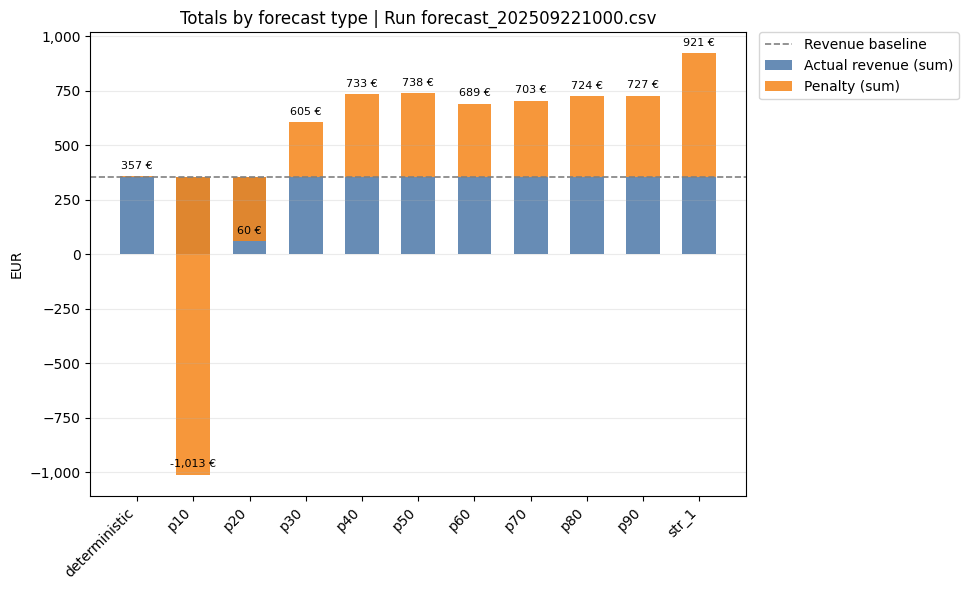

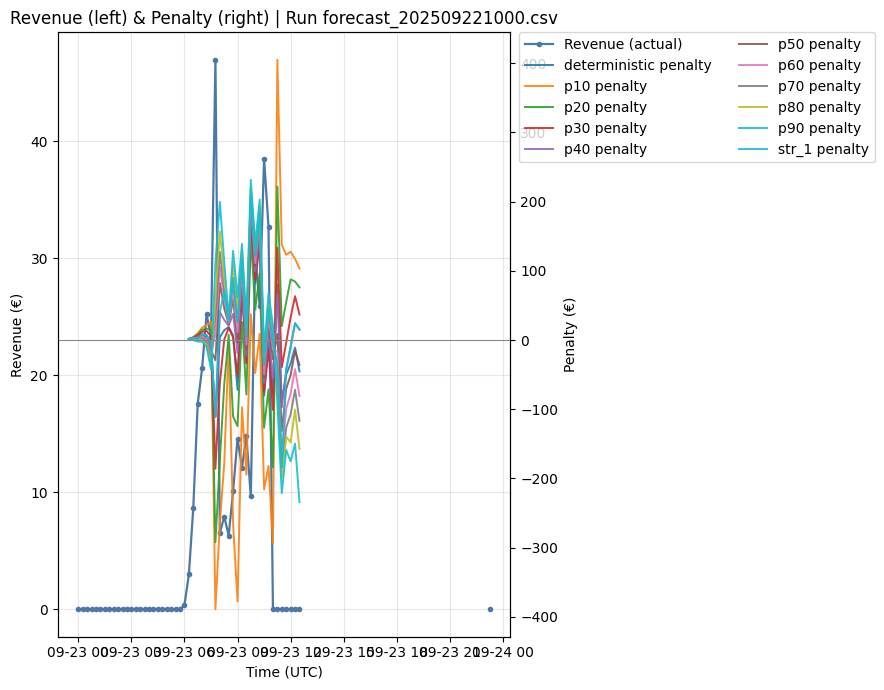

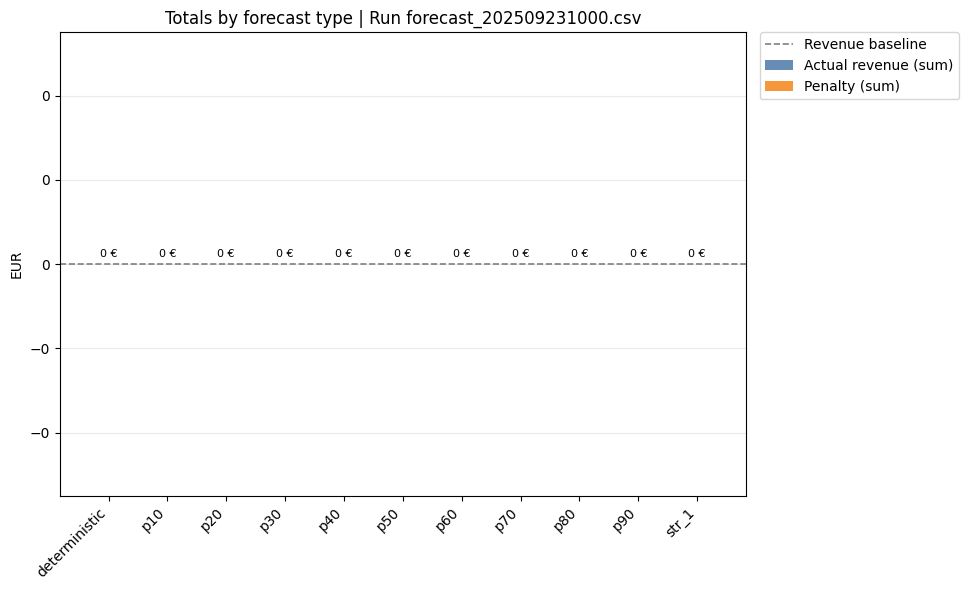

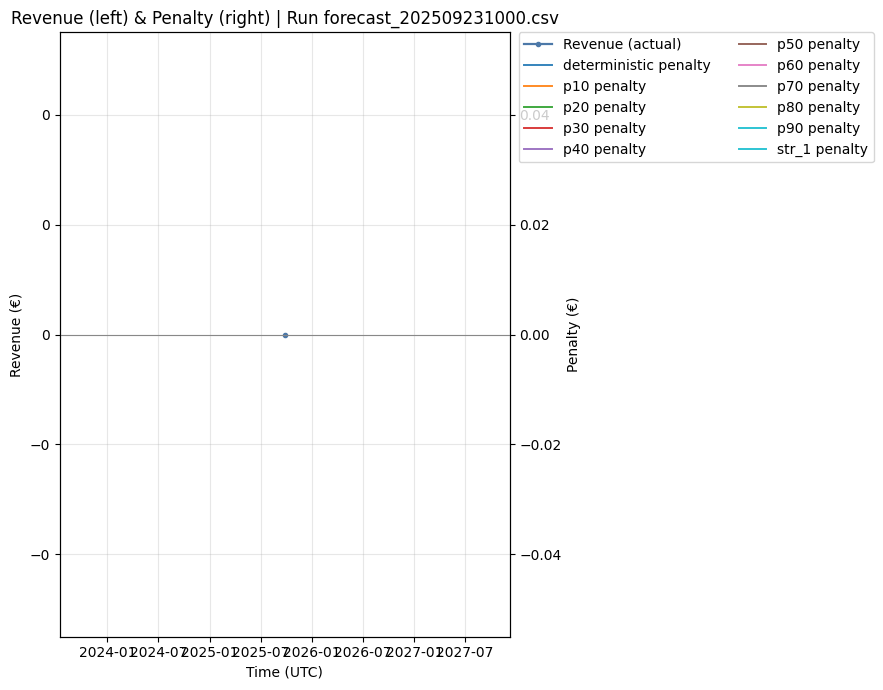

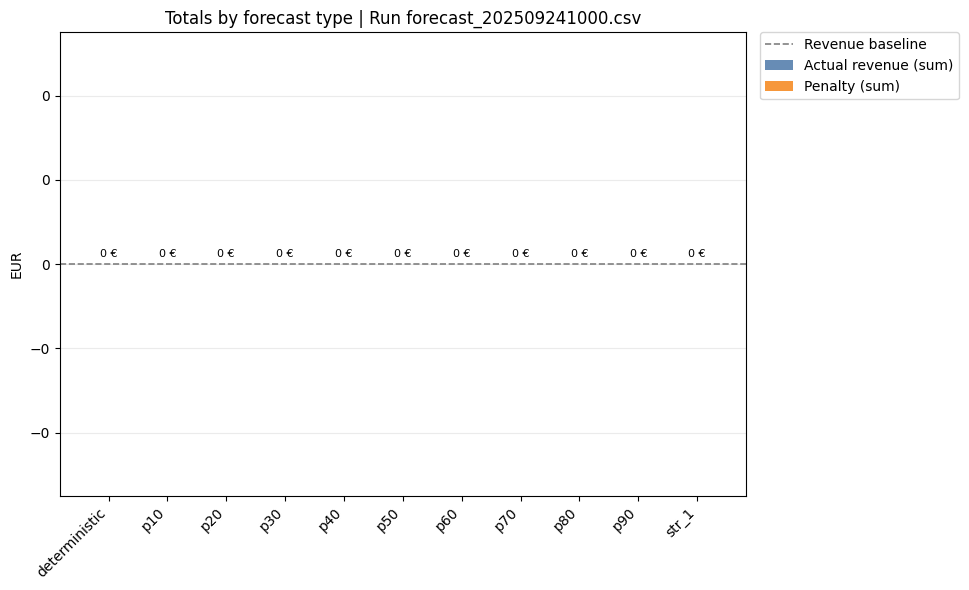

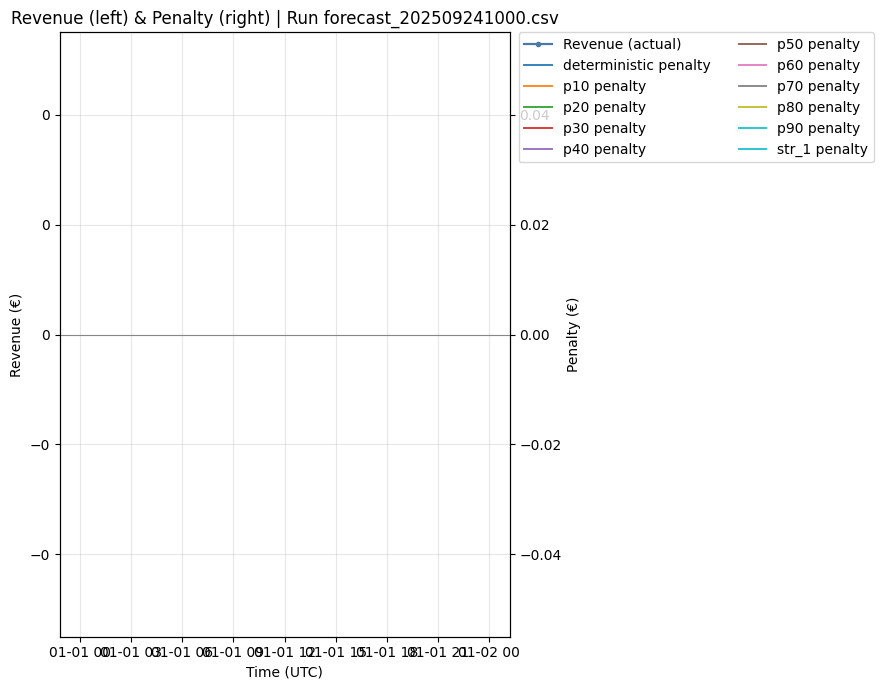

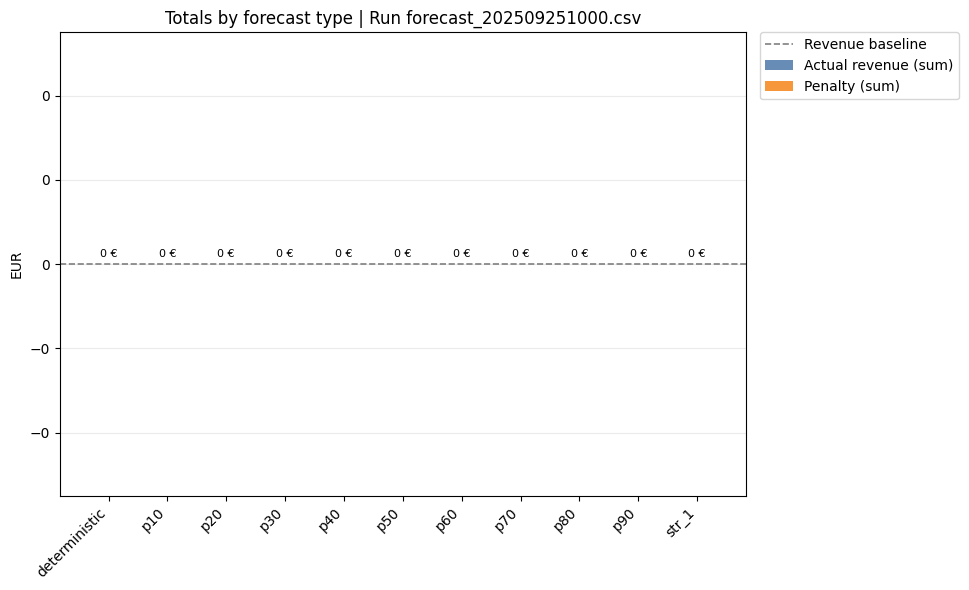

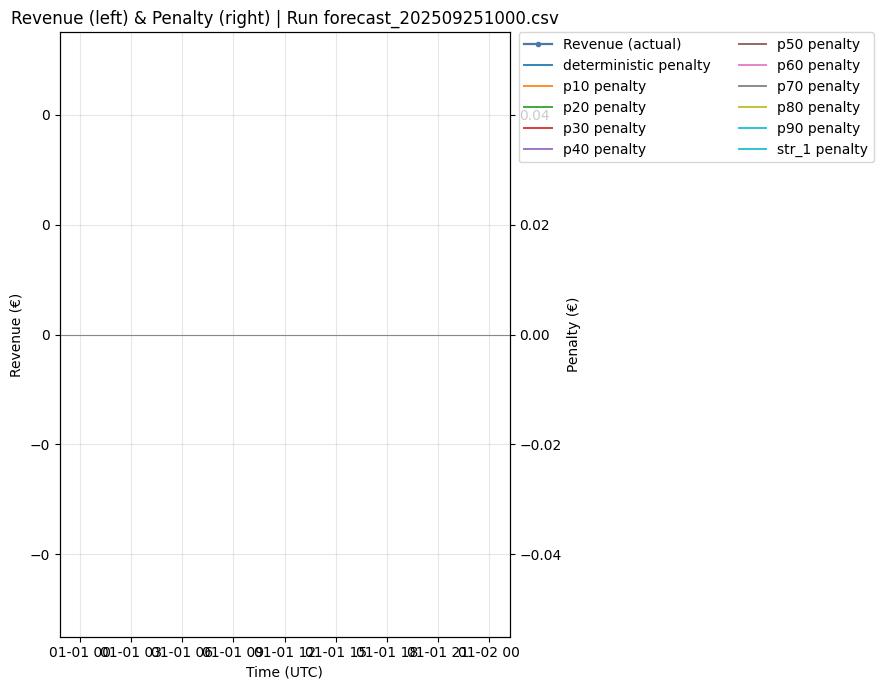

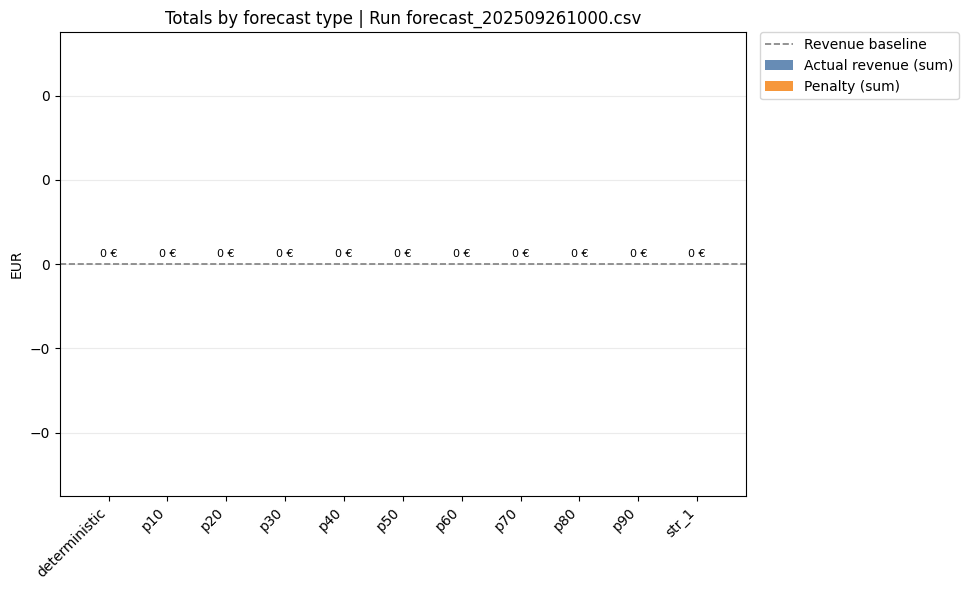

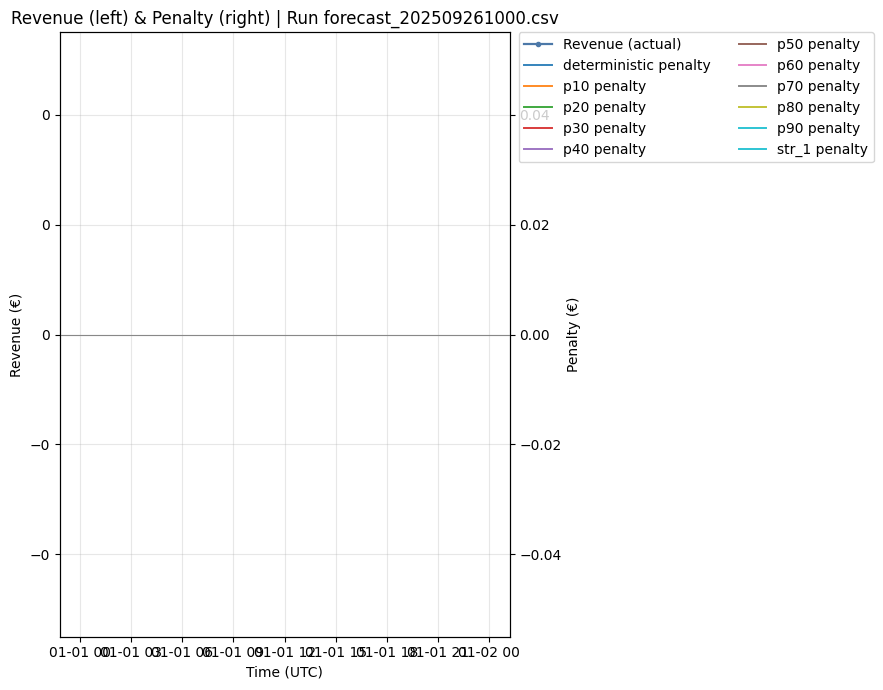

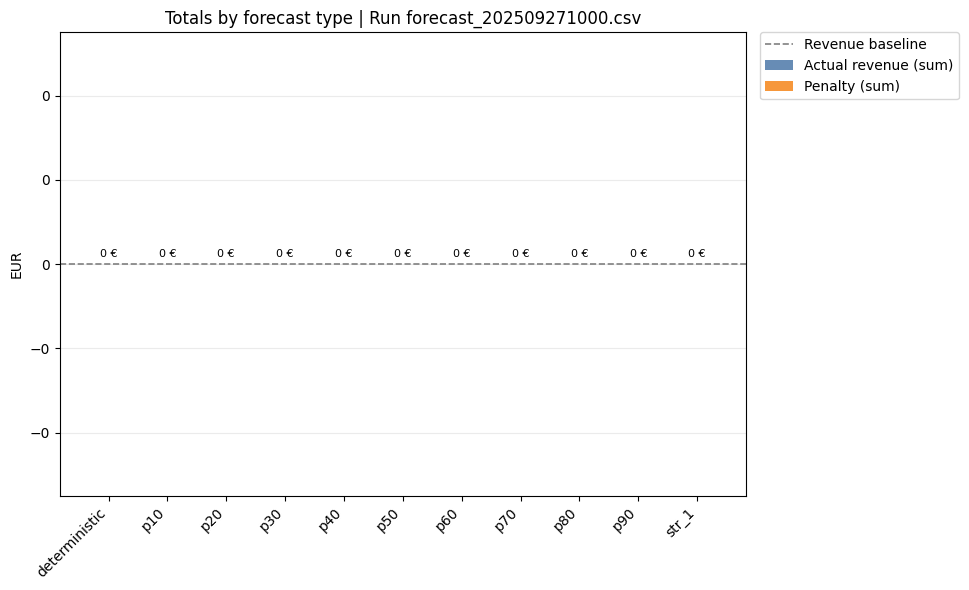

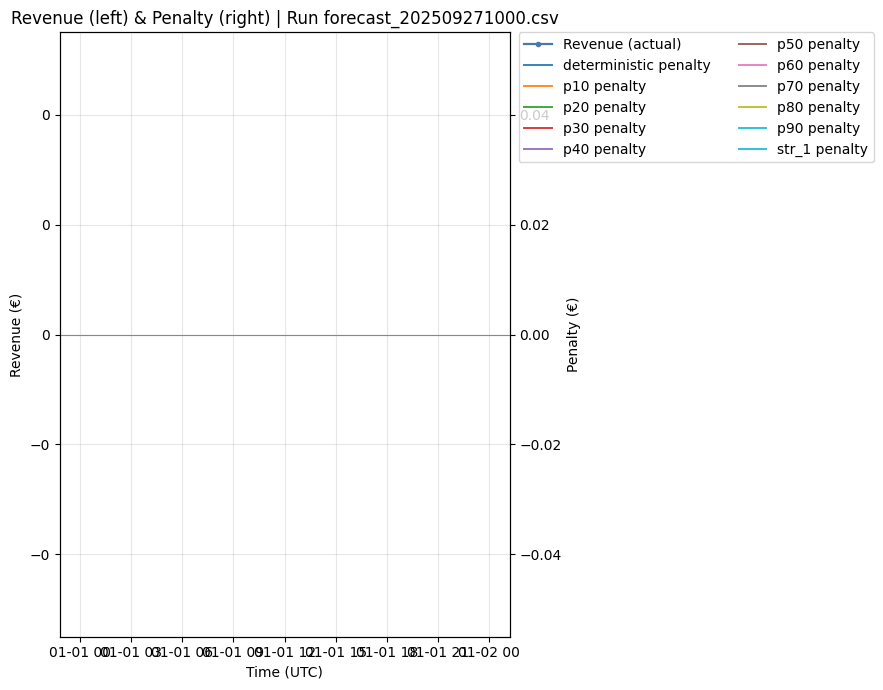

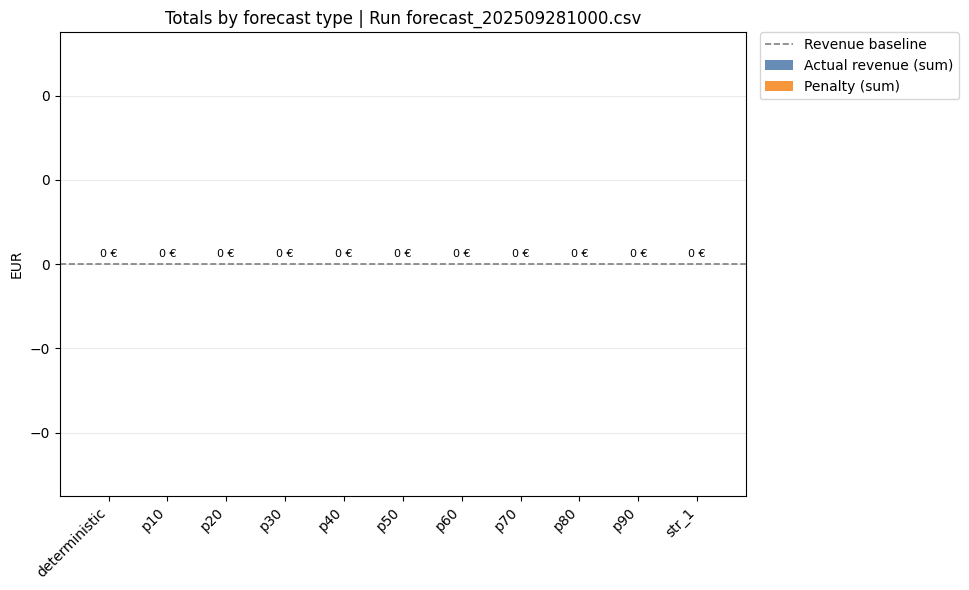

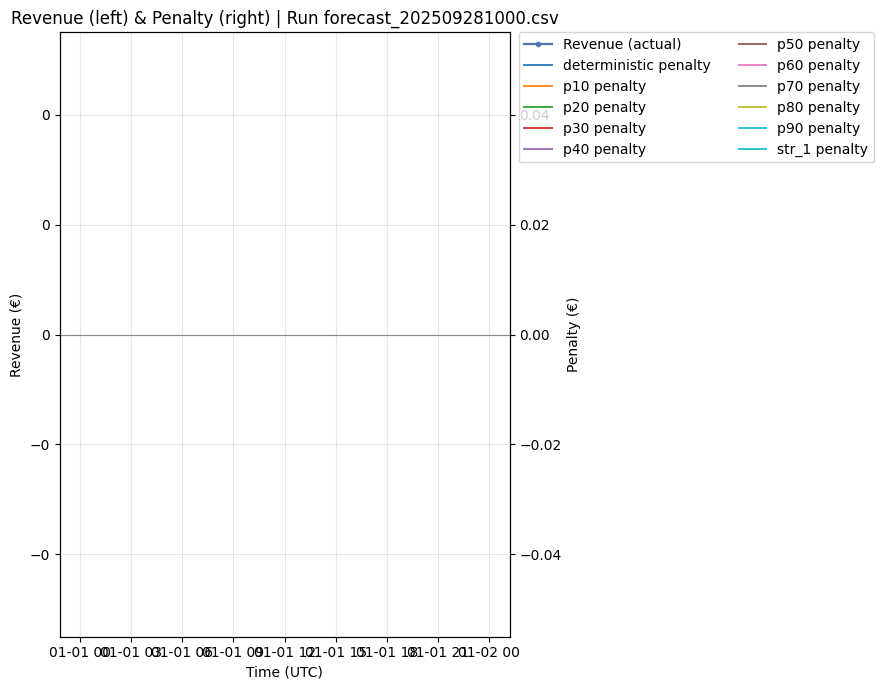

Run forecast_202509291000.csv: deterministic total_net_EUR = 293.38 €, str_1 = 234.67 €, Δ = -20.01%


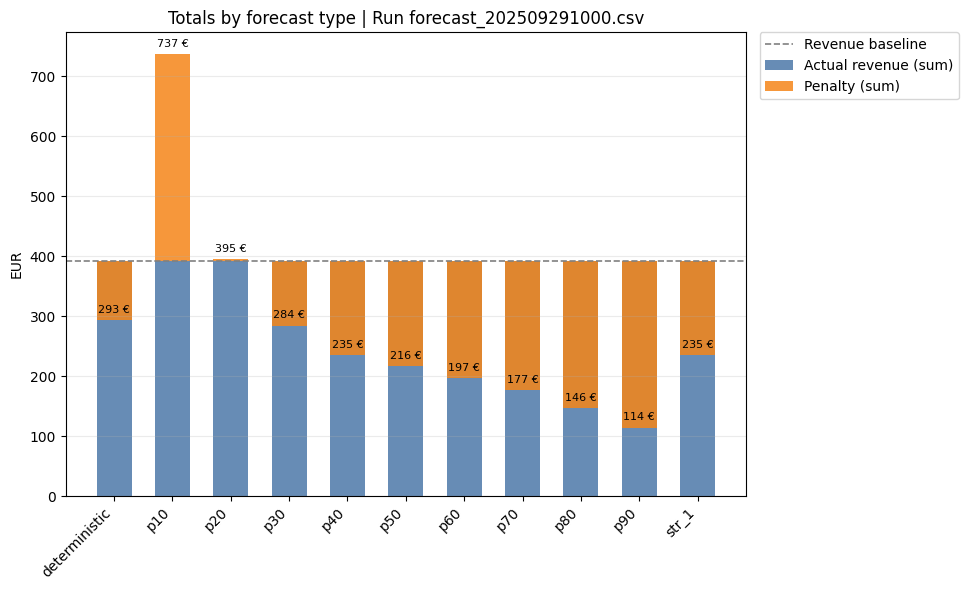

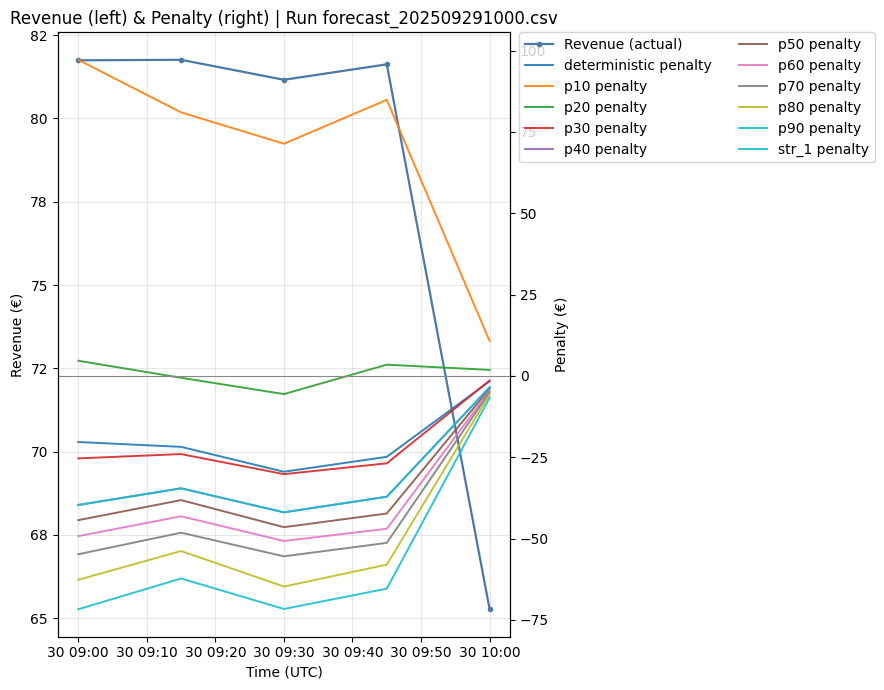

In [64]:
# ---- Graph generation across runs ----
# Adjust these parameters as needed
SELECTED_TYPES = ["deterministic", "p10", "p20", "p30", "p40", "p50", "p60", "p70", "p80", "p90", "str_1"]
START_TS = None   # e.g., "2025-09-07 00:00:00+00:00" or None
END_TS = None     # e.g., "2025-09-08 23:00:00+00:00" or None
RUNS_TO_PLOT = ["ALL"]  # use ["ALL"] for cumulative + every run; otherwise list forecast filenames
MAX_RUNS = None           # set to an integer to limit number of per-run plots

if combined_ledger.empty:
    print("combined_ledger is empty — run the build cell first.")
else:
    unique_runs = sorted(combined_ledger["forecast_file"].unique())

    if RUNS_TO_PLOT is None:
        runs_iter = []
        plot_all = False
    else:
        plot_all = "ALL" in RUNS_TO_PLOT or len(RUNS_TO_PLOT) == 0
        runs_iter = unique_runs if plot_all else [run for run in RUNS_TO_PLOT if run in unique_runs]

    if plot_all:
        plot_ledger_subset(combined_ledger, "2025-09-01 to 2025-09-30 ", start_ts=START_TS, end_ts=END_TS,
                           selected_types=SELECTED_TYPES, aggregate_runs=True)
    if MAX_RUNS is not None:
        runs_iter = runs_iter[:MAX_RUNS]

    for run_name in runs_iter:
        plot_ledger_subset(combined_ledger[combined_ledger["forecast_file"] == run_name],
                           f"Run {run_name}",
                           start_ts=START_TS,
                           end_ts=END_TS,
                           selected_types=SELECTED_TYPES,
                           aggregate_runs=False)


In [65]:
import matplotlib.ticker as mtick

def _ensure_utc(ts):
    if ts is None:
        return None
    t = pd.Timestamp(ts)
    return t.tz_localize("UTC") if t.tzinfo is None else t.tz_convert("UTC")


def plot_ledger_subset(ledger_subset: pd.DataFrame,
                       label: str,
                       start_ts=None,
                       end_ts=None,
                       selected_types=None,
                       aggregate_runs: bool = True) -> None:
    """Render stacked-bar + time-series plots for a ledger slice."""
    if ledger_subset.empty:
        print(f"{label}: no data available.")
        return

    data = ledger_subset.copy()
    start_ts = _ensure_utc(start_ts)
    end_ts = _ensure_utc(end_ts)
    if start_ts is not None:
        data = data[data["target_time"] >= start_ts]
    if end_ts is not None:
        data = data[data["target_time"] <= end_ts]
    if data.empty:
        print(f"{label}: no rows within the chosen time window.")
        return

    if selected_types:
        selected_types = [ft for ft in selected_types if ft in data["forecast_type"].unique()]
        if not selected_types:
            print(f"{label}: none of the requested forecast types are present.")
            return
        data = data[data["forecast_type"].isin(selected_types)]
    else:
        selected_types = sorted(data["forecast_type"].unique())

    data = data.sort_values(["forecast_type", "target_time"]).reset_index(drop=True)

    # Aggregate totals per forecast type
    agg = (
        data.groupby("forecast_type", as_index=False)
            .agg(
                total_revenue_EUR=("revenue_EUR", "sum"),
                total_penalty_EUR=("penalty_EUR", "sum"),
                total_net_EUR=("net_revenue_EUR", "sum"),
                n_15min=("net_revenue_EUR", "size"),
            )
    )

    # Baseline actual revenue (unique sum across target_time, not duplicated per forecast type)
    rev_unique = (
        data[["target_time", "revenue_EUR"]]
        .drop_duplicates(subset=["target_time"], keep="last")
        .sort_values("target_time")
    )
    rev_baseline_total = float(rev_unique["revenue_EUR"].sum()) if not rev_unique.empty else np.nan

    # Delta vs deterministic for context
    det_net = np.nan
    if "deterministic" in agg["forecast_type"].values:
        det_net = float(agg.loc[agg["forecast_type"] == "deterministic", "total_net_EUR"].iloc[0])
    agg["pct_vs_det"] = np.nan
    if np.isfinite(det_net) and not np.isclose(det_net, 0.0):
        agg["pct_vs_det"] = (agg["total_net_EUR"] - det_net) / abs(det_net) * 100.0

    if ("str_1" in agg["forecast_type"].values) and np.isfinite(det_net) and det_net != 0:
        str_net = float(agg.loc[agg["forecast_type"] == "str_1", "total_net_EUR"].iloc[0])
        pct = float(agg.loc[agg["forecast_type"] == "str_1", "pct_vs_det"].iloc[0])
        print(f"{label}: deterministic total_net_EUR = {det_net:,.2f} €, str_1 = {str_net:,.2f} €, Δ = {pct:.2f}%")

    # ----- Figure 1: Stacked bars (Revenue + Penalty) with revenue baseline line and label -----
    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(agg))
    width = 0.6

    # Stacked bars
    ax.bar(
        x,
        agg["total_revenue_EUR"].to_numpy(),
        width=width,
        label="Actual revenue (sum)",
        color="#4C78A8",
        alpha=0.85,
    )
    ax.bar(
        x,
        agg["total_penalty_EUR"].to_numpy(),
        width=width,
        bottom=agg["total_revenue_EUR"].to_numpy(),
        label="Penalty (sum)",
        color="#F58518",
        alpha=0.85,
    )

    # Baseline line + non-overlapping label (no markers)
    if np.isfinite(rev_baseline_total):
        ax.axhline(
            rev_baseline_total,
            color="gray",
            linestyle="--",
            linewidth=1.2,
            label="Revenue baseline",
        )
        ax.annotate(
            f"Baseline: {rev_baseline_total:,.0f} €",
            xy=(0.98, rev_baseline_total),
            xycoords=("axes fraction", "data"),
            ha="right",
            va="bottom",
            fontsize=9,
            color="gray",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.65),
            zorder=4,
        )

    # Axis formatting and labels
    ax.set_xticks(x)
    ax.set_xticklabels(agg["forecast_type"], rotation=45, ha="right")
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.set_ylabel("EUR")
    ax.set_title(f"Totals by forecast type | {label}")
    ax.grid(axis="y", alpha=0.25)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Annotate net totals
    net_vals = agg["total_revenue_EUR"].to_numpy() + agg["total_penalty_EUR"].to_numpy()
    for xi, yi in zip(x, net_vals):
        if np.isfinite(yi):
            ax.annotate(
                f"{yi:,.0f} €",
                xy=(xi, yi),
                xycoords="data",
                textcoords="offset points",
                xytext=(0, 4),
                ha="center",
                va="bottom",
                fontsize=7,
            )

    # Autoscale and margins to prevent cramped labels
    ax.margins(y=0.10)
    ax.relim()
    ax.autoscale_view()

    ax.legend()
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

    # ----- Figure 2: Time-series: Actual revenue (+ markers) and penalties per forecast type -----
    fig, ax1 = plt.subplots(figsize=(11, 4))
    if aggregate_runs:
        rev_series = data.groupby("target_time", as_index=False)["revenue_EUR"].sum()
    else:
        rev_series = (
            data[["target_time", "revenue_EUR"]]
            .drop_duplicates(subset=["target_time"], keep="last")
            .sort_values("target_time")
        )

    ax1.plot(
        rev_series["target_time"],
        rev_series["revenue_EUR"],
        label="Revenue (actual)",
        color="#4C78A8",
        linewidth=1.6,
        marker="o",
        markersize=3,
    )
    ax1.set_xlabel("Time (UTC)")
    ax1.set_ylabel("Revenue (€)")
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax1.tick_params(axis="both", labelsize=9)

    ax2 = ax1.twinx()
    cmap = plt.get_cmap("tab10", len(selected_types))
    for idx, ft in enumerate(selected_types):
        if aggregate_runs:
            s = (
                data.loc[data["forecast_type"] == ft]
                .groupby("target_time", as_index=False)["penalty_EUR"]
                .sum()
            )
        else:
            s = (
                data.loc[data["forecast_type"] == ft, ["target_time", "penalty_EUR"]]
                .sort_values("target_time")
            )
        ax2.plot(
            s["target_time"],
            s["penalty_EUR"],
            label=f"{ft} penalty",
            color=cmap(idx),
            linewidth=1.4,
            alpha=0.9,
        )

    # Zero line for penalties (can be +/-)
    ax2.axhline(0, color="#888", linewidth=0.8)

    # Autoscale + margins
    ax1.margins(y=0.10); ax1.relim(); ax1.autoscale_view()
    ax2.margins(y=0.10); ax2.relim(); ax2.autoscale_view()

    # Reduce x tick overlap for dates
    fig.autofmt_xdate(rotation=30)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(
        lines1 + lines2,
        labels1 + labels2,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        ncol=2,
        borderaxespad=0.0,
    )
    ax2.set_ylabel("Penalty (€)")
    plt.title(f"Revenue (left) & Penalty (right) | {label}")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

All runs (cumulative): deterministic total_net_EUR = 14,922.81 €, str_1 = 17,295.44 €, Δ = 15.90%


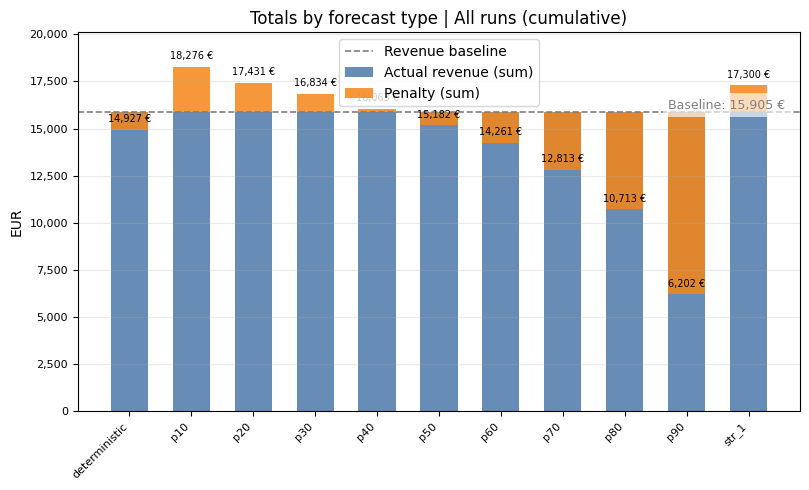

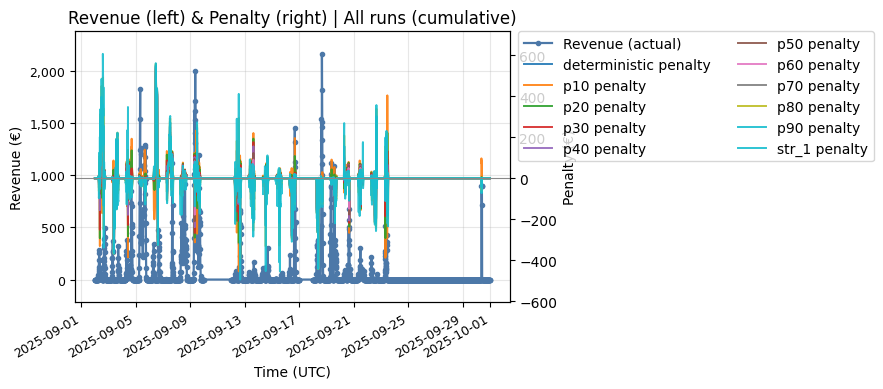

Run forecast_202509011000.csv: deterministic total_net_EUR = 3,715.66 €, str_1 = 5,518.06 €, Δ = 48.51%


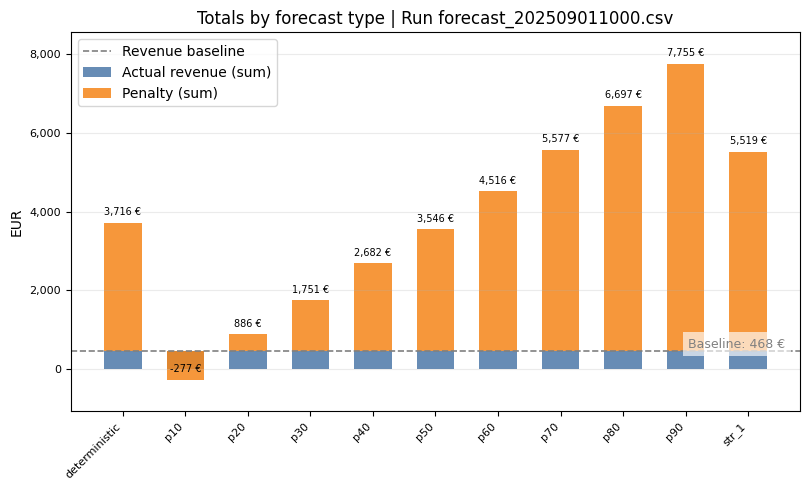

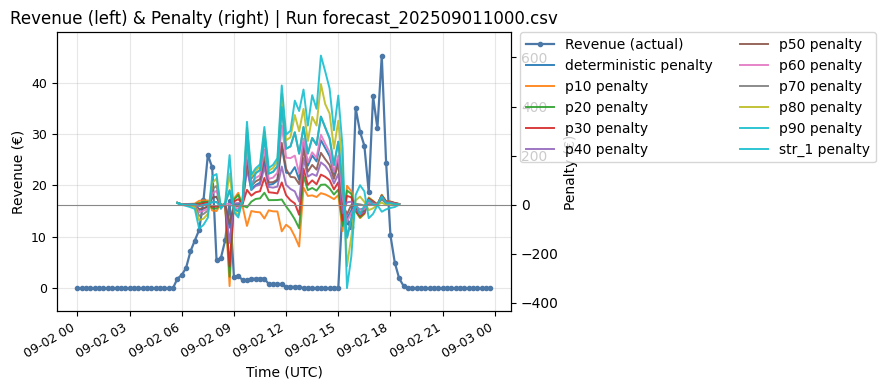

Run forecast_202509021000.csv: deterministic total_net_EUR = -1,011.86 €, str_1 = -966.25 €, Δ = 4.51%


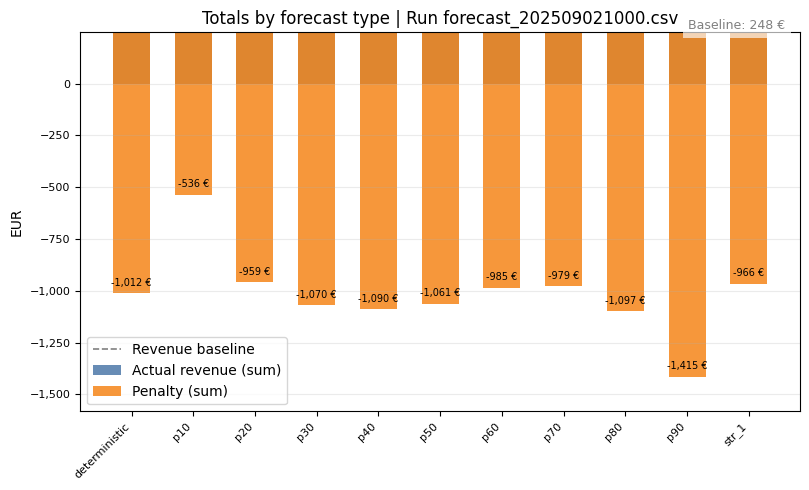

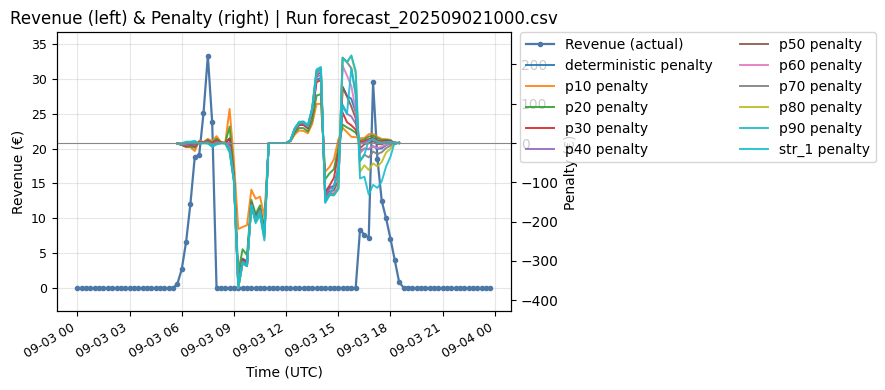

Run forecast_202509031000.csv: deterministic total_net_EUR = 433.81 €, str_1 = 486.68 €, Δ = 12.19%


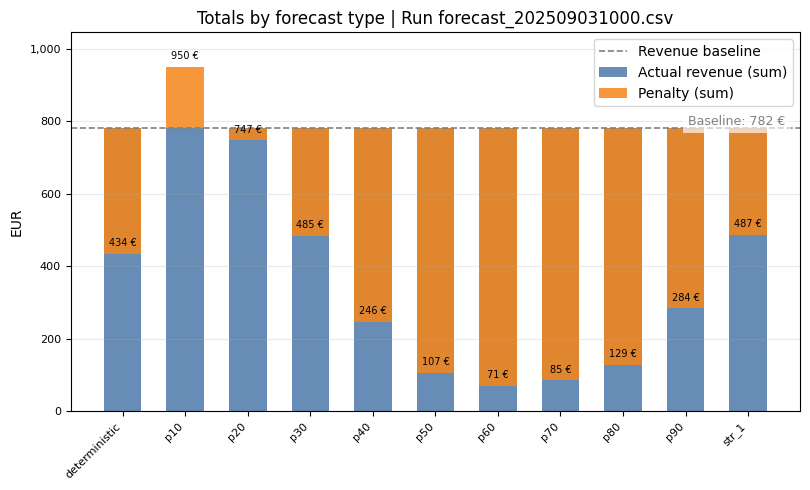

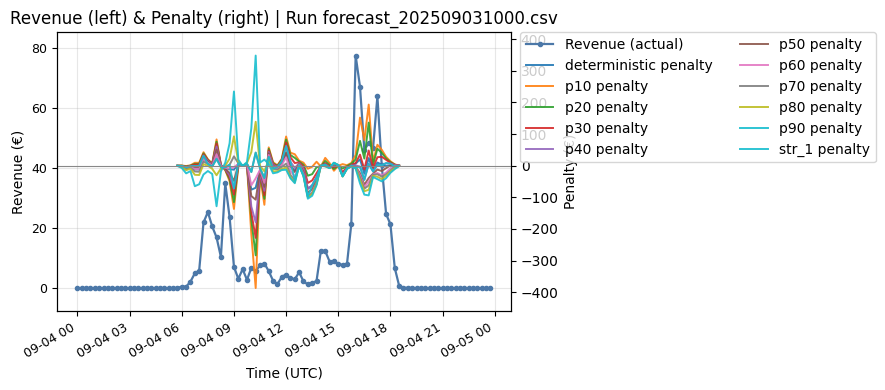

Run forecast_202509041000.csv: deterministic total_net_EUR = 2,905.26 €, str_1 = 2,648.06 €, Δ = -8.85%


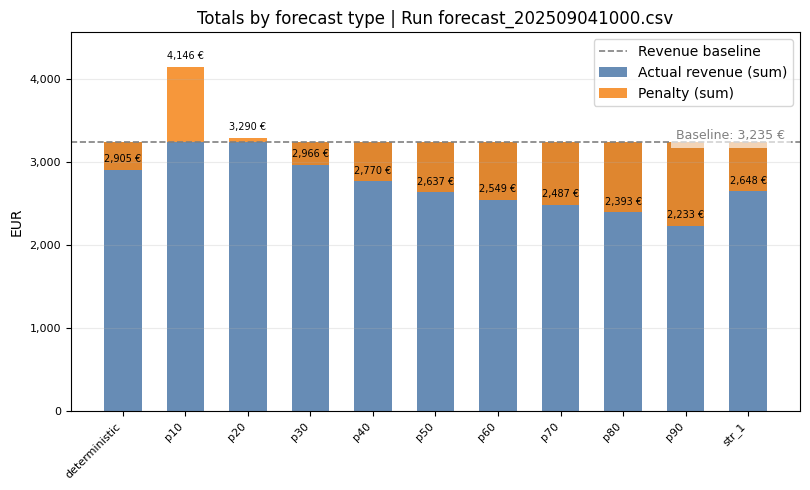

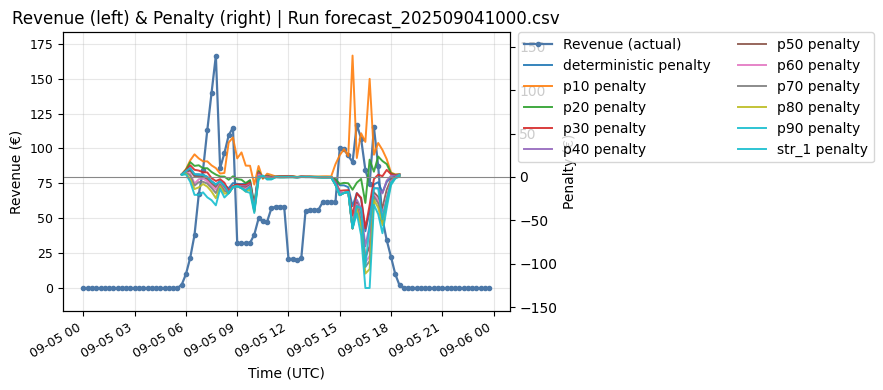

Run forecast_202509051000.csv: deterministic total_net_EUR = 4,931.00 €, str_1 = 5,389.47 €, Δ = 9.30%


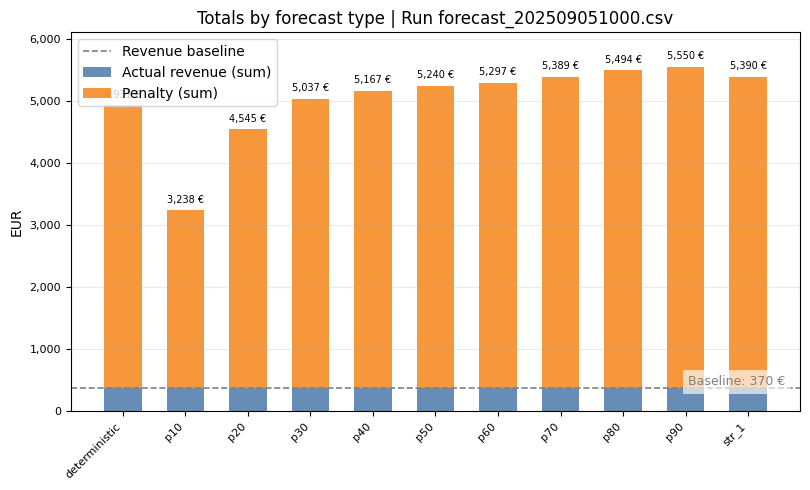

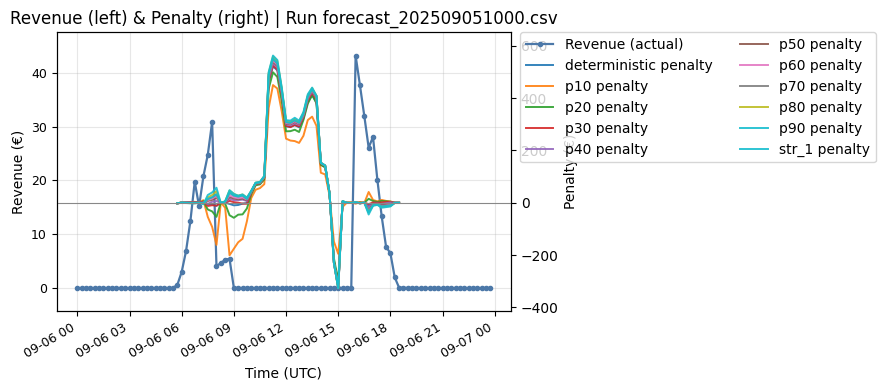

Run forecast_202509061000.csv: deterministic total_net_EUR = 3,101.08 €, str_1 = 3,712.23 €, Δ = 19.71%


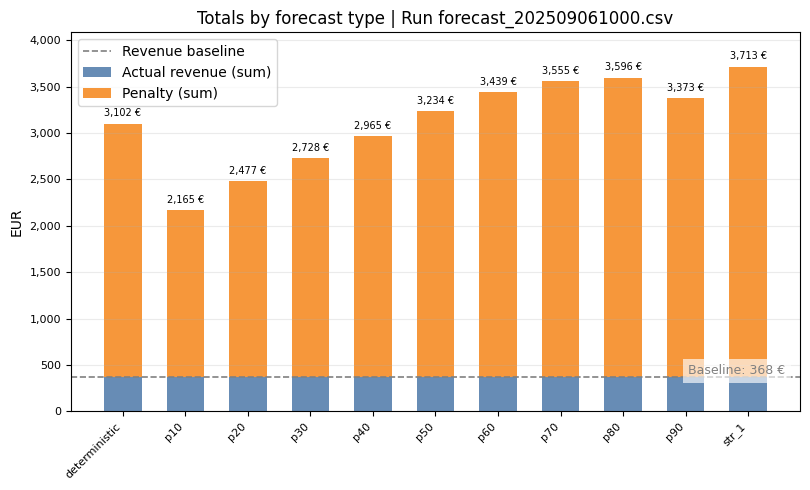

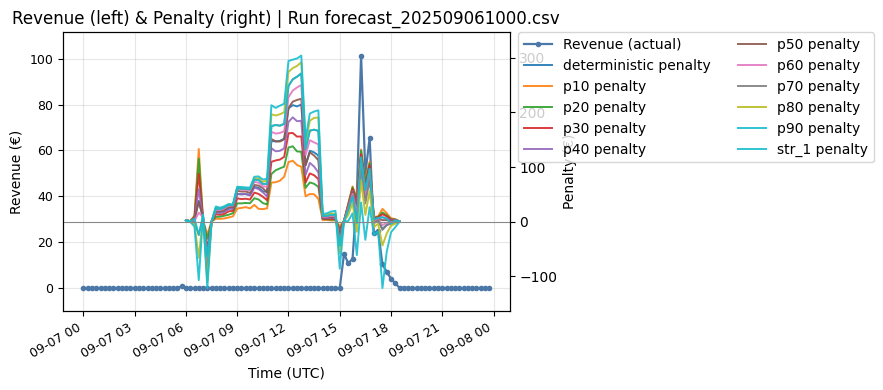

Run forecast_202509071000.csv: deterministic total_net_EUR = 1,070.33 €, str_1 = 960.35 €, Δ = -10.28%


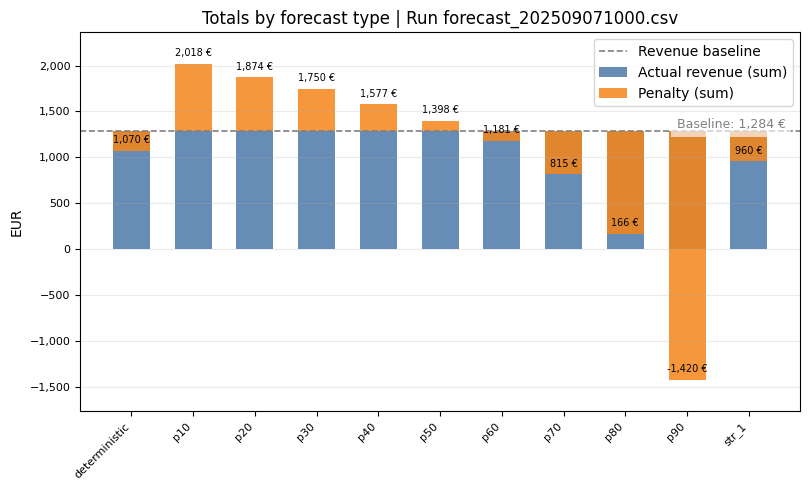

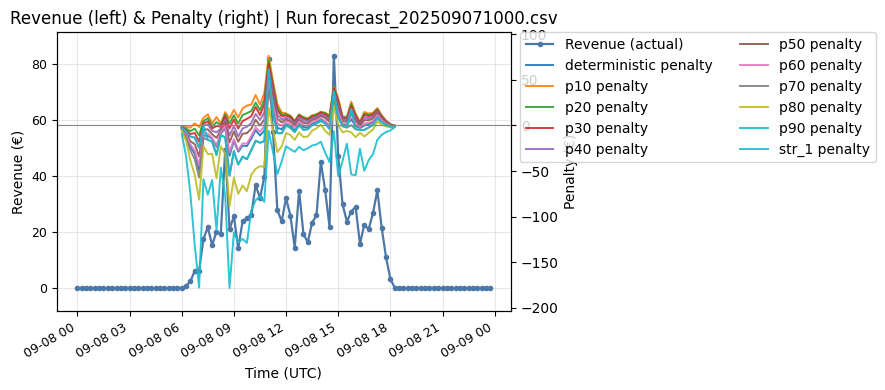

Run forecast_202509081000.csv: deterministic total_net_EUR = 2,766.81 €, str_1 = 2,447.38 €, Δ = -11.55%


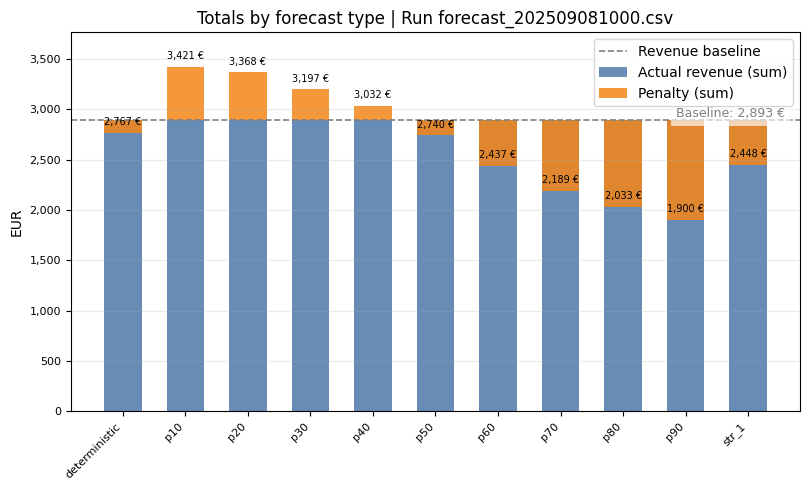

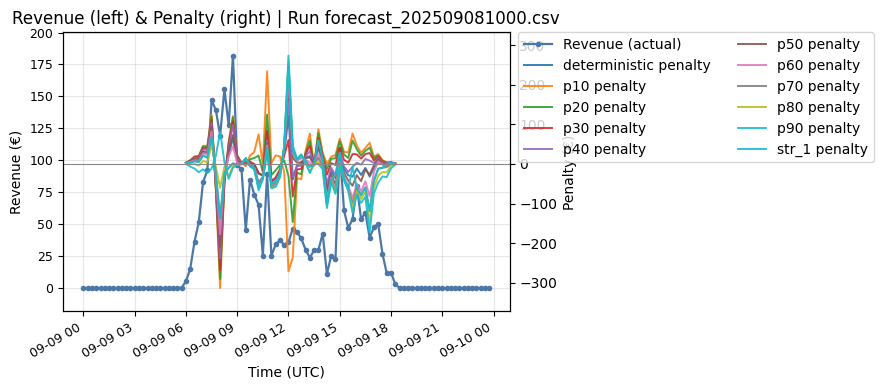

Run forecast_202509111000.csv: deterministic total_net_EUR = 52.41 €, str_1 = -202.68 €, Δ = -486.72%


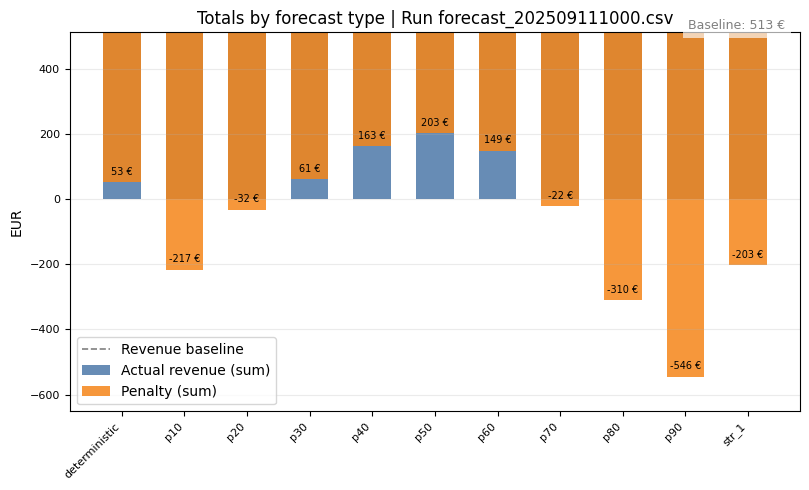

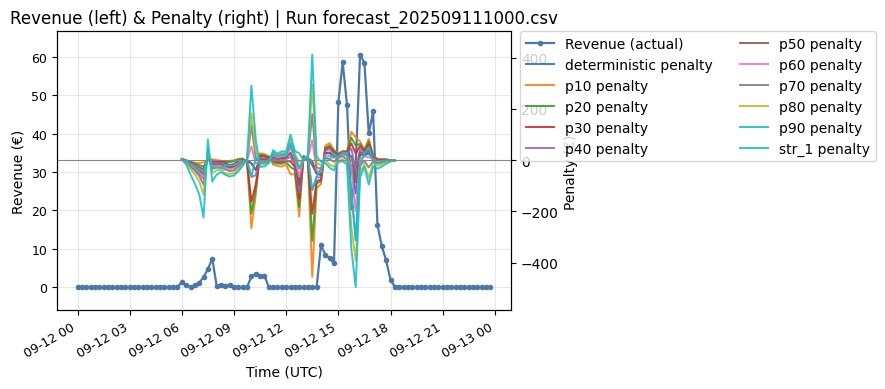

Run forecast_202509121000.csv: deterministic total_net_EUR = -216.69 €, str_1 = -340.43 €, Δ = -57.11%


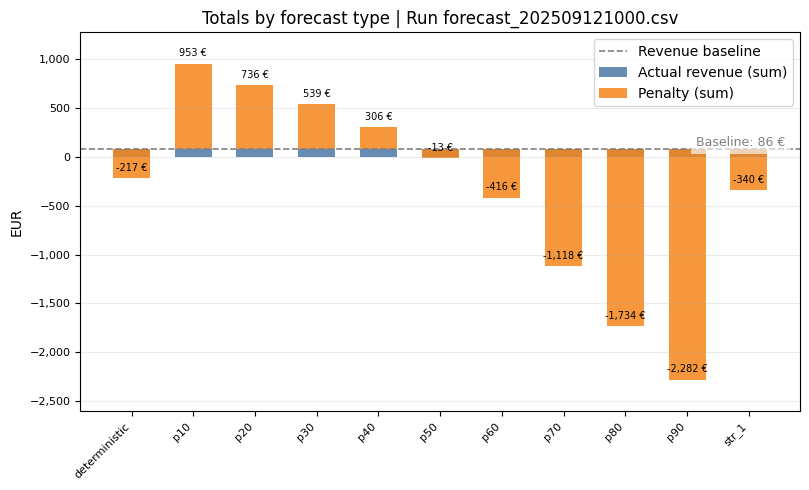

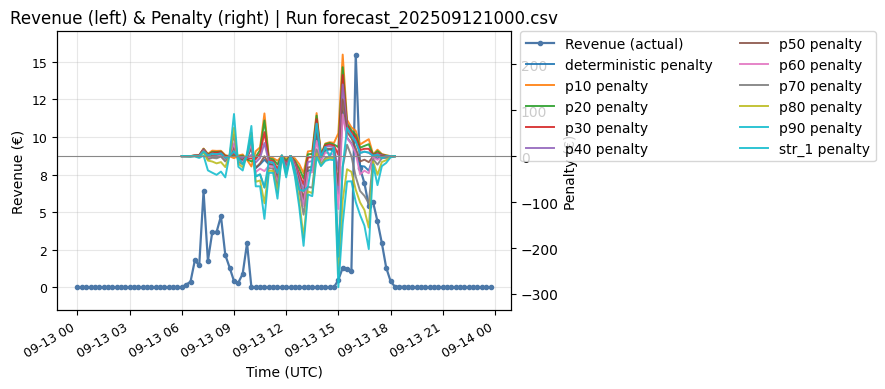

Run forecast_202509131000.csv: deterministic total_net_EUR = -29.37 €, str_1 = 84.98 €, Δ = 389.32%


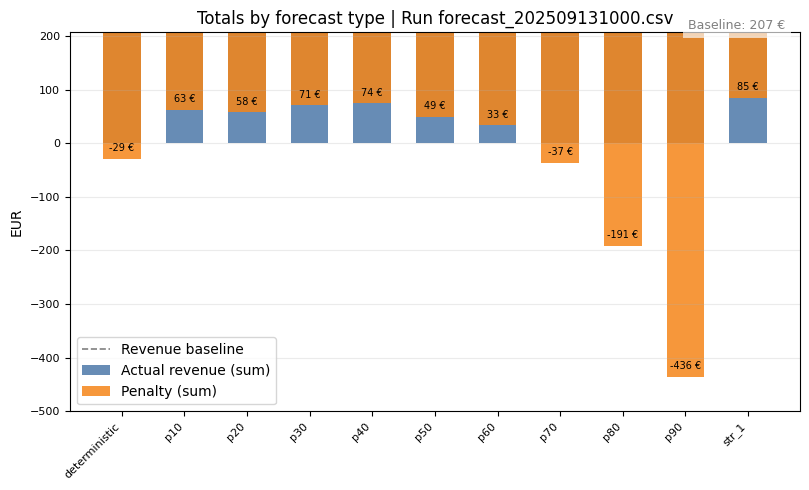

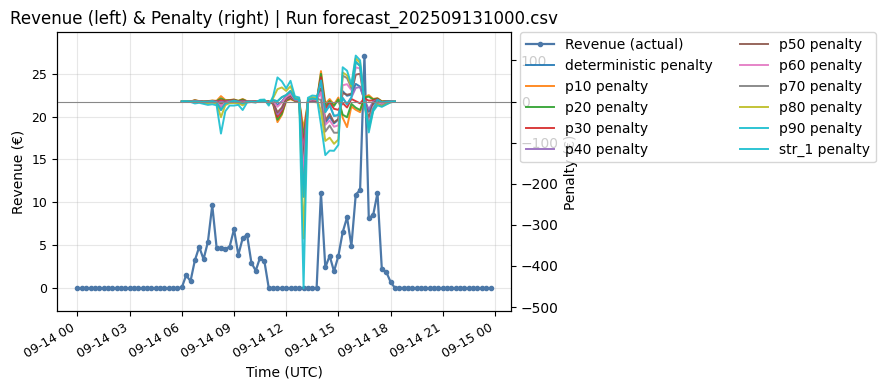

Run forecast_202509141000.csv: deterministic total_net_EUR = -399.27 €, str_1 = -246.45 €, Δ = 38.28%


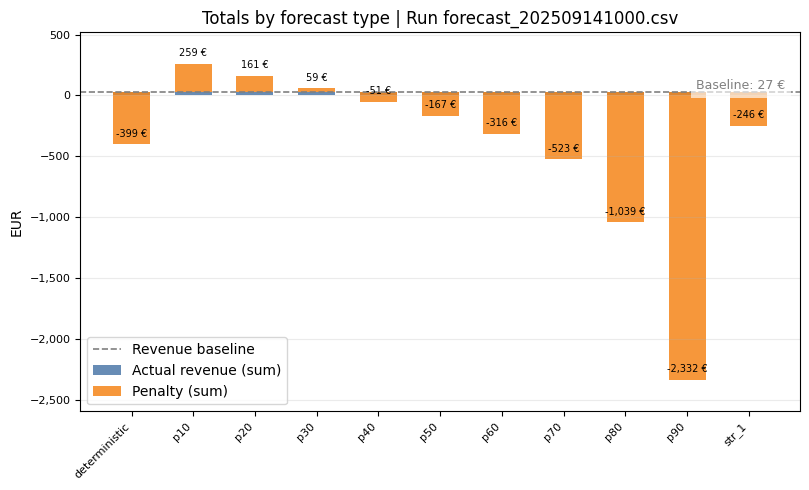

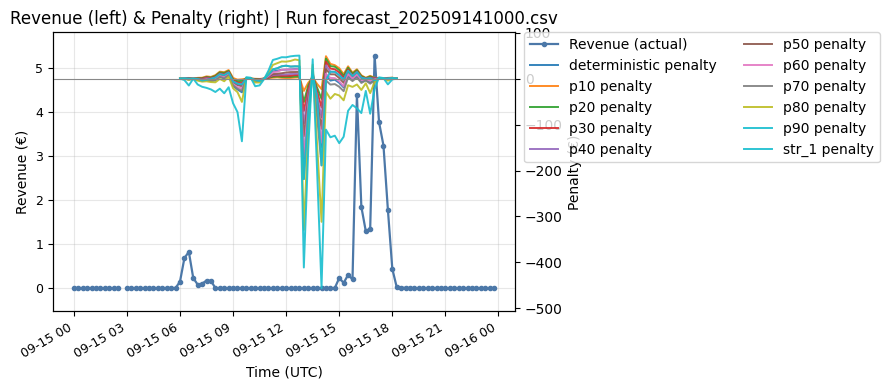

Run forecast_202509151000.csv: deterministic total_net_EUR = -1,003.61 €, str_1 = -1,283.00 €, Δ = -27.84%


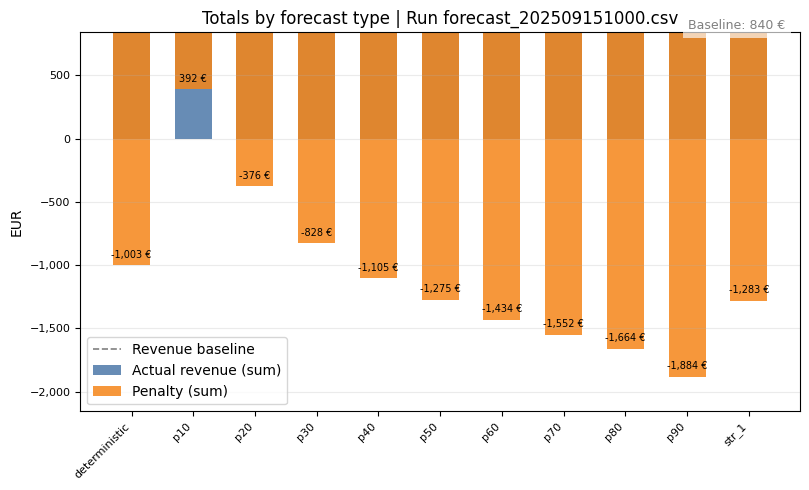

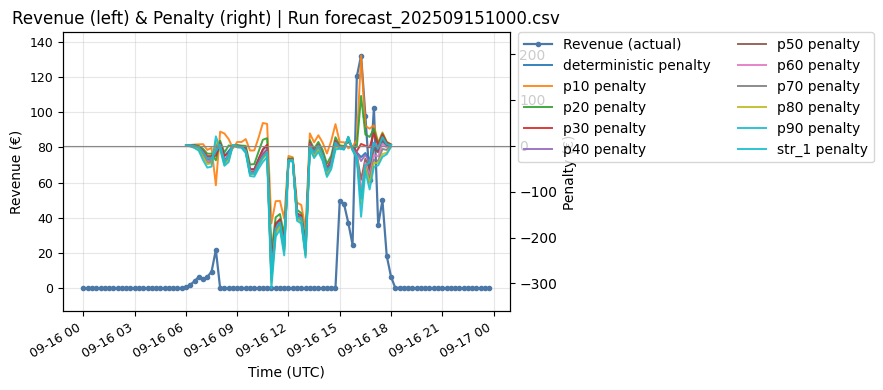

Run forecast_202509171000.csv: deterministic total_net_EUR = -1,867.14 €, str_1 = -2,092.32 €, Δ = -12.06%


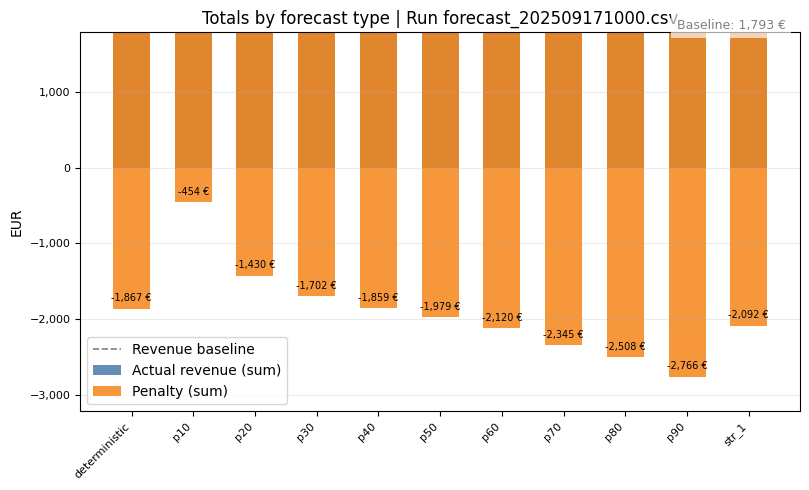

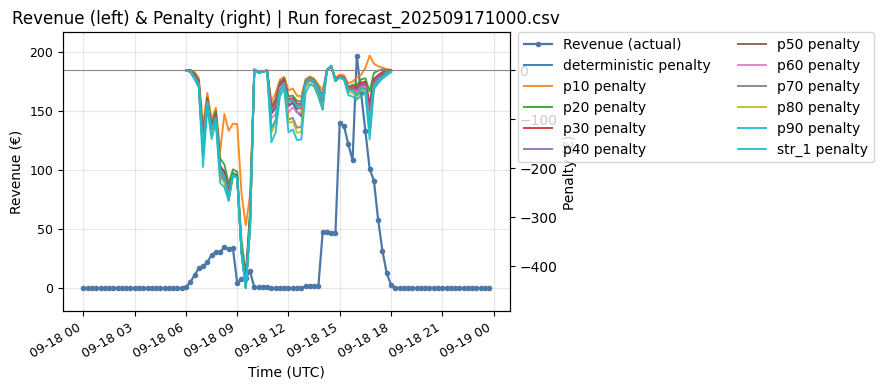

Run forecast_202509181000.csv: deterministic total_net_EUR = 555.79 €, str_1 = 342.01 €, Δ = -38.46%


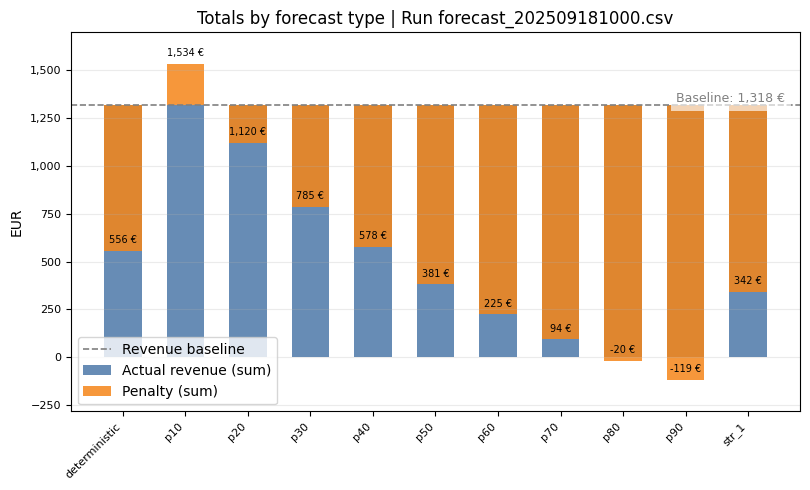

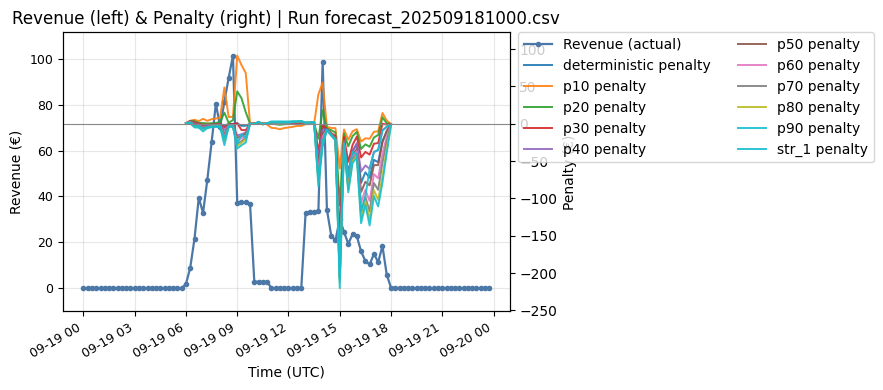

Run forecast_202509191000.csv: deterministic total_net_EUR = 492.02 €, str_1 = 705.32 €, Δ = 43.35%


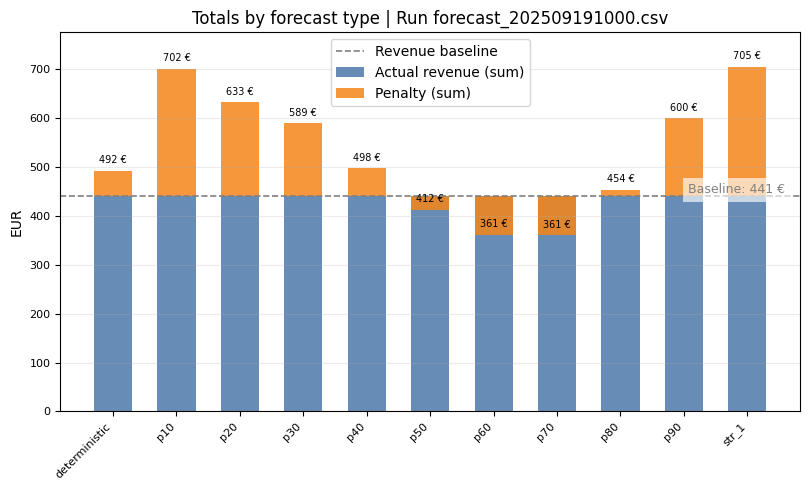

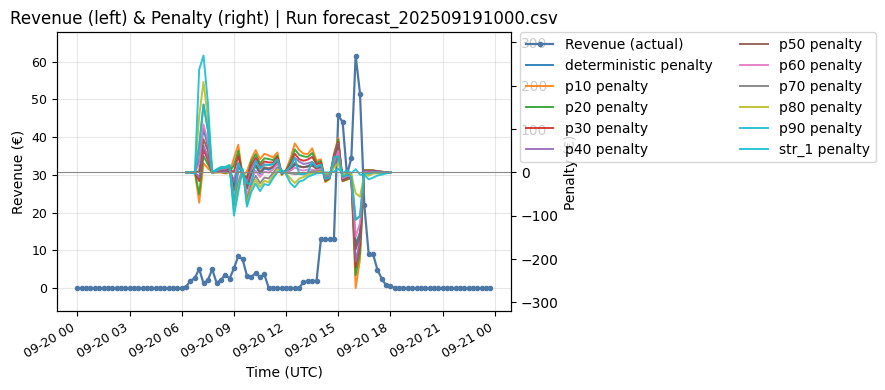

Run forecast_202509201000.csv: deterministic total_net_EUR = 131.20 €, str_1 = 196.33 €, Δ = 49.64%


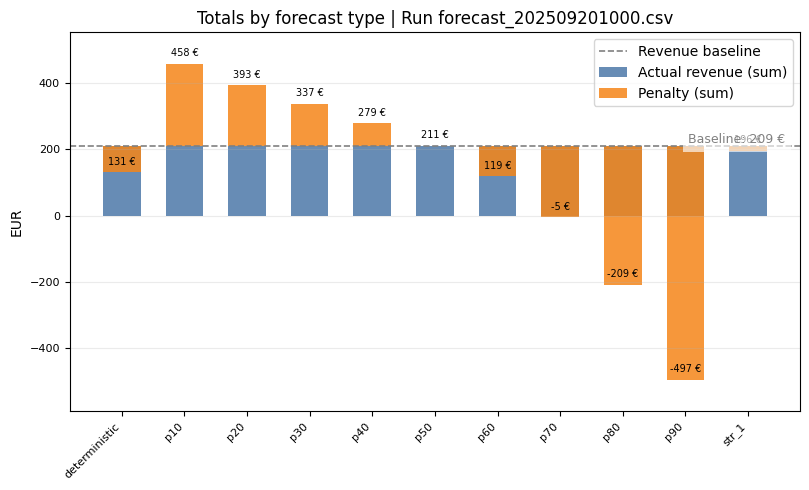

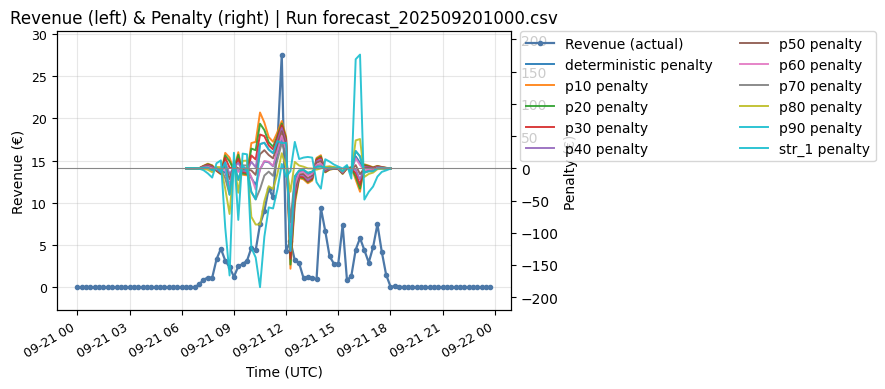

Run forecast_202509211000.csv: deterministic total_net_EUR = -1,355.13 €, str_1 = -1,219.71 €, Δ = 9.99%


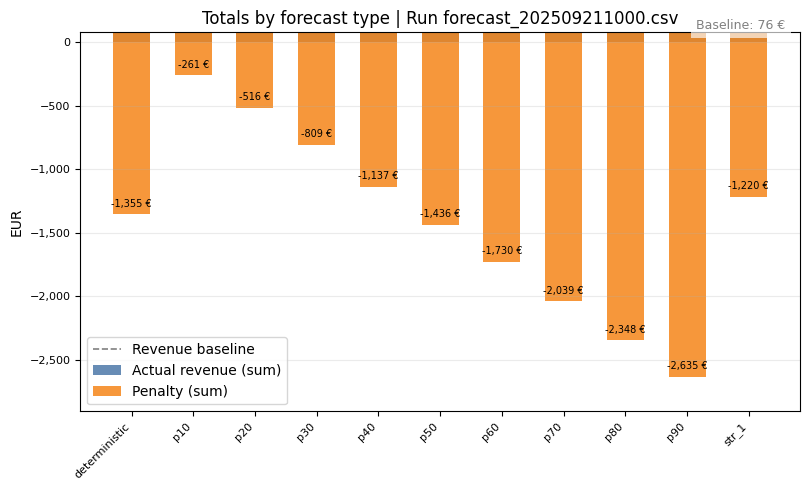

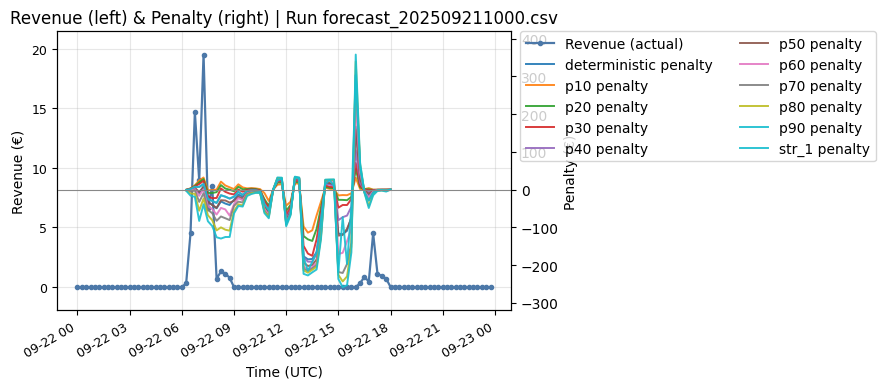

Run forecast_202509221000.csv: deterministic total_net_EUR = 357.12 €, str_1 = 920.72 €, Δ = 157.81%


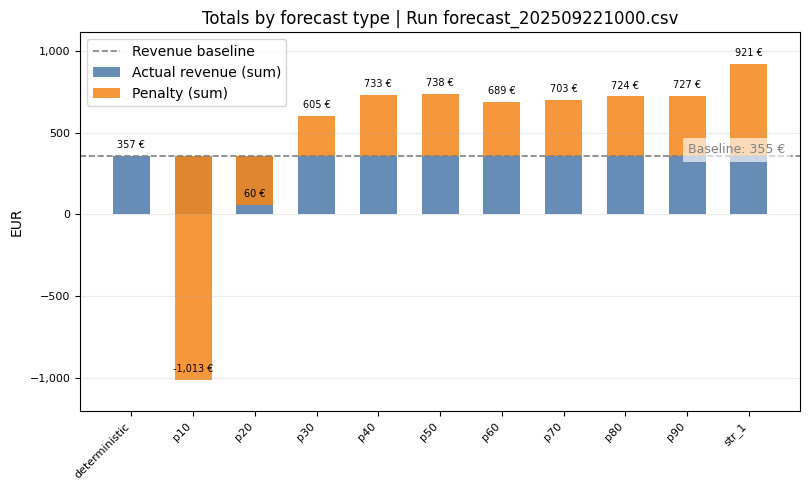

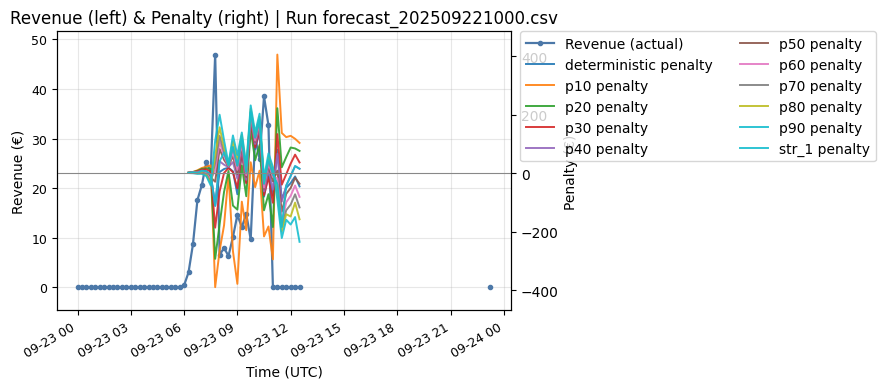

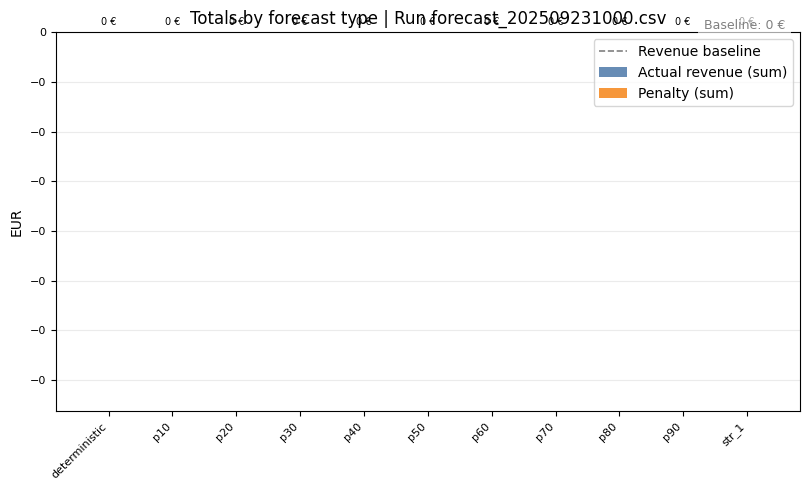

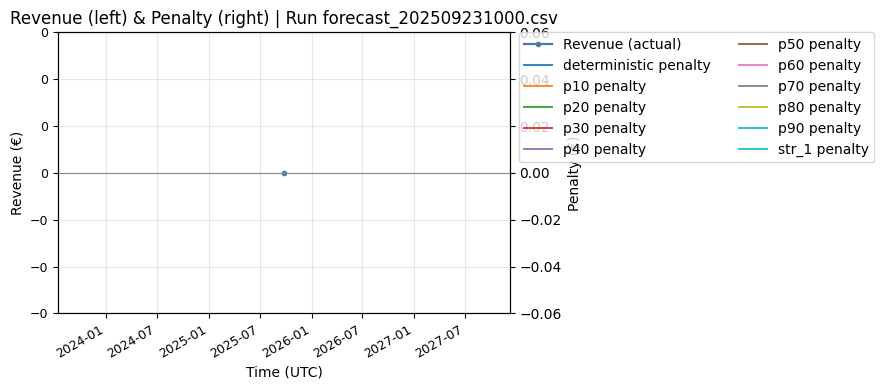

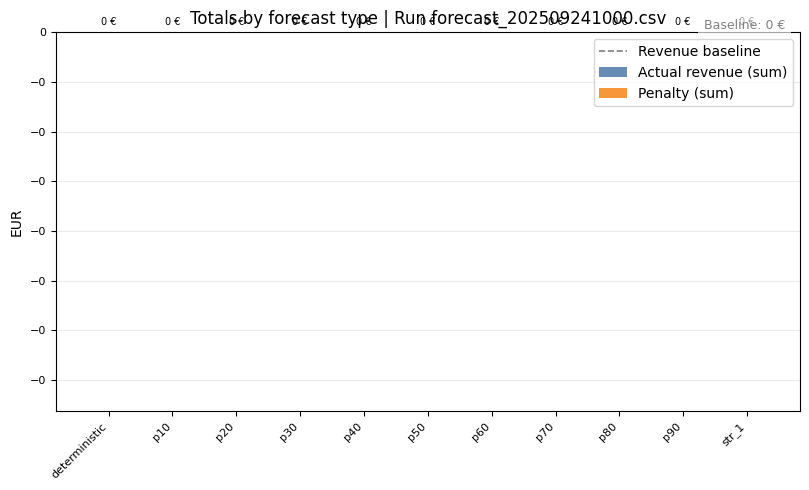

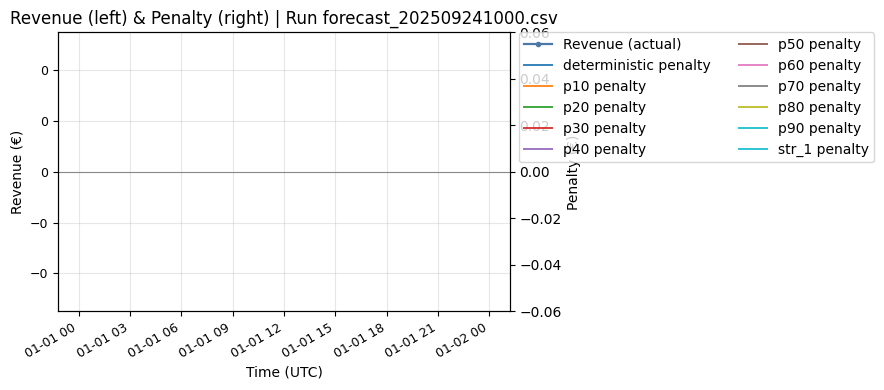

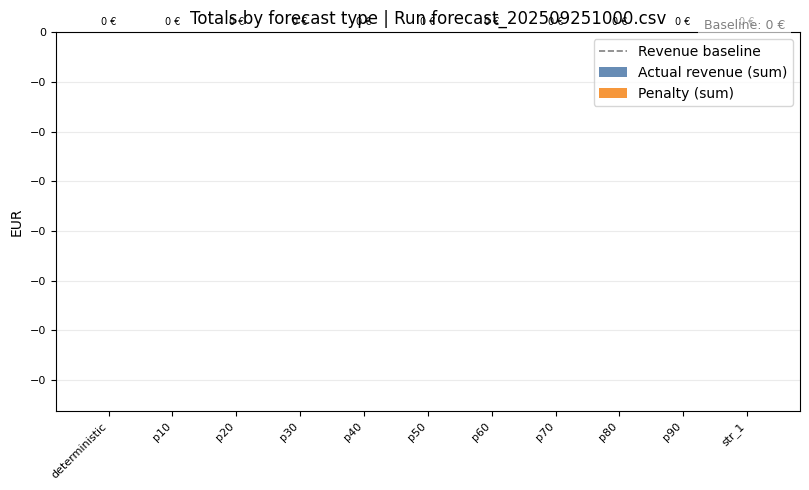

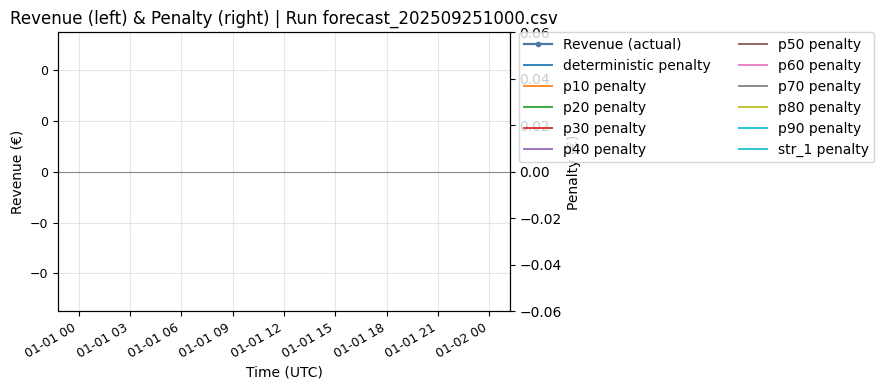

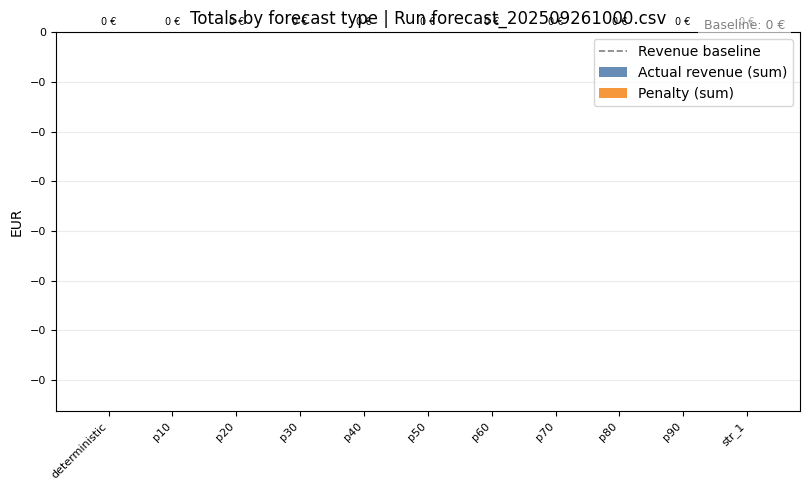

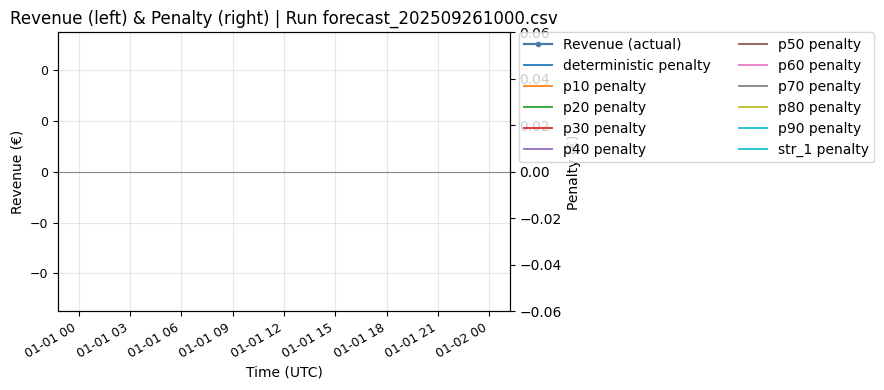

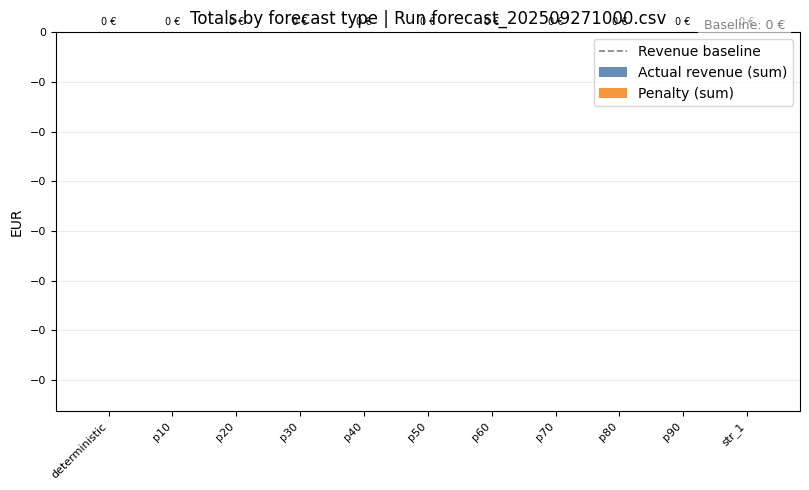

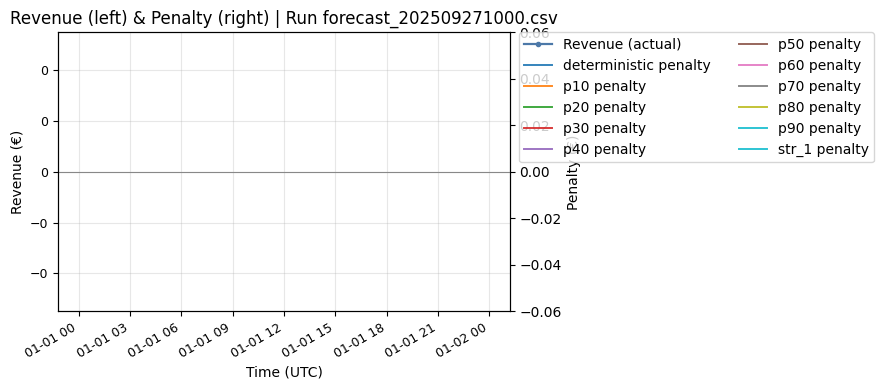

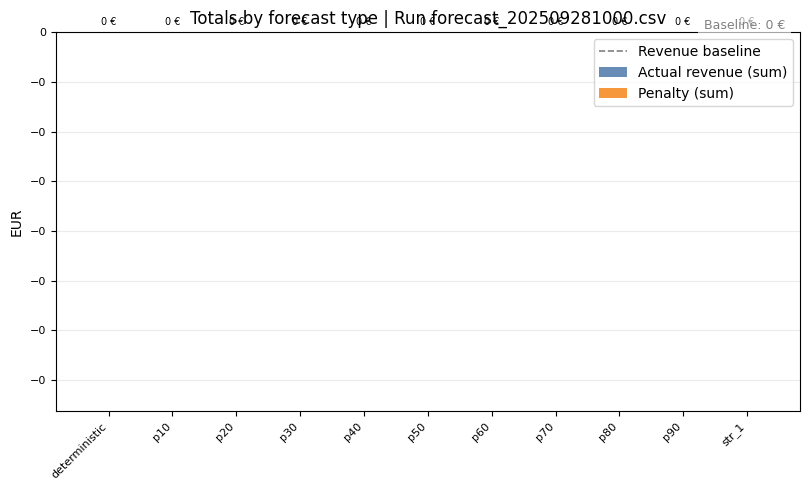

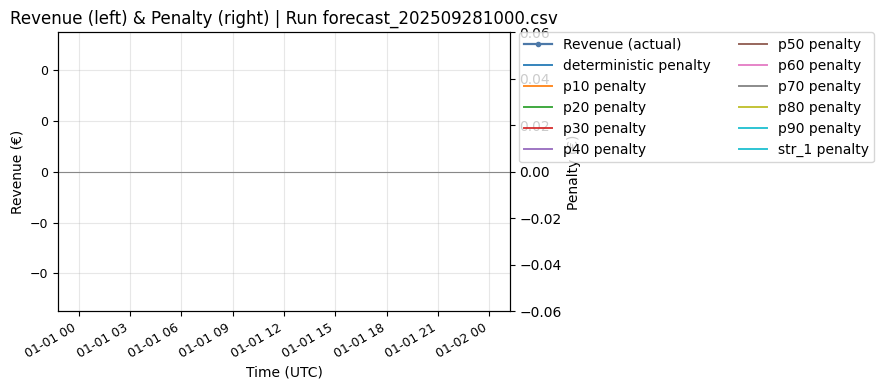

Run forecast_202509291000.csv: deterministic total_net_EUR = 293.38 €, str_1 = 234.67 €, Δ = -20.01%


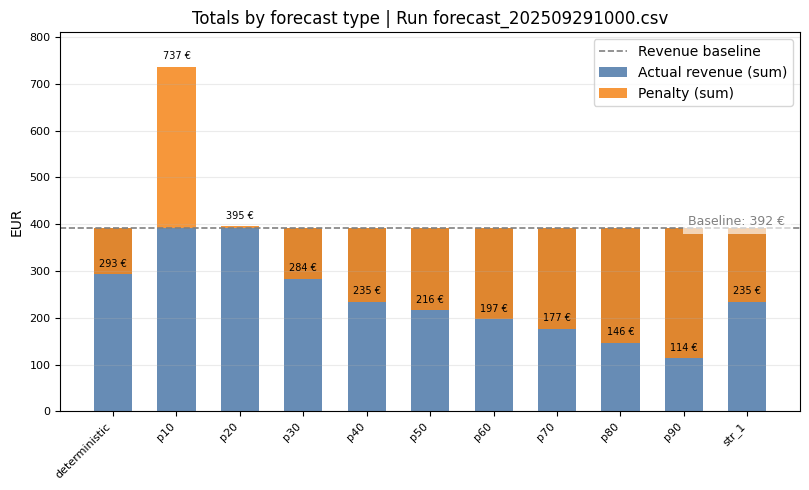

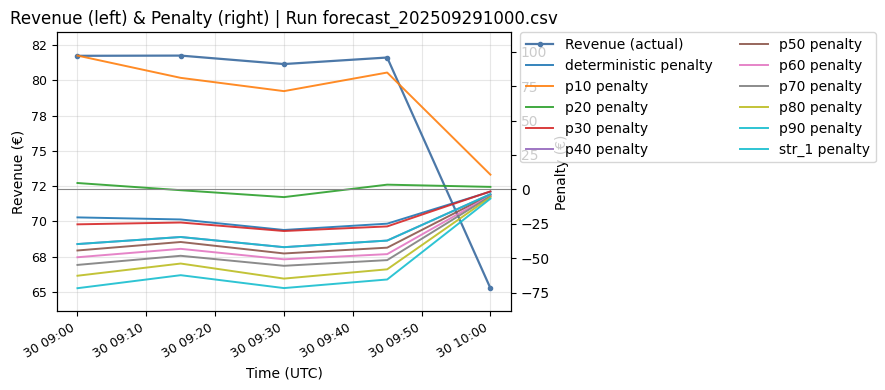

In [66]:
# ---- Graph generation across runs ----
# Adjust these parameters as needed
SELECTED_TYPES = ["deterministic", "p10", "p20", "p30", "p40", "p50", "p60", "p70", "p80", "p90", "str_1"]
START_TS = None   # e.g., "2025-09-07 00:00:00+00:00" or None
END_TS = None     # e.g., "2025-09-08 23:00:00+00:00" or None
RUNS_TO_PLOT = ["ALL"]  # use ["ALL"] for cumulative + every run; otherwise list forecast filenames
MAX_RUNS = None           # set to an integer to limit number of per-run plots

if combined_ledger.empty:
    print("combined_ledger is empty — run the build cell first.")
else:
    unique_runs = sorted(combined_ledger["forecast_file"].unique())

    if RUNS_TO_PLOT is None:
        runs_iter = []
        plot_all = False
    else:
        plot_all = "ALL" in RUNS_TO_PLOT or len(RUNS_TO_PLOT) == 0
        runs_iter = unique_runs if plot_all else [run for run in RUNS_TO_PLOT if run in unique_runs]

    if plot_all:
        plot_ledger_subset(combined_ledger, "All runs (cumulative)", start_ts=START_TS, end_ts=END_TS,
                           selected_types=SELECTED_TYPES, aggregate_runs=True)

    if MAX_RUNS is not None:
        runs_iter = runs_iter[:MAX_RUNS]

    for run_name in runs_iter:
        plot_ledger_subset(combined_ledger[combined_ledger["forecast_file"] == run_name],
                           f"Run {run_name}",
                           start_ts=START_TS,
                           end_ts=END_TS,
                           selected_types=SELECTED_TYPES,
                           aggregate_runs=False)


In [67]:
# Net revenue boxplot across forecast types with outliers and stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _ensure_utc(ts):
    if ts is None:
        return None
    ts = pd.to_datetime(ts)
    try:
        # If naive, localize to UTC; if tz-aware, convert to UTC
        if ts.tzinfo is None or ts.tzinfo.utcoffset(ts) is None:
            return ts.tz_localize("UTC")
        return ts.tz_convert("UTC")
    except Exception:
        # Fallback if it's a sequence or something unusual
        return pd.to_datetime(ts, utc=True)

def plot_net_revenue_boxplot(
    df,
    label="",
    start_ts=None,
    end_ts=None,
    include_types=None,
    show_outliers=True,
    figsize=(12, 6),
):
    """
    Box plot of net_revenue_EUR by forecast_type.
    - Shows outliers (toggle with show_outliers)
    - Shows means
    - Annotates μ, σ², n per forecast_type

    Args:
        df: DataFrame with columns ['target_time','forecast_type','net_revenue_EUR', 'revenue_EUR','penalty_EUR']
        label: Optional subtitle text.
        start_ts/end_ts: Optional datetime-like to filter target_time (interpreted/converted to UTC).
        include_types: Optional list of forecast types to include; if None uses all present.
        show_outliers: Whether to plot outliers.
        figsize: Figure size.
    """
    if df is None or len(df) == 0:
        raise ValueError("Input DataFrame is empty. Build or load 'combined_ledger' first.")

    s = df.copy()

    # Ensure target_time exists and filter by time if provided
    if "target_time" not in s.columns:
        raise ValueError("DataFrame must contain a 'target_time' column.")
    s = s[pd.notnull(s["target_time"])]

    st = _ensure_utc(start_ts) if start_ts is not None else None
    et = _ensure_utc(end_ts) if end_ts is not None else None
    if st is not None:
        s = s[s["target_time"] >= st]
    if et is not None:
        s = s[s["target_time"] <= et]

    # Select forecast types
    if include_types is None:
        include_types = (
            s["forecast_type"]
            .dropna()
            .astype(str)
            .sort_values()
            .unique()
            .tolist()
        )
    else:
        include_types = [str(t) for t in include_types]

    s = s[s["forecast_type"].astype(str).isin(include_types)]

    # Ensure net_revenue_EUR exists
    if "net_revenue_EUR" not in s.columns:
        if {"revenue_EUR", "penalty_EUR"}.issubset(s.columns):
            s = s.copy()
            s["net_revenue_EUR"] = s["revenue_EUR"] - s["penalty_EUR"]
        else:
            raise ValueError("Missing 'net_revenue_EUR' (or revenue/penalty to compute it).")

    # Build data series per type
    data = [s.loc[s["forecast_type"].astype(str) == t, "net_revenue_EUR"].dropna().values for t in include_types]

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim(top=600,bottom=-600)
    bp = ax.boxplot(
        data,
        labels=include_types,
        showmeans=True,
        meanline=False,
        showfliers=show_outliers,
        patch_artist=True,
    )

    # Color boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(include_types))) if len(include_types) > 0 else []
    for patch, c in zip(bp.get("boxes", []), colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.75)

    # Titles/labels
    subtitle = f" | {label}" if label else ""
    ax.set_title(f"Net revenue by forecast type{subtitle}")
    ax.set_ylabel("Net revenue [EUR]")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # Annotate μ, σ², n right above the top whisker of each box
    whiskers = bp.get("whiskers", [])
    for i, t in enumerate(include_types, start=1):
        vals = s.loc[s["forecast_type"].astype(str) == t, "net_revenue_EUR"].dropna().values
        if vals.size == 0:
            continue
        mu = float(np.mean(vals))
        var = float(np.var(vals, ddof=1)) if vals.size > 1 else 0.0
        n = int(vals.size)
        # Top whisker is the second whisker per box: index 2*(i-1)+1
        if 2 * (i - 1) + 1 < len(whiskers):
            y_top = whiskers[2 * (i - 1) + 1].get_ydata()[1]
        else:
            y_top = np.nanmax(vals)
        ax.text(
            i,
            y_top,
            f"μ={mu:,.0f}\nσ²={var:,.0f}\nn={n}",
            fontsize=9,
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.8),
        )

    fig.tight_layout()
    plt.show()

# Example usage (adjust include_types or time window as needed):
# include_types = sorted(combined_ledger['forecast_type'].astype(str).unique())
# plot_net_revenue_boxplot(
#     combined_ledger,
#     label="All horizons",
#     include_types=include_types,
#     show_outliers=True
# )

/tmp/ipykernel_6666/3320882261.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


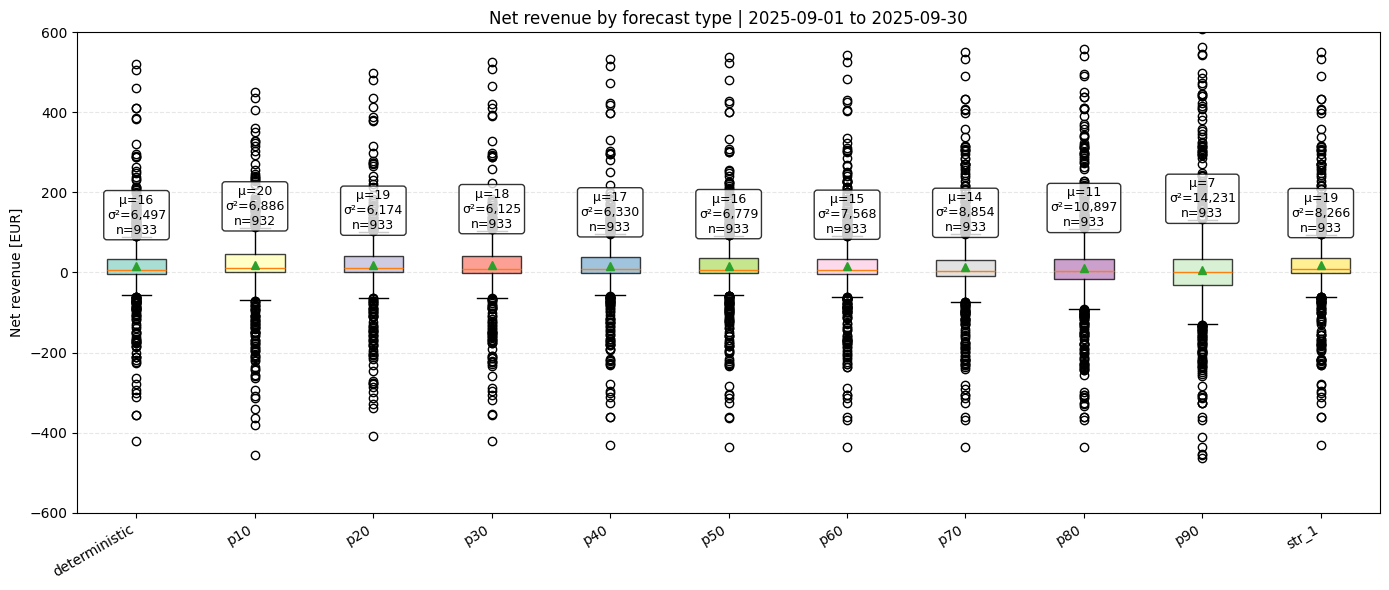

In [68]:
# --- RUN THE BOX PLOT ---
if "combined_ledger" not in globals() or combined_ledger is None or combined_ledger.empty:
    print("combined_ledger is empty or missing — run the build cell first.")
else:
    # Reuse your earlier selections if present; otherwise detect all types
    try:
        include_types = [str(t) for t in SELECTED_TYPES]
    except NameError:
        include_types = (
            combined_ledger["forecast_type"]
            .dropna().astype(str).sort_values().unique().tolist()
        )

    # Optional reuse of your global time window if you set them earlier
    try:
        _start = START_TS
    except NameError:
        _start = None
    try:
        _end = END_TS
    except NameError:
        _end = None

    plot_net_revenue_boxplot(
        combined_ledger,
        label="2025-09-01 to 2025-09-30",
        start_ts=_start,
        end_ts=_end,
        include_types=include_types,
        show_outliers=True,
        figsize=(14, 6),
    )


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ledger_subset(
    df,
    label="",
    start_ts=None,
    end_ts=None,
    include_types=None,
    figsize=(16, 6),
):
    """
    Two-panel plot:
    - Left: stacked bars per forecast_type (Revenue + Penalty), dashed baseline showing total unique revenue,
      and net annotations atop each bar. Autoscaled with margins to avoid overlap.
    - Right: time-series of Revenue (unique per target_time) and total Penalty (sum across included types)
      on twin y-axes. Autoscaled and formatted for readability.

    Baseline revenue is computed by summing revenue_EUR after de-duplicating by target_time
    to avoid double-counting across forecast types.

    Args:
        df: DataFrame with columns ['target_time','forecast_type','revenue_EUR','penalty_EUR', ...]
        label: Optional subtitle text.
        start_ts/end_ts: Optional datetime-like to filter target_time (interpreted/converted to UTC).
        include_types: Optional list of forecast types to include; if None uses all present.
        figsize: Figure size.
    """
    if df is None or len(df) == 0:
        raise ValueError("Input DataFrame is empty. Build or load 'combined_ledger' first.")

    s = df.copy()
    if "target_time" not in s.columns:
        raise ValueError("DataFrame must contain a 'target_time' column.")
    s = s[pd.notnull(s["target_time"])]

    def _to_utc(ts):
        if ts is None:
            return None
        ts = pd.to_datetime(ts)
        try:
            if ts.tzinfo is None or ts.tzinfo.utcoffset(ts) is None:
                return ts.tz_localize("UTC")
            return ts.tz_convert("UTC")
        except Exception:
            return pd.to_datetime(ts, utc=True)

    st = _to_utc(start_ts) if start_ts is not None else None
    et = _to_utc(end_ts) if end_ts is not None else None
    if st is not None:
        s = s[s["target_time"] >= st]
    if et is not None:
        s = s[s["target_time"] <= et]

    # Decide types
    if include_types is None:
        include_types = (
            s["forecast_type"]
            .dropna()
            .astype(str)
            .sort_values()
            .unique()
            .tolist()
        )
    else:
        include_types = [str(t) for t in include_types]
    s = s[s["forecast_type"].astype(str).isin(include_types)]

    # Aggregate totals by type
    need_cols = {"revenue_EUR", "penalty_EUR"}
    if not need_cols.issubset(s.columns):
        raise ValueError(f"DataFrame must contain columns: {need_cols}")
    agg = (
        s.groupby(s["forecast_type"].astype(str))
        .agg(revenue_EUR=("revenue_EUR", "sum"), penalty_EUR=("penalty_EUR", "sum"))
        .reindex(include_types)
        .fillna(0.0)
    )

    # Baseline: sum unique revenue per timestamp (avoid double-counting across types)
    rev_unique = (
        s.sort_values("target_time")
         .drop_duplicates(subset="target_time", keep="first")
    )
    rev_baseline_total = float(rev_unique["revenue_EUR"].sum()) if len(rev_unique) else 0.0

    # Time-series penalty: sum across included types per timestamp
    pen_ts = (
        s.groupby("target_time", as_index=False)["penalty_EUR"]
        .sum()
        .sort_values("target_time")
    )

    # Figure with two panels
    fig, (ax0, ax1_left) = plt.subplots(
        1, 2, figsize=figsize, gridspec_kw={"width_ratios": [1.2, 2]}
    )
    ax1_right = ax1_left.twinx()

    # Left: stacked bars + baseline
    x = np.arange(len(include_types))
    rev_vals = agg["revenue_EUR"].values
    pen_vals = agg["penalty_EUR"].values

    ax0.bar(x, rev_vals, label="Revenue", color="tab:blue")
    ax0.bar(x, pen_vals, bottom=rev_vals, label="Penalty", color="tab:red", alpha=0.7)

    # Baseline as dashed line + label (no markers)
    ax0.axhline(rev_baseline_total, linestyle="--", color="black", linewidth=1.0)
    if len(x) > 0:
        ax0.text(
            x[-1] + 0.5,
            rev_baseline_total,
            f"Baseline: {rev_baseline_total:,.0f} €",
            ha="left",
            va="center",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.85),
        )

    ax0.set_xticks(x)
    ax0.set_xticklabels(include_types, rotation=30, ha="right")
    ax0.set_ylabel("EUR")
    subtitle = f" | {label}" if label else ""
    ax0.set_title(f"Totals by forecast type{subtitle}")
    ax0.grid(axis="y", linestyle="--", alpha=0.3)

    # Annotate net per bar (revenue - penalty)
    net_vals = rev_vals - pen_vals
    tops = rev_vals + pen_vals
    for i, (t, n) in enumerate(zip(tops, net_vals)):
        ax0.text(i, t, f"net={n:,.0f}", ha="center", va="bottom", fontsize=9)

    # Autoscale and margins to reduce overlap
    ax0.relim()
    ax0.autoscale_view()
    ax0.margins(y=0.12)
    ax0.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))

    # Right: time-series revenue (unique) and penalty (sum across types)
    if len(rev_unique) > 0:
        ax1_left.plot(
            rev_unique["target_time"],
            rev_unique["revenue_EUR"],
            label="Revenue (unique)",
            color="tab:blue",
        )
    if len(pen_ts) > 0:
        ax1_right.plot(
            pen_ts["target_time"],
            pen_ts["penalty_EUR"],
            label="Penalty (sum)",
            color="tab:red",
            alpha=0.8,
        )

    ax1_left.set_xlabel("Time")
    ax1_left.set_ylabel("Revenue [EUR]", color="tab:blue")
    ax1_right.set_ylabel("Penalty [EUR]", color="tab:red")
    for tl in ax1_left.get_yticklabels():
        tl.set_color("tab:blue")
    for tl in ax1_right.get_yticklabels():
        tl.set_color("tab:red")
    ax1_left.grid(axis="y", linestyle="--", alpha=0.3)

    # Autoscale both y-axes and give a little breathing room
    for ax in (ax1_left, ax1_right):
        ax.relim()
        ax.autoscale_view()
        ax.margins(y=0.12)
    fig.autofmt_xdate()

    # Combined legend for the right panel
    l1, lbl1 = ax1_left.get_legend_handles_labels()
    l2, lbl2 = ax1_right.get_legend_handles_labels()
    if l1 or l2:
        ax1_left.legend(l1 + l2, lbl1 + lbl2, loc="upper left", bbox_to_anchor=(1.02, 1.0))

    fig.tight_layout()
    plt.show()

# Example usage (adjust as needed):
# plot_ledger_subset(
#     combined_ledger,
#     label="Selected range",
#     start_ts=None,  # e.g., "2025-07-07 00:00:00+00:00"
#     end_ts=None,    # e.g., "2025-07-08 00:00:00+00:00"
#     include_types=sorted(combined_ledger['forecast_type'].astype(str).unique()),
# )

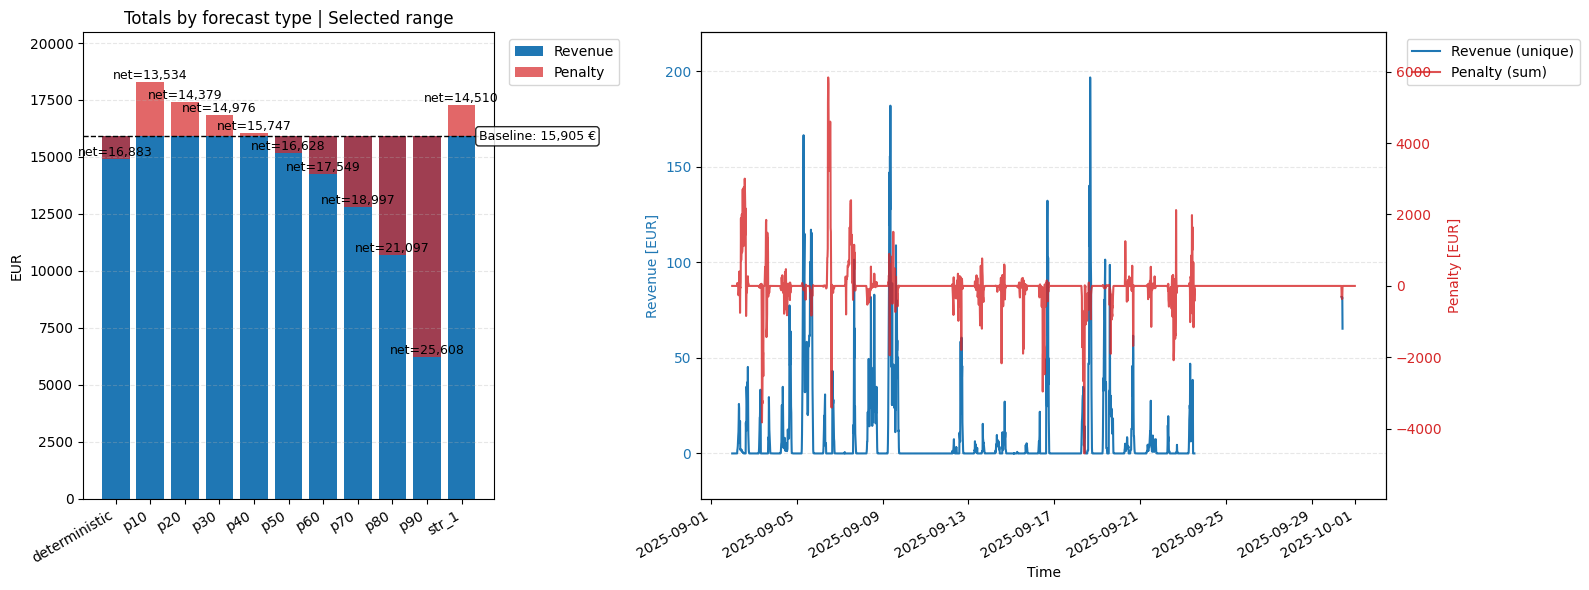

In [70]:
# --- RUN THE 2-PANEL PLOT ---
if "combined_ledger" not in globals() or combined_ledger is None or combined_ledger.empty:
    print("combined_ledger is empty or missing — run the build cell first.")
else:
    try:
        include_types = [str(t) for t in SELECTED_TYPES]
    except NameError:
        include_types = (
            combined_ledger["forecast_type"]
            .dropna().astype(str).sort_values().unique().tolist()
        )

    try:
        _start = START_TS
    except NameError:
        _start = None
    try:
        _end = END_TS
    except NameError:
        _end = None

    plot_ledger_subset(
        combined_ledger,
        label="Selected range",
        start_ts=_start,
        end_ts=_end,
        include_types=include_types,
        figsize=(16, 6),
    )
